In [1]:
import argparse
import sys
import re
import os
import cv2

import numpy as np
import glob
import pickle

import time
import math
import webcolors

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.externals import joblib

from moviepy.editor import VideoFileClip

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
%matplotlib inline

## Camera calibration

Computation of the calibration parameters, and example proving we obtain the expected result.

In [3]:
class CameraCal():

    # initialize - either go through and calculate the camera
    # calibration if no pickle file exists
    # or just load the pickle file.
    def __init__(self, calibration_dir, pickle_file):
        # Initialize cameraCal
        self.mtx = None
        self.dist = None
        self.img_size = None

        if not os.path.isfile(pickle_file):
            objpoints = []  # 3d points in real world space
            imgpoints = []  # 2d points in image plane.

            # prepare object points: (0,0,0), (1,0,0), (2,0,0) .., (6,5,0)
            # The images may have different detected checker board dimensions!
            # Currently, possible dimension combinations are: (9,6), (8,6),
            # (9,5), (9,4) and (7,6)
            objp1 = np.zeros((6 * 9, 3), np.float32)
            objp1[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
            objp2 = np.zeros((6 * 8, 3), np.float32)
            objp2[:, :2] = np.mgrid[0:8, 0:6].T.reshape(-1, 2)
            objp3 = np.zeros((5 * 9, 3), np.float32)
            objp3[:, :2] = np.mgrid[0:9, 0:5].T.reshape(-1, 2)
            objp4 = np.zeros((4 * 9, 3), np.float32)
            objp4[:, :2] = np.mgrid[0:9, 0:4].T.reshape(-1, 2)
            objp5 = np.zeros((6 * 7, 3), np.float32)
            objp5[:, :2] = np.mgrid[0:7, 0:6].T.reshape(-1, 2)
            objp6 = np.zeros((6 * 5, 3), np.float32)
            objp6[:, :2] = np.mgrid[0:5, 0:6].T.reshape(-1, 2)

            text = 'Performing camara calibrations against chessboard images: '
            print('{}"./{}/calibration*.jpg"...'.format(text, calibration_dir))
            # Make a list of calibration images
            images = glob.glob(calibration_dir + '/calibration*.jpg')

            # Step through the list and search for chessboard corners
            for idx, fname in enumerate(images):
                img = cv2.imread(fname)
                img2 = np.copy(img)
                self.img_size = (img.shape[1], img.shape[0])
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                # Find the chessboard corners using possible combinations of
                # dimensions.
                ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
                objp = objp1
                if not ret:
                    ret, corners = cv2.findChessboardCorners(
                        gray, (8, 6), None)
                    objp = objp2
                if not ret:
                    ret, corners = cv2.findChessboardCorners(
                        gray, (9, 5), None)
                    objp = objp3
                if not ret:
                    ret, corners = cv2.findChessboardCorners(
                        gray, (9, 4), None)
                    objp = objp4
                if not ret:
                    ret, corners = cv2.findChessboardCorners(
                        gray, (7, 6), None)
                    objp = objp5
                if not ret:
                    ret, corners = cv2.findChessboardCorners(
                        gray, (5, 6), None)
                    objp = objp6
                # print("corners: ", corners.shape, "\n", corners)

                # If found, add object points, image points
                if ret:
                    objpoints.append(objp)
                    imgpoints.append(corners)
                    cv2.drawChessboardCorners(img2,
                                              (corners.shape[1],
                                               corners.shape[0]),
                                              corners, ret)
                    ret, self.mtx, self.dist, self.rvecs, self.tvecs = \
                        cv2.calibrateCamera(objpoints, imgpoints,
                                            self.img_size, None, None)

            # done and found all chessboard corners.
            # now time to save the results into a pickle file for later
            # retrieval without additional calculations.
            try:
                with open(pickle_file, 'w+b') as pfile1:
                    text = 'Saving data to pickle file'
                    print('{}: {} ...'.format(text, pickle_file))
                    pickle.dump({'img_size': self.img_size,
                                 'mtx': self.mtx,
                                 'dist': self.dist,
                                 'rvecs': self.rvecs,
                                 'tvecs': self.tvecs},
                                pfile1, pickle.HIGHEST_PROTOCOL)
                    print("Camera Calibration Data saved to", pickle_file)
            except Exception as e:
                print('Unable to save data to', pickle_file, ':', e)
                raise

        # previously saved pickle file of the distortion correction data
        # has been found.  go ahead and revive it.
        else:
            try:
                with open(pickle_file, 'rb') as f:
                    pickle_data = pickle.load(f)
                    self.img_size = pickle_data['img_size']
                    self.mtx = pickle_data['mtx']
                    self.dist = pickle_data['dist']
                    self.rvecs = pickle_data['rvecs']
                    self.tvecs = pickle_data['tvecs']
                    del pickle_data
                    print("Camera Calibration data restored from", pickle_file)
            except Exception as e:
                print('Unable to restore camera calibration data from',
                      pickle_file, ':', e)
                raise

    # if the source image is now smaller than the original calibration image
    # just set it
    def setImageSize(self, img_shape):
        self.img_size = (img_shape[1], img_shape[0])

    # Get a subset of the camera calibration result that
    # the rest of the pipeline wants
    def get(self):
        return self.mtx, self.dist, self.img_size

    # Get all of the camera calibration result that
    # the rest of the pipeline wants
    def getall(self):
        return self.mtx, self.dist, self.img_size, self.rvecs, self.tvecs

## Image Filter

Image Filter

In [4]:
class ImageFilters():
    # Initialize ImageFilter

    def __init__(self, camCal, projectedX, projectedY,
                 defaultThrowDistance=100.0, debug=False):
        # set debugging
        self.debug = debug

        # frameNumber
        self.curFrame = None

        # our own copy of the camera calibration results
        self.mtx, self.dist, self.img_size = camCal.get()

        # normal image size
        self.x, self.y = self.img_size

        # projected image size
        self.projectedX = projectedX
        self.projectedY = projectedY

        # mid point in picture (by height)
        self.mid = int(self.y / 2)

        # current Image RGB - undistorted
        self.curImage = np.zeros((self.y, self.x, 3), dtype=np.float32)

        # current Image Top half RGB
        self.curSkyRGB = np.zeros((self.mid, self.x, 3), dtype=np.float32)

        # current Image Bottom half RGB
        self.curRoadRGB = np.zeros((self.mid, self.x, 3), dtype=np.float32)

        # current Sky Luma Image
        self.curSkyL = np.zeros((self.mid, self.x), dtype=np.float32)

        # current Road Luma Image
        self.curRoadL = np.zeros((self.mid, self.x), dtype=np.float32)

        # current Edge
        self.curRoadEdge = np.zeros((self.mid, self.x), dtype=np.uint8)
        self.curRoadEdgeProjected = np.zeros(
            (self.projectedY, self.projectedX, 3), dtype=np.uint8)

        # current Projected image
        self.curRoadProjected = np.zeros(
            (self.projectedY, self.projectedX, 3), dtype=np.uint8)

        # image stats
        self.skylrgb = np.zeros((4), dtype=np.float32)
        self.roadlrgb = np.zeros((4), dtype=np.float32)
        self.roadbalance = 0.0
        self.horizonFound = False
        self.roadhorizon = 0
        self.visibility = 0
        self.defaultThrowDistance = defaultThrowDistance
        self.throwDistanceFound = False
        self.throwDistancePixel = self.projectedY
        self.throwDistance = defaultThrowDistance

        # Textural Image Info
        self.skyText = 'NOIMAGE'
        self.skyImageQ = 'NOIMAGE'
        self.roadText = 'NOIMAGE'
        self.roadImageQ = 'NOIMAGE'

        # set up debugging diag screens
        if self.debug:
            self.diag1 = np.zeros((self.mid, self.x, 3), dtype=np.float32)
            self.diag2 = np.zeros((self.mid, self.x, 3), dtype=np.float32)
            self.diag3 = np.zeros((self.mid, self.x, 3), dtype=np.float32)
            self.diag4 = np.zeros((self.mid, self.x, 3), dtype=np.float32)

    # Define a function to chop a picture in half horizontally
    def makehalf(self, image, half=0):
        if half == 0:
            if len(image.shape) < 3:
                newimage = np.copy(image[self.mid:self.y, :])
            else:
                newimage = np.copy(image[self.mid:self.y, :, :])
        else:
            if len(image.shape) < 3:
                newimage = np.copy(image[0:self.mid, :])
            else:
                newimage = np.copy(image[0:self.mid, :, :])
        return newimage

    # Define a function to make a half picture whole horizontally
    def makefull(self, image, half=0):
        if len(image.shape) < 3:
            newimage = np.zeros((self.y, self.x), dtype=np.uint8)
        else:
            newimage = np.zeros((self.y, self.x, 3), dtype=np.uint8)

        if half == 0:
            if len(image.shape) < 3:
                newimage[self.mid:self.y, :] = image
            else:
                newimage[self.mid:self.y, :, :] = image
        else:
            if len(image.shape) < 3:
                newimage[0:self.mid, :] = image
            else:
                newimage[0:self.mid, :, :] = image
        return newimage

    # Define a function that attempts to masks out yellow lane lines
    def image_only_yellow_white(self, image):
        # setup inRange to mask off everything except white and yellow
        lower_yellow_white = np.array([140, 140, 64])
        upper_yellow_white = np.array([255, 255, 255])
        mask = cv2.inRange(image, lower_yellow_white, upper_yellow_white)
        return cv2.bitwise_and(image, image, mask=mask)

    # Define a function that applies Gaussian Noise kernel
    def gaussian_blur(self, img, kernel_size):
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    # Define a function that applies Canny transform
    def canny(self, img, low_threshold, high_threshold, kernel_size):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        blur_gray = self.gaussian_blur(gray, kernel_size)
        return cv2.Canny(
            blur_gray.astype(np.uint8), low_threshold, high_threshold)

    # Define a function that applies Sobel x or y,
    # then takes an absolute value and applies a threshold.
    def abs_sobel_thresh(self, img, orient='x', thresh=(0, 255)):
        # Apply the following steps to img
        # 1) Convert to grayscale
        # 2) Take the derivative in x or y given orient = 'x' or 'y'
        # 3) Take the absolute value of the derivative or gradient
        # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        # 5) Create a mask of 1's where the scaled gradient magnitude
        #    is > thresh_min and < thresh_max
        # 6) Return this mask as your binary_output image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        if orient == 'x':
            sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
            abs_sobel = np.absolute(sobelx)
        if orient == 'y':
            sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
            abs_sobel = np.absolute(sobely)
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
        # Create a copy and apply the threshold
        ret, binary_output = cv2.threshold(
            scaled_sobel, thresh[0], thresh[1], cv2.THRESH_BINARY)
        # Return the result
        return binary_output

    # Define a function that applies Sobel x and y,
    # then computes the magnitude of the gradient
    # and applies a threshold
    def mag_thresh(self, img, sobel_kernel=3, mag_thresh=(0, 255)):
        # Apply the following steps to img
        # 1) Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # 2) Take the gradient in x and y separately
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # 3) Calculate the magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scale_factor = np.max(gradmag) / 255
        gradmag = (gradmag / scale_factor).astype(np.uint8)
        # 6) Create a binary mask where mag thresholds are met
        ret, mag_binary = cv2.threshold(
            gradmag, mag_thresh[0], mag_thresh[1], cv2.THRESH_BINARY)
        # 7) Return this mask as your binary_output image
        return mag_binary

    # Define a function that applies Sobel x and y,
    # then computes the direction of the gradient
    # and applies a threshold.
    def dir_threshold(self, img, sobel_kernel=3, thresh=(0, np.pi / 2)):
        # Apply the following steps to img
        # 1) Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # 2) Take the gradient in x and y separately
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # 3) Calculate the direction of the gradient
        # 4) Take the absolute value
        with np.errstate(divide='ignore', invalid='ignore'):
            dirout = np.absolute(np.arctan(sobely / sobelx))
            # 5) Create a binary mask where direction thresholds are met
            dir_binary = np.zeros_like(dirout).astype(np.float32)
            dir_binary[(dirout > thresh[0]) & (dirout < thresh[1])] = 1
            # 6) Return this mask as your binary_output image
        # update nan to number
        np.nan_to_num(dir_binary)
        # make it fit
        dir_binary[(dir_binary > 0) | (dir_binary < 0)] = 128
        return dir_binary.astype(np.uint8)

    # Python 3 has support for cool math symbols.
    def miximg(self, img1, img2, α=0.8, β=1., λ=0.):
        """
        The result image is computed as follows:
        img1 * α + img2 * β + λ
        NOTE: img1 and img2 must be the same shape!
        """
        return cv2.addWeighted(img1.astype(np.uint8),
                               α, img2.astype(np.uint8), β, λ)

    # Define a function that thresholds the S-channel of HLS
    def hls_s(self, img, thresh=(0, 255)):
        # 1) Convert to HLS color space
        # 2) Apply a threshold to the S channel
        # 3) Return a binary image of threshold result
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s = hls[:, :, 2]
        retval, s_binary = cv2.threshold(s.astype('uint8'), thresh[
                                         0], thresh[1], cv2.THRESH_BINARY)
        return s_binary

    # Define a function that thresholds the H-channel of HLS
    def hls_h(self, img, thresh=(0, 255)):
        # 1) Convert to HLS color space
        # 2) Apply a threshold to the S channel
        # 3) Return a binary image of threshold result
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        h = hls[:, :, 0]
        retval, h_binary = cv2.threshold(h.astype('uint8'), thresh[
                                         0], thresh[1], cv2.THRESH_BINARY)
        return h_binary

    # retrieve edges detected by the filter combinations (used by other
    # modules to locate current binary image.)
    def edges(self):
        # piece together images that we want to project
        img = np.zeros((self.y, self.x, 3), dtype=np.uint8)
        img[self.mid:self.y, :, :] = np.dstack(
            (self.curRoadEdge, self.curRoadEdge, self.curRoadEdge))
        return img

    # check image quality
    def imageQ(self, image):
        self.curImage = cv2.undistort(
            image, self.mtx, self.dist, None, self.mtx).astype(np.float32)
        self.yuv = cv2.cvtColor(
            self.curImage, cv2.COLOR_RGB2YUV).astype(np.float32)

        # get some stats for the sky image
        self.curSkyL = self.yuv[0:self.mid, :, 0]
        self.curSkyRGB[:, :] = self.curImage[0:self.mid, :]
        self.skylrgb[0] = np.average(self.curSkyL[0:self.mid, :])
        self.skylrgb[1] = np.average(self.curSkyRGB[0:self.mid, :, 0])
        self.skylrgb[2] = np.average(self.curSkyRGB[0:self.mid, :, 1])
        self.skylrgb[3] = np.average(self.curSkyRGB[0:self.mid, :, 2])

        # get some stats for the road image
        self.curRoadL = self.yuv[self.mid:self.y, :, 0]
        self.curRoadRGB[:, :] = self.curImage[self.mid:self.y, :]
        self.roadlrgb[0] = np.average(self.curRoadL[0:self.mid, :])
        self.roadlrgb[1] = np.average(self.curRoadRGB[0:self.mid, :, 0])
        self.roadlrgb[2] = np.average(self.curRoadRGB[0:self.mid, :, 1])
        self.roadlrgb[3] = np.average(self.curRoadRGB[0:self.mid, :, 2])

        # Sky image condition
        if self.skylrgb[0] > 160:
            self.skyImageQ = 'Sky Image: overexposed'
        elif self.skylrgb[0] < 50:
            self.skyImageQ = 'Sky Image: underexposed'
        elif self.skylrgb[0] > 143:
            self.skyImageQ = 'Sky Image: normal bright'
        elif self.skylrgb[0] < 113:
            self.skyImageQ = 'Sky Image: normal dark'
        else:
            self.skyImageQ = 'Sky Image: normal'

        # Sky detected weather or lighting conditions
        if self.skylrgb[0] > 128:
            if self.skylrgb[3] > self.skylrgb[0]:
                if self.skylrgb[1] > 120 and self.skylrgb[2] > 120:
                    if (self.skylrgb[2] - self.skylrgb[1]) > 20.0:
                        self.skyText = 'Sky Condition: tree shaded'
                    else:
                        self.skyText = 'Sky Condition: cloudy'
                else:
                    self.skyText = 'Sky Condition: clear'
            else:
                self.skyText = 'Sky Condition: UNKNOWN SKYL>128'
        else:
            if self.skylrgb[2] > self.skylrgb[3]:
                self.skyText = 'Sky Condition: surrounded by trees'
                self.visibility = -80
            elif self.skylrgb[3] > self.skylrgb[0]:
                if (self.skylrgb[2] - self.skylrgb[1]) > 10.0:
                    self.skyText = 'Sky Condition: tree shaded'
                else:
                    self.skyText = \
                        'Sky Condition: very cloudy or under overpass'
            else:
                self.skyText = 'Sky Condition: UNKNOWN!'

        self.roadbalance = self.roadlrgb[0] / 10.0

        # Road image condition
        if self.roadlrgb[0] > 160:
            self.roadImageQ = 'Road Image: overexposed'
        elif self.roadlrgb[0] < 50:
            self.roadImageQ = 'Road Image: underexposed'
        elif self.roadlrgb[0] > 143:
            self.roadImageQ = 'Road Image: normal bright'
        elif self.roadlrgb[0] < 113:
            self.roadImageQ = 'Road Image: normal dark'
        else:
            self.roadImageQ = 'Road Image: normal'

    # function to detect the horizon using the Sobel magnitude operation
    def horizonDetect(self, debug=False, thresh=50):
        if not self.horizonFound:
            img = np.copy(self.curRoadRGB).astype(np.uint8)
            magch = self.mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 150))
            horizonLine = 50
            while not self.horizonFound and horizonLine < int(self.y / 2):
                magchlinesum = np.sum(
                    magch[horizonLine:(horizonLine + 1), :]).astype(np.float32)
                if magchlinesum > (self.x * thresh):
                    self.horizonFound = True
                    self.roadhorizon = horizonLine + int(self.y / 2)
                    if debug:
                        self.diag4[horizonLine:(horizonLine + 1), :, 0] = 255
                        self.diag4[horizonLine:(horizonLine + 1), :, 1] = 255
                        self.diag4[horizonLine:(horizonLine + 1), :, 2] = 0
                else:
                    horizonLine += 1

    # function to detect the throw distance of the projection
    def projectionThrowDistanceDetect(self, debug=False, thresh=150.0):
        # maxThrowSum = 0
        if not self.throwDistanceFound:
            maskedEdge = np.copy(self.curRoadEdgeProjected[
                                 :, :, 1]).astype(np.uint8)
            topOfThrow = 0
            while not self.throwDistanceFound and \
                    topOfThrow < int(self.projectedY * 0.75):
                maskedEdgeLineSum = np.sum(
                     maskedEdge[topOfThrow:(topOfThrow + 1), :])
                maskedEdgeLineSum = maskedEdgeLineSum.astype(np.float32)

                # if maxThrowSum < maskedEdgeLineSum:
                #    maxThrowSum = maskedEdgeLineSum
                if maskedEdgeLineSum > thresh:
                    self.throwDistanceFound = True
                    self.throwDistancePixel = topOfThrow
                    self.throwDistance = self.throwDistance * \
                        ((self.projectedY - topOfThrow) / self.projectedY)
                    if debug:
                        self.curRoadEdgeProjected[
                            topOfThrow:(topOfThrow + 1), :, 0] = 0
                        self.curRoadEdgeProjected[
                            topOfThrow:(topOfThrow + 1), :, 1] = 255
                        self.curRoadEdgeProjected[
                            topOfThrow:(topOfThrow + 1), :, 2] = 0
                else:
                    topOfThrow += 1
        # print("maxThrowSum: ", maxThrowSum)
        return self.throwDistancePixel

    # function to attempt to balance the image exposure for easier lane line
    # detection
    def balanceEx(self):
        # separate each of the RGB color channels
        r = self.curRoadRGB[:, :, 0]
        g = self.curRoadRGB[:, :, 1]
        b = self.curRoadRGB[:, :, 2]
        # Get the Y channel (Luma) from the YUV color space
        # and make two copies
        yo = np.copy(self.curRoadL[:, :]).astype(np.float32)
        yc = np.copy(self.curRoadL[:, :]).astype(np.float32)
        # use the balance factor calculated previously to calculate the
        # corrected Y
        yc = (yc / self.roadbalance) * 8.0
        # make a copy and threshold it to maximum value 255.
        lymask = np.copy(yc)
        lymask[(lymask > 255.0)] = 255.0
        # create another mask that attempts to masks yellow road markings.
        uymask = np.copy(yc) * 0
        # subtract the thresholded mask from the corrected Y.
        # Now we just have peaks.
        yc -= lymask
        # If we are dealing with an over exposed image
        # cap its corrected Y to 242.
        if self.roadlrgb[0] > 160:
            yc[(b > 254) & (g > 254) & (r > 254)] = 242.0
        # If we are dealing with a darker image
        # try to pickup faint blue and cap them to 242.
        elif self.roadlrgb[0] < 128:
            yc[(b > self.roadlrgb[3]) & (
                yo > 160 + (self.roadbalance * 20))] = 242.0
        else:
            yc[(b > self.roadlrgb[3]) & (
                yo > 210 + (self.roadbalance * 10))] = 242.0
        # attempt to mask yellow lane lines
        uymask[(b < self.roadlrgb[0]) & (r > self.roadlrgb[0]) &
               (g > self.roadlrgb[0])] = 242.0
        # combined the corrected road luma and the masked yellow
        yc = self.miximg(yc, uymask, 1.0, 1.0)
        # mix it back to the original luma.
        yc = self.miximg(yc, yo, 1.0, 0.8)
        # resize the image in an attempt to get the lane lines to the bottom.
        yc[int((self.y / 72) * 70):self.y, :] = 0
        self.yuv[self.mid:self.y, :, 0] = yc.astype(np.uint8)
        self.yuv[(self.y - 40):self.y, :, 0] = \
            yo[(self.mid - 40):self.mid, :].astype(np.uint8)
        # convert back to RGB.
        self.curRoadRGB = cv2.cvtColor(
            self.yuv[self.mid:self.y, :, :], cv2.COLOR_YUV2RGB)

    # filter 1
    # builds combination number 1
    def applyFilter1(self):
        # Run the functions
        img = np.copy(self.curRoadRGB).astype(np.uint8)
        gradx = self.abs_sobel_thresh(img, orient='x', thresh=(25, 100))
        grady = self.abs_sobel_thresh(img, orient='y', thresh=(50, 150))
        magch = self.mag_thresh(img, sobel_kernel=9, mag_thresh=(50, 250))
        dirch = self.dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
        sch = self.hls_s(img, thresh=(88, 190))
        hch = self.hls_h(img, thresh=(50, 100))

        # Output "masked_lines" is a single channel mask
        shadow = np.zeros_like(dirch).astype(np.uint8)
        shadow[(sch > 0) & (hch > 0)] = 128

        # create the Red filter
        rEdgeDetect = img[:, :, 0] / 4
        rEdgeDetect = 255 - rEdgeDetect
        rEdgeDetect[(rEdgeDetect > 210)] = 0

        # build the combination
        combined = np.zeros_like(dirch).astype(np.uint8)
        combined[((gradx > 0) | (grady > 0) | ((magch > 0) & (dirch > 0)) | (
            sch > 0)) & (shadow == 0) & (rEdgeDetect > 0)] = 35
        self.curRoadEdge = combined

        # build diag screen if in debug mode
        if self.debug:
            # create diagnostic screen 1-3
            # creating a blank color channel for combining
            ignore_color = np.copy(gradx) * 0
            self.diag1 = np.dstack((rEdgeDetect, gradx, grady))
            self.diag2 = np.dstack((ignore_color, magch, dirch))
            self.diag3 = np.dstack((sch, shadow, hch))
            self.diag4 = np.dstack((combined, combined, combined)) * 4

    # filter 2
    # builds combination number 2
    def applyFilter2(self):
        # Run the functions
        img = np.copy(self.curRoadRGB).astype(np.uint8)
        gradx = self.abs_sobel_thresh(img, orient='x', thresh=(25, 100))
        grady = self.abs_sobel_thresh(img, orient='y', thresh=(50, 150))
        magch = self.mag_thresh(img, sobel_kernel=9, mag_thresh=(50, 250))
        dirch = self.dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
        sch = self.hls_s(img, thresh=(88, 250))
        hch = self.hls_h(img, thresh=(50, 100))

        # Output "masked_lines" is a single channel mask
        shadow = np.zeros_like(dirch).astype(np.uint8)
        shadow[(sch > 0) & (hch > 0)] = 128

        # create the Red filter
        rEdgeDetect = img[:, :, 0] / 4
        rEdgeDetect = 255 - rEdgeDetect
        rEdgeDetect[(rEdgeDetect > 210)] = 0

        # build the combination
        combined = np.zeros_like(dirch).astype(np.uint8)
        combined[((gradx > 0) | (grady > 0) | ((magch > 0) & (dirch > 0)) | (
            sch > 0)) & (shadow == 0) & (rEdgeDetect > 0)] = 35
        combined[(grady > 0) & (dirch > 0) & (magch > 0)] = 35
        self.curRoadEdge = combined

        # build diag screen if in debug mode
        if self.debug:
            # create diagnostic screen 1-3
            # creating a blank color channel for combining
            ignore_color = np.copy(gradx) * 0
            self.diag1 = np.dstack((rEdgeDetect, gradx, grady))
            self.diag2 = np.dstack((ignore_color, magch, dirch))
            self.diag3 = np.dstack((sch, shadow, hch))
            self.diag4 = np.dstack((combined, combined, combined)) * 4

    # filter 3
    # builds combination number 3
    def applyFilter3(self):
        # Run the functions
        img = np.copy(self.curRoadRGB).astype(np.uint8)
        gradx = self.abs_sobel_thresh(img, orient='x', thresh=(25, 100))
        grady = self.abs_sobel_thresh(img, orient='y', thresh=(50, 150))
        magch = self.mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 150))
        dirch = self.dir_threshold(img, sobel_kernel=15, thresh=(0.6, 1.3))
        sch = self.hls_s(img, thresh=(20, 100))
        hch = self.hls_h(img, thresh=(125, 175))

        # create the Red filter
        rEdgeDetect = img[:, :, 0] / 4
        rEdgeDetect = 255 - rEdgeDetect
        rEdgeDetect[(rEdgeDetect > 220)] = 0

        # Output "masked_lines" is a single channel mask
        shadow = np.zeros_like(dirch).astype(np.uint8)
        shadow[(sch > 0) & (hch > 0)] = 128

        # build the combination
        combined = np.zeros_like(dirch).astype(np.uint8)
        combined[((gradx > 0) | (grady > 0) | ((magch > 0) & (dirch > 0)) | (
            sch > 0)) & (shadow == 0) & (rEdgeDetect > 0)] = 35
        self.curRoadEdge = combined

        # build diag screen if in debug mode
        if self.debug:
            # create diagnostic screen 1-3
            # creating a blank color channel for combining
            ignore_color = np.copy(gradx) * 0
            self.diag1 = np.dstack((rEdgeDetect, gradx, grady))
            self.diag2 = np.dstack((ignore_color, magch, dirch))
            self.diag3 = np.dstack((sch, shadow, hch))
            self.diag4 = np.dstack((combined, combined, combined)) * 4

    # filter 4
    # builds combination number 4
    def applyFilter4(self):
        # Run the functions
        img = np.copy(self.curRoadRGB).astype(np.uint8)
        gradx = self.abs_sobel_thresh(img, orient='x', thresh=(30, 100))
        grady = self.abs_sobel_thresh(img, orient='y', thresh=(75, 150))
        magch = self.mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 150))
        dirch = self.dir_threshold(img, sobel_kernel=15, thresh=(0.6, 1.3))
        sch = self.hls_s(img, thresh=(20, 100))
        hch = self.hls_h(img, thresh=(125, 175))

        # create the Red filter
        rEdgeDetect = img[:, :, 0] / 4
        rEdgeDetect = 255 - rEdgeDetect
        rEdgeDetect[(rEdgeDetect > 220)] = 0

        # Output "masked_lines" is a single channel mask
        shadow = np.zeros_like(dirch).astype(np.uint8)
        shadow[(sch > 0) & (hch > 0)] = 128

        # build the combination
        combined = np.zeros_like(dirch).astype(np.uint8)
        combined[((magch > 0) & (dirch > 0)) | (
            (rEdgeDetect > 192) & (rEdgeDetect < 200) & (magch > 0))] = 35
        self.curRoadEdge = combined

        # build diag screen if in debug mode
        if self.debug:
            # create diagnostic screen 1-3
            # creating a blank color channel for combining
            ignore_color = np.copy(gradx) * 0
            self.diag1 = np.dstack((rEdgeDetect, gradx, grady))
            self.diag2 = np.dstack((ignore_color, magch, dirch))
            self.diag3 = np.dstack((sch, shadow, hch))
            self.diag4 = np.dstack((combined, combined, combined)) * 4

    # filter 5
    # builds combination number 5
    def applyFilter5(self):
        # Run the functions
        img = np.copy(self.curRoadRGB).astype(np.uint8)
        gradx = self.abs_sobel_thresh(img, orient='x', thresh=(25, 100))
        grady = self.abs_sobel_thresh(img, orient='y', thresh=(50, 150))
        magch = self.mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 150))
        dirch = self.dir_threshold(img, sobel_kernel=15, thresh=(0.5, 1.3))
        sch = self.hls_s(img, thresh=(20, 80))
        hch = self.hls_h(img, thresh=(130, 175))

        # create the Red filter
        rEdgeDetect = img[:, :, 0] / 4
        rEdgeDetect = 255 - rEdgeDetect
        rEdgeDetect[(rEdgeDetect > 220)] = 0

        # Output "masked_lines" is a single channel mask
        shadow = np.zeros_like(dirch).astype(np.uint8)
        shadow[(sch > 0) & (hch > 0)] = 128

        # build the combination
        combined = np.zeros_like(dirch).astype(np.uint8)
        combined[(rEdgeDetect > 192) & (rEdgeDetect < 205) & (sch > 0)] = 35
        self.curRoadEdge = combined

        # build diag screen if in debug mode
        if self.debug:
            # create diagnostic screen 1-3
            # creating a blank color channel for combining
            ignore_color = np.copy(gradx) * 0
            self.diag1 = np.dstack((rEdgeDetect, gradx, grady))
            self.diag2 = np.dstack((ignore_color, magch, dirch))
            self.diag3 = np.dstack((sch, shadow, hch))
            self.diag4 = np.dstack((combined, combined, combined)) * 4

    # set the edge projection image
    def setEdgeProjection(self, projected):
        # print("projected: ",projected.shape)
        self.curRoadEdgeProjected = np.copy(projected)

    # get the edge projection image
    def getEdgeProjection(self):
        return self.curRoadEdgeProjected

    # set the full road projection image
    def setRoadProjection(self, projected):
        self.curRoadProjected = np.copy(projected)

    # get the full road projection image
    def getRoadProjection(self):
        return self.curRoadProjected

    # draw the discovered horizon in the image
    def drawHorizon(self, image):
        horizonLine = self.roadhorizon
        image[horizonLine:(horizonLine + 1), :, 0] = 255
        image[horizonLine:(horizonLine + 1), :, 1] = 255
        image[horizonLine:(horizonLine + 1), :, 2] = 0

## Projection Management

Projection Management

In [5]:
class ProjectionManager():

    # Initialize projectionManager
    def __init__(self, camCal, keepN=10, gradientLevel=75, debug=False):
        # set debugging
        self.debug = debug

        # frameNumber
        self.curFrame = None

        # keep last N
        self.keepN = keepN

        # keep our own copy of the camera calibration
        self.camCal = camCal

        # our own copy of the camera calibration results
        self.mtx, self.dist, self.img_size = camCal.get()

        # normal image size
        self.x, self.y = self.img_size
        # based on hough3 (default)
        self.z = self.y/45

        # projection mask calculations
        self.xbottom1 = int(self.x / 16)
        self.xbottom2 = int(self.x * 15 / 16)
        self.xtop1 = int(self.x * 14 / 32)
        self.xtop2 = int(self.x * 18 / 32)
        self.ybottom1 = self.y
        self.ybottom2 = self.y
        self.ytopbox = int(self.y * 9 / 16)

        # mid point in picture (by height)
        self.mid = int(self.y / 2)

        # ghosting
        self.roadGhost = np.zeros((self.mid, self.x), dtype=np.uint8)

        # gradient level starts here
        self.gradient0 = self.mid + gradientLevel

        # current image Filter
        self.curImgFtr = None

        # current road corners
        self.curSrcRoadCorners = None

        # current horizon
        self.curHorizon = None

        # current gradient
        self.curGradient = None

        # last n projected image filters
        self.recentProjected = []

        # last n road corners
        self.recentRoadCorners = []

        # last n horizon detected
        self.recentHorizon = []

        # last n gradient detected
        self.recentGradient = []

        # for 3D reconstruction and augmentation
        self.rvecs = None
        self.tvecs = None
        self.inliers = None

        # our projection settings - FULLHD 1080p on its side.
        self.projectedX = 1080
        self.projectedY = 1920

        # set up debugging diag screens
        if self.debug:
            self.diag1 = np.zeros((self.mid, self.x, 3), dtype=np.float32)
            self.diag2 = np.zeros((self.y, self.x, 3), dtype=np.float32)
            self.diag3 = np.zeros(
                (self.projectedY, self.projectedX, 3), dtype=np.float32)
            self.diag4 = np.zeros(
                (self.projectedY, self.projectedX, 3), dtype=np.float32)

    # set current image filter
    def set_image_filter(self, imgFtr):
        self.curImgFtr = imgFtr

    # create a region of interest mask
    def region_of_interest(self, img, vertices):
        """
        Applies an image mask.
        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        """
        # defining a blank mask to start with
        mask = np.zeros_like(img)

        # defining a 3 channel or 1 channel color to fill the mask with
        # depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        # filling pixels inside the polygon defined by "vertices" with the fill
        # color
        cv2.fillPoly(mask, vertices, ignore_mask_color)

        # returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    # draw outline of given area
    def draw_area_of_interest(self, img, areas,
                              color=[128, 0, 128], thickness=2):
        for points in areas:
            for i in range(len(points) - 1):
                cv2.line(img,
                         (points[i][0],
                          points[i][1]),
                         (points[i + 1][0],
                          points[i + 1][1]), color, thickness)
            cv2.line(img,
                     (points[0][0],
                      points[0][1]),
                     (points[len(points) - 1][0],
                      points[len(points) - 1][1]), color, thickness)

    # draw outline of given area
    def draw_area_of_interest_for_projection(self, img, areas,
                                             color=[128, 0, 128],
                                             thickness1=2,
                                             thickness2=10):
        for points in areas:
            for i in range(len(points) - 1):
                if i == 0 or i == 1:
                    cv2.line(img, (points[i][0], points[i][1]), (points[
                             i + 1][0], points[i + 1][1]), color, thickness1)
                else:
                    cv2.line(img, (points[i][0], points[i][1]), (points[
                             i + 1][0], points[i + 1][1]), color, thickness2)
            cv2.line(img,
                     (points[0][0],
                      points[0][1]),
                     (points[len(points) - 1][0],
                      points[len(points) - 1][1]), color, thickness1)

    def draw_masked_area(self, img, areas, color=[128, 0, 128], thickness=2):
        for points in areas:
            for i in range(len(points) - 1):
                cv2.line(img,
                         (points[i][0],
                          points[i][1]),
                         (points[i + 1][0],
                          points[i + 1][1]), color, thickness)
            cv2.line(img,
                     (points[0][0],
                      points[0][1]),
                     (points[len(points) - 1][0],
                      points[len(points) - 1][1]), color, thickness)

    def draw_bounding_box(self, img, boundingbox,
                          color=[0, 255, 0], thickness=6):
        x1, y1, x2, y2 = boundingbox
        cv2.line(img, (x1, y1), (x2, y1), color, thickness)
        cv2.line(img, (x2, y1), (x2, y2), color, thickness)
        cv2.line(img, (x2, y2), (x1, y2), color, thickness)
        cv2.line(img, (x1, y2), (x1, y1), color, thickness)

    # draw parallel lines in a perspective image that will later be projected
    # into a flat surface
    def draw_parallel_lines_pre_projection(self, img, lane_info,
                                           color=[128, 0, 0], thickness=5):
        lx1 = lane_info[3][0]
        rx1 = lane_info[4][0]
        rx2 = lane_info[5][0]
        lx2 = lane_info[6][0]
        ly1 = lane_info[3][1]
        ry1 = lane_info[4][1]
        ry2 = lane_info[5][1]
        ly2 = lane_info[6][1]
        cv2.line(img, (lx1, ly1), (lx2, ly2), color, thickness)
        cv2.line(img, (rx1, ry1), (rx2, ry2), color, thickness)

    def draw_estimated_lane_line_location(self, img, base_pos, distance,
                                          color=[128, 0, 0], thickness=5):
        x = int(base_pos + distance)
        y1 = self.projectedY - 750
        y2 = self.projectedY
        cv2.line(img, (x, y1), (x, y2), color, thickness)

    # calculate and draw initial estimated lines on the roadway.
    def draw_lines(self, img, lines,
                   color=[255, 0, 0], thickness=6, backoff=0, debug=False):
        if backoff == 0:
            backoff = thickness * 2
            # backoff=thickness*5
        ysize = img.shape[0]
        midleft = img.shape[1] / 2 - 200 + backoff * 2
        midright = img.shape[1] / 2 + 200 - backoff * 2
        top = ysize / 2 + backoff * 2
        rightslopemin = 0.5  # 8/backoff
        rightslopemax = 3.0  # backoff/30
        leftslopemax = -0.5  # -8/backoff
        leftslopemin = -3.0  # -backoff/30
        try:
            # rightline and leftline cumlators
            rl = {'num': 0, 'slope': 0.0, 'x1': 0, 'y1': 0, 'x2': 0, 'y2': 0}
            ll = {'num': 0, 'slope': 0.0, 'x1': 0, 'y1': 0, 'x2': 0, 'y2': 0}
            for line in lines:
                for x1, y1, x2, y2 in line:
                    slope = ((y2 - y1) / (x2 - x1))
                    sides = (x1 + x2) / 2
                    vmid = (y1 + y2) / 2
                    if (slope > rightslopemin and slope < rightslopemax and
                            sides > midright and vmid > top):   # right
                        if debug:
                            # print("x1,y1,x2,y2: ", x1, y1, x2, y2)
                            cv2.line(img, (x1, y1), (x2, y2),
                                     [128, 128, 0], thickness)
                        rl['num'] += 1
                        rl['slope'] += slope
                        rl['x1'] += x1
                        rl['y1'] += y1
                        rl['x2'] += x2
                        rl['y2'] += y2
                    elif (slope > leftslopemin and slope < leftslopemax and
                          sides < midleft and vmid > top):   # left
                        if debug:
                            # print("x1,y1,x2,y2: ", x1, y1, x2, y2)
                            cv2.line(img, (x1, y1), (x2, y2),
                                     [128, 128, 0], thickness)
                        ll['num'] += 1
                        ll['slope'] += slope
                        ll['x1'] += x1
                        ll['y1'] += y1
                        ll['x2'] += x2
                        ll['y2'] += y2

            if rl['num'] > 0 and ll['num'] > 0:
                # average/extrapolate all of the lines that makes the right
                # line
                rslope = rl['slope'] / rl['num']
                rx1 = int(rl['x1'] / rl['num'])
                ry1 = int(rl['y1'] / rl['num'])
                rx2 = int(rl['x2'] / rl['num'])
                ry2 = int(rl['y2'] / rl['num'])

                # average/extrapolate all of the lines that makes the left line
                lslope = ll['slope'] / ll['num']
                lx1 = int(ll['x1'] / ll['num'])
                ly1 = int(ll['y1'] / ll['num'])
                lx2 = int(ll['x2'] / ll['num'])
                ly2 = int(ll['y2'] / ll['num'])

                # find the right and left line's intercept, which means solving
                # the following two equations:
                #
                # rslope = ( yi - ry1 )/( xi - rx1)
                # lslope = ( yi = ly1 )/( xi - lx1)
                # solve for (xi, yi): the intercept of the left and right lines
                # which is:
                #   xi = (ly2 - ry2 + rslope*rx2 - lslope*lx2)/(rslope-lslope)
                # and
                #   yi = ry2 + rslope*(xi-rx2)
                xi = int((ly2 - ry2 + rslope * rx2 -
                          lslope * lx2) / (rslope - lslope))
                yi = int(ry2 + rslope * (xi - rx2))

                # calculate backoff from intercept for right line
                if (rslope > rightslopemin and
                        rslope < rightslopemax):   # right
                    ry1 = yi + int(backoff)
                    rx1 = int(rx2 - (ry2 - ry1) / rslope)
                    ry2 = ysize - 1
                    rx2 = int(rx1 + (ry2 - ry1) / rslope)
                    cv2.line(img, (rx1, ry1), (rx2, ry2),
                             [255, 0, 0], thickness)

                # calculate backoff from intercept for left line
                if (lslope < leftslopemax and
                        lslope > leftslopemin):   # left
                    ly1 = yi + int(backoff)
                    lx1 = int(lx2 - (ly2 - ly1) / lslope)
                    ly2 = ysize - 1
                    lx2 = int(lx1 + (ly2 - ly1) / lslope)
                    cv2.line(img, (lx1, ly1), (lx2, ly2),
                             [255, 0, 0], thickness)

                # if we have all of the points - draw the backoff line near the
                # horizon
                if lx1 > 0 and ly1 > 0 and rx1 > 0 and ry1 > 0:
                    cv2.line(img, (lx1, ly1), (rx1, ry1),
                             [255, 0, 0], thickness)

            # return the left and right line slope, found rectangler box shape
            # and the estimated vanishing point.
            return lslope + rslope, lslope, rslope, \
                (lx1, ly1), (rx1, ry1), (rx2, ry2), (lx2, ly2), (xi, yi)
        except:
            return -1000, 0.0, 0.0, (0, 0), (0, 0), (0, 0), (0, 0)

    # generate a set of hough lines and calculates its estimates for lane lines
    def hough_lines(self, img, rho, theta, threshold,
                    min_line_len, max_line_gap, backoff=0, debug=False):
        """
        `img` should be the output of a Canny transform.
        Returns an image with hough lines drawn using the new single line
            for left and right lane line method.
        """
        lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array(
            []), minLineLength=min_line_len, maxLineGap=max_line_gap)
        masked_lines = np.zeros(img.shape, dtype=np.uint8)
        lane_info = self.draw_lines(
            masked_lines, lines, backoff=backoff, debug=debug)

        return masked_lines, lane_info

    # function to project the undistorted camera image to a plane looking down.
    def unwarp_lane(self, img, src, dst, mtx):
        # Pass in your image, 4 source points:
        #     src = np.float32([[,],[,],[,],[,]])
        # and 4 destination points:
        #     dst = np.float32([[,],[,],[,],[,]])
        # Note: you could pick any four of the detected corners
        # as long as those four corners define a rectangle
        # One especially smart way to do this would be to use four well-chosen
        # use cv2.getPerspectiveTransform() to get M, the transform matrix
        # use cv2.warpPerspective() to warp your image to a top-down view

        self.src2dstM = cv2.getPerspectiveTransform(src, dst)
        self.dst2srcM = cv2.getPerspectiveTransform(dst, src)
        img_size = (self.projectedX, self.projectedY)
        warped = cv2.warpPerspective(
            img, self.src2dstM, img_size, flags=cv2.INTER_LINEAR)

        # warped = gray
        return warped, self.src2dstM

    # function to project the undistorted camera image to a plane looking down.
    def unwarp_lane_back(self, img, src, dst, mtx):
        # Pass in your image, 4 source points:
        #     src = np.float32([[,],[,],[,],[,]])
        # and 4 destination points:
        #     dst = np.float32([[,],[,],[,],[,]])
        # Note: you could pick any four of the detected corners
        # as long as those four corners define a rectangle
        # One especially smart way to do this would be to use four well-chosen
        # use cv2.getPerspectiveTransform() to get M, the transform matrix
        # use cv2.warpPerspective() to warp your image to a top-down view

        img_size = (self.x, self.y)
        warped = cv2.warpPerspective(
            img, self.dst2srcM, img_size, flags=cv2.INTER_LINEAR)

        # warped = gray
        return warped, self.dst2srcM

    # function to find starting lane line positions
    # return left and right column positions
    def find_lane_locations(self, masked_lines):
        height = masked_lines.shape[0]
        width = masked_lines.shape[1]
        lefthistogram = np.sum(
            masked_lines[int(height / 2):height, 0:int(width / 2)],
            axis=0).astype(np.float32)
        righthistogram = np.sum(
            masked_lines[int(height / 2):height, int(width / 2):width],
            axis=0).astype(np.float32)
        leftpos = np.argmax(lefthistogram)
        rightpos = np.argmax(righthistogram) + int(width / 2)
        # print("leftpos",leftpos,"rightpos",rightpos)
        return leftpos, rightpos, rightpos - leftpos

    # hough version1
    def hough_lines1(self, masked_edges, debug=False):
        # Define the Hough transform parameters
        # Make a blank the same size as our image to draw on
        rho = 2  # distance resolution in pixels of the Hough grid
        theta = np.pi / 180  # angular resolution in radians of the Hough grid
        # minimum number of votes (intersections in Hough grid cell)
        threshold = 40
        # 50 75 25 minimum number of pixels making up a line
        min_line_length = 120
        # 40 50 20 maximum gap in pixels between connectable line segments
        max_line_gap = 40
        return self.hough_lines(masked_edges, rho, theta, threshold,
                                min_line_length, max_line_gap,
                                backoff=30, debug=debug)

    # hough version2
    def hough_lines2(self, masked_edges, debug=False):
        # Define the Hough transform parameters
        # Make a blank the same size as our image to draw on
        rho = 2  # distance resolution in pixels of the Hough grid
        theta = np.pi / 180  # angular resolution in radians of the Hough grid
        # minimum number of votes (intersections in Hough grid cell)
        threshold = 40
        # 50 75 25 minimum number of pixels making up a line
        min_line_length = 100
        # 40 50 20 maximum gap in pixels between connectable line segments
        max_line_gap = 40
        return self.hough_lines(masked_edges, rho, theta, threshold,
                                min_line_length, max_line_gap,
                                backoff=40, debug=debug)

    # hough version3
    def hough_lines3(self, masked_edges, debug=False):
        # Define the Hough transform parameters
        # Make a blank the same size as our image to draw on
        rho = 2  # distance resolution in pixels of the Hough grid
        theta = np.pi / 180  # angular resolution in radians of the Hough grid
        # minimum number of votes (intersections in Hough grid cell)
        threshold = 40
        # 50 75 25 minimum number of pixels making up a line
        min_line_length = 75
        # 40 50 20 maximum gap in pixels between connectable line segments
        max_line_gap = 40
        return self.hough_lines(masked_edges, rho, theta, threshold,
                                min_line_length, max_line_gap,
                                backoff=40, debug=debug)

    # hough version4
    def hough_lines4(self, masked_edges, debug=False):
        # Define the Hough transform parameters
        # Make a blank the same size as our image to draw on
        rho = 2  # distance resolution in pixels of the Hough grid
        theta = np.pi / 180  # angular resolution in radians of the Hough grid
        # minimum number of votes (intersections in Hough grid cell)
        threshold = 40
        # 50 75 25 minimum number of pixels making up a line
        min_line_length = 50
        # 40 50 20 maximum gap in pixels between connectable line segments
        max_line_gap = 30
        return self.hough_lines(masked_edges, rho, theta, threshold,
                                min_line_length, max_line_gap,
                                backoff=50, debug=debug)

    # hough version5
    def hough_lines5(self, masked_edges, debug=False):
        # Define the Hough transform parameters
        # Make a blank the same size as our image to draw on
        rho = 2  # distance resolution in pixels of the Hough grid
        theta = np.pi / 180  # angular resolution in radians of the Hough grid
        # minimum number of votes (intersections in Hough grid cell)
        threshold = 40
        # 50 75 25 minimum number of pixels making up a line
        min_line_length = 20
        # 40 50 20 maximum gap in pixels between connectable line segments
        max_line_gap = 20
        return self.hough_lines(masked_edges, rho, theta, threshold,
                                min_line_length, max_line_gap,
                                backoff=50, debug=debug)

    # function to find initial road corners to find a projection matrix.
    # once corners are found, project the edges into a plane
    # or when we fall below 50% confidence in the lane line detected.
    def findInitialRoadCorners(self, imgftr):
        # first time?
        if self.curFrame is None:
            self.curFrame = 0
        else:
            self.curFrame += 1

        # piece together images that we want to project
        edge = imgftr.edges()[:, :, 0]

        # We are defining a four sided polygon to mask
        vertices = np.array([[(self.xbottom1, self.ybottom1),
                              (self.xtop1, self.ytopbox),
                              (self.xtop2, self.ytopbox),
                              (self.xbottom2, self.ybottom2)]], dtype=np.int32)

        # now mask it
        masked_edge = self.region_of_interest(np.copy(edge), vertices)
        masked_edges = np.dstack((edge, masked_edge, masked_edge))

        # cascading hough mapping line attempts
        self.hough = 1
        line_image, lane_info = self.hough_lines1(masked_edge)
        if lane_info[0] == -1000:
            self.hough = 2
            line_image, lane_info = self.hough_lines2(masked_edge)
            if lane_info[0] == -1000:
                self.hough = 3
                line_image, lane_info = self.hough_lines3(masked_edge)
                if lane_info[0] == -1000:
                    self.hough = 4
                    line_image, lane_info = self.hough_lines4(masked_edge)
                    if lane_info[0] == -1000:
                        self.hough = 5
                        line_image, lane_info = self.hough_lines5(masked_edge)

        # if we made it: calculate the area of interest
        if lane_info[0] > -1000:
            self.curGradient = lane_info[3][1]

            areaOfInterest = np.array([[(lane_info[3][0] - 50,
                                         lane_info[3][1] - 11),
                                        (lane_info[4][0] + 50,
                                         lane_info[4][1] - 11),
                                        (lane_info[4][0] + 525,
                                         lane_info[4][1] + 75),
                                        (lane_info[4][0] +
                                         500, lane_info[5][1]),
                                        (lane_info[4][0] -
                                         500, lane_info[6][1]),
                                        (lane_info[3][0] - 525,
                                         lane_info[3][1] + 75)]],
                                      dtype=np.int32)

            # generate src rect for projection of road to flat plane
            self.curSrcRoadCorners = np.float32(
                [lane_info[3], lane_info[4], lane_info[5], lane_info[6]])

            # generate destination rect for projection of road to flat plane
            us_lane_width = 12     # US highway width: 12 feet wide
            if self.hough == 1:
                # slight curvy road - poor visibility (challenge)
                # 30.0 Approximate distance to vanishing point
                # from end of rectangle
                approx_dest = 30.0
                self.z = self.y/40
            elif self.hough == 2:
                # road is almost straight - high visibility
                # 42.0 Approximate distance to vanishing point
                # from end of rectangle
                approx_dest = 42.0
                self.z = self.y/55
            elif self.hough == 3:
                # slightly more curvy road - normal visibility
                # 36.0 # 35.56 Approximate distance to vanishing point from
                # end of rectangle
                approx_dest = 36.0
                self.z = self.y/45
            elif self.hough == 4:
                # curvy road - lower visibility
                # 25.0 Approximate distance to vanishing point
                # from end of rectangle
                approx_dest = 25.0
                self.z = self.y/35
            else:
                # very curvy road - very low visibility (harder challenge)
                # 20.0 Approximate distance to vanishing point
                # from end of rectangle
                approx_dest = 15.0
                self.z = self.y/20

            scale_factor = 6.0     # scaling for display
            top = approx_dest * approx_dest
            left = -(us_lane_width / 2) * scale_factor
            right = (us_lane_width / 2) * scale_factor
            self.curDstRoadCorners = np.float32(
                [[(self.projectedX / 2) + left, top],
                 [(self.projectedX / 2) + right, top],
                 [(self.projectedX / 2) + right,
                  self.projectedY],
                 [(self.projectedX / 2) + left,
                  self.projectedY]])

            # create 3D dst road corners
            self.cur3DDstRoadCorners = np.zeros((4, 3), np.float32)
            self.cur3DDstRoadCorners[:, :2] = self.curDstRoadCorners

            # generate grayscaled map image for projection
            projected_roadsurface, M = self.unwarp_lane(
                np.copy(masked_edges), self.curSrcRoadCorners,
                self.curDstRoadCorners, self.mtx)
            imgftr.setEdgeProjection(projected_roadsurface)

            # generate full color projection
            projected, M = self.unwarp_lane(
                imgftr.curImage, self.curSrcRoadCorners,
                self.curDstRoadCorners, self.mtx)
            imgftr.setRoadProjection(projected)

            # save current source projection rect.
            self.lane_info = lane_info

            # calculate the rotation and translation vectors for augmentation
            # ret, self.rvecs, self.tvecs, inliners = cv2.solvePnPRansac(
            #     self.cur3DDstRoadCorners.reshape([4,1,3]),
            #     self.curSrcRoadCorners.reshape([4,1,2]),
            #     self.mtx, self.dist, flags=cv2.SOLVEPNP_ITERATIVE)
            # ret, self.rvecs, self.tvecs = cv2.solvePnP(
            #     self.cur3DDstRoadCorners.reshape([4,1,3]),
            #     self.curSrcRoadCorners.reshape([4,1,2]),
            #     self.mtx, self.dist, self.rvecs, self.tvecs,
            #     useExtrinsicGuess=True, flags=cv2.SOLVEPNP_ITERATIVE)
            ret, self.rvecs, self.tvecs = cv2.solvePnP(
                self.cur3DDstRoadCorners.reshape([4, 1, 3]),
                self.curSrcRoadCorners.reshape([4, 1, 2]),
                self.mtx, self.dist, flags=cv2.SOLVEPNP_ITERATIVE)

        # create debug/diag screens if required
        if self.debug:
            # diag 1 screen - road edges with masked out area shown
            self.diag1 = imgftr.makehalf(masked_edges) * 4

            # rest is only valid if we are able to get lane_info...
            if lane_info[0] > -1000:
                leftbound = int(lane_info[7][0] - (self.x * 0.1))
                rightbound = int(lane_info[7][0] + (self.x * 0.1))
                topbound = int(lane_info[7][1] - (self.y * 0.15))
                bottombound = int(lane_info[7][1] + (self.y * 0.05))
                boundingbox = (leftbound - 2, topbound - 2,
                               rightbound + 2, bottombound + 2)

                # non-projected image with found points
                ignore = np.copy(line_image) * 0
                self.diag2 = imgftr.miximg(imgftr.curImage, masked_edges * 2)
                self.diag2 = imgftr.miximg(
                    self.diag2, np.dstack((line_image, ignore, ignore)))
                if imgftr.visibility > -30:
                    self.draw_masked_area(self.diag2, vertices)
                # self.draw_bounding_box(self.diag2, boundingbox)
                font = cv2.FONT_HERSHEY_COMPLEX
                cv2.putText(self.diag2, 'Frame: %d   Hough: %d' % (
                    self.curFrame, self.hough),
                    (30, 30), font, 1, (255, 0, 0), 2)
                self.draw_area_of_interest(self.diag2, areaOfInterest, color=[
                                           0, 128, 0], thickness=5)

                cv2.putText(
                    self.diag2, 'x1,y1: %d,%d' %
                    (int(lane_info[3][0]), int(lane_info[3][1])),
                    (int(lane_info[3][0]) - 250, int(lane_info[3][1]) - 30),
                    font, 1, (255, 0, 0), 2)
                cv2.putText(
                    self.diag2, 'x2,y2: %d,%d' %
                    (int(lane_info[4][0]), int(lane_info[4][1])),
                    (int(lane_info[4][0]), int(lane_info[4][1]) - 30),
                    font, 1, (255, 0, 0), 2)
                cv2.putText(
                    self.diag2, 'x3,y3: %d,%d' %
                    (int(lane_info[5][0]), int(lane_info[5][1])),
                    (int(lane_info[5][0]) - 200, int(lane_info[5][1]) - 30),
                    font, 1, (255, 0, 0), 2)
                cv2.putText(
                    self.diag2, 'x4,y4: %d,%d' %
                    (int(lane_info[6][0]), int(lane_info[6][1])),
                    (int(lane_info[6][0]) - 200, int(lane_info[6][1]) - 30),
                    font, 1, (255, 0, 0), 2)

                # diag 3 screen - complete road RGB image projected
                # new_edge = np.copy(edge)
                # new_edge[masked_edge>0] = 0
                # diag3tmp = np.dstack((new_edge, new_edge, new_edge)) * 4
                # diag3tmp = imgftr.miximg(imgftr.curImage, masked_edges*4)
                # self.draw_area_of_interest_for_projection(diag3tmp,
                #     areaOfInterest, color=[0,128,0],
                #     thickness1=1, thickness2=50)
                # self.draw_parallel_lines_pre_projection(diag3tmp,
                #     lane_info, color=[128,0,0], thickness=2)
                self.diag3 = np.copy(projected)

                # diag 4 screen - road edges with masked out area shown
                # projected
                self.diag4, M = self.unwarp_lane(
                    imgftr.makefull(self.diag1),
                    self.curSrcRoadCorners,
                    self.curDstRoadCorners, self.mtx)
                cv2.putText(
                    self.diag4, 'x1,y1: %d,%d' %
                    (int(self.curDstRoadCorners[0][0]),
                     int(self.curDstRoadCorners[0][1]) - 1),
                    (int(self.curDstRoadCorners[0][0]) - 275,
                     int(self.curDstRoadCorners[0][1]) - 15),
                    font, 1, (255, 0, 0), 2)
                cv2.putText(
                    self.diag4, 'x2,y2: %d,%d' %
                    (int(self.curDstRoadCorners[1][0]),
                     int(self.curDstRoadCorners[1][1]) - 1),
                    (int(self.curDstRoadCorners[1][0]) + 25,
                     int(self.curDstRoadCorners[1][1]) - 15),
                    font, 1, (255, 0, 0), 2)
                cv2.putText(
                    self.diag4, 'x3,y3: %d,%d' %
                    (int(self.curDstRoadCorners[2][0]),
                     int(self.curDstRoadCorners[2][1]) - 1),
                    (int(self.curDstRoadCorners[2][0]) + 25,
                     int(self.curDstRoadCorners[2][1]) - 15),
                    font, 1, (255, 0, 0), 2)
                cv2.putText(
                    self.diag4, 'x4,y4: %d,%d' %
                    (int(self.curDstRoadCorners[3][0]),
                     int(self.curDstRoadCorners[3][1]) - 1),
                    (int(self.curDstRoadCorners[3][0]) - 275,
                     int(self.curDstRoadCorners[3][1]) - 15),
                    font, 1, (255, 0, 0), 2)

                # draw circles of destination points
                cv2.circle(
                    self.diag4,
                    (int(self.curDstRoadCorners[0][0]),
                     int(self.curDstRoadCorners[0][1])),
                    10, (255, 64, 64), 10)
                cv2.circle(
                    self.diag4,
                    (int(self.curDstRoadCorners[1][0]),
                     int(self.curDstRoadCorners[1][1])),
                    10, (255, 64, 64), 10)
                cv2.circle(
                    self.diag4,
                    (int(self.curDstRoadCorners[2][0]),
                     int(self.curDstRoadCorners[2][1])),
                    10, (255, 64, 64), 10)
                cv2.circle(
                    self.diag4,
                    (int(self.curDstRoadCorners[3][0]),
                     int(self.curDstRoadCorners[3][1])),
                    10, (255, 64, 64), 10)

    # function to project the edges into a plane
    # this function is for when we are now at greater than 50% confidence in
    # the lane lines identified.
    def project(self, imgftr, leftRightOffset=0, sameFrame=False):
        if not sameFrame:
            self.curFrame += 1

        lane_info = self.lane_info

        # piece together images that we want to project
        edge = imgftr.edges()[:, :, 0]

        # We are defining a four sided polygon to mask
        vertices = np.array([[(self.xbottom1, self.ybottom1),
                              (self.xtop1, self.ytopbox),
                              (self.xtop2, self.ytopbox),
                              (self.xbottom2, self.ybottom2)]],
                            dtype=np.int32)

        # now mask it
        masked_edge = self.region_of_interest(np.copy(edge), vertices)
        masked_edges = np.dstack((edge, masked_edge, masked_edge))

        # calculate the area of interest
        self.curGradient = lane_info[3][1]
        areaOfInterest = np.array(
            [[(lane_info[3][0] - 50 + leftRightOffset,
               lane_info[3][1] - 11),
              (lane_info[4][0] + 50 + leftRightOffset,
               lane_info[4][1] - 11),
              (lane_info[4][0] + 525,
               lane_info[4][1] + 75),
              (lane_info[4][0] + 500, lane_info[5][1]),
              (lane_info[4][0] - 500, lane_info[6][1]),
              (lane_info[3][0] - 525, lane_info[3][1] + 75)]], dtype=np.int32)

        # generate src rect for projection of road to flat plane
        # since this is a fast version of the projector in general
        # we will use the last projection information what we obtained
        # from the last search; however, roadmanager can reset this based
        # on gap thresholds with the last detected horizon.
        # see setSrcTop() function below.
        self.curSrcRoadCorners = np.float32(
            [lane_info[3], lane_info[4], lane_info[5], lane_info[6]])

        # generate grayscaled map image
        projected_roadsurface, M = self.unwarp_lane(
            np.copy(masked_edges), self.curSrcRoadCorners,
            self.curDstRoadCorners, self.mtx)
        imgftr.setEdgeProjection(projected_roadsurface)

        # generate full color projection
        projected, M = self.unwarp_lane(
            imgftr.curImage, self.curSrcRoadCorners,
            self.curDstRoadCorners, self.mtx)
        imgftr.setRoadProjection(projected)

        # re-calculate the rotation and translation vectors for augmentation
        # ret, self.rvecs, self.tvecs, inliners = cv2.solvePnPRansac(
        #     self.cur3DDstRoadCorners.reshape([4,1,3]),
        #     self.curSrcRoadCorners.reshape([4,1,2]),
        #     self.mtx, self.dist, flags=cv2.SOLVEPNP_ITERATIVE)
        # ret, self.rvecs, self.tvecs = cv2.solvePnP(
        #     self.cur3DDstRoadCorners.reshape([4,1,3]),
        #     self.curSrcRoadCorners.reshape([4,1,2]),
        #     self.mtx, self.dist, self.rvecs, self.tvecs,
        #     useExtrinsicGuess=True, flags=cv2.SOLVEPNP_ITERATIVE)
        ret, self.rvecs, self.tvecs = cv2.solvePnP(
            self.cur3DDstRoadCorners.reshape([4, 1, 3]),
            self.curSrcRoadCorners.reshape([4, 1, 2]),
            self.mtx, self.dist, flags=cv2.SOLVEPNP_ITERATIVE)

        # create debug/diag screens if required
        if self.debug:
            # diag 1 screen - road edges with masked out area shown
            self.diag1 = imgftr.makehalf(masked_edges) * 4

            # rest is only valid if we are able to get lane_info...
            if lane_info[0] > -1000:
                leftbound = int(lane_info[3][0] - 50 + leftRightOffset)
                rightbound = int(lane_info[4][0] + 50 + leftRightOffset)
                topbound = int(lane_info[3][1] - 71)
                bottombound = int(lane_info[3][1] - 11)
                boundingbox = (leftbound - 2, topbound - 2,
                               rightbound + 2, bottombound + 2)

                # non-projected image with found points
                self.diag2 = imgftr.miximg(imgftr.curImage, masked_edges * 2)
                if imgftr.visibility > -30:
                    self.draw_masked_area(self.diag2, vertices)
                # self.draw_bounding_box(self.diag2, boundingbox)
                font = cv2.FONT_HERSHEY_COMPLEX
                cv2.putText(
                    self.diag2, 'Frame: %d   Hough: %d' %
                    (self.curFrame, self.hough),
                    (30, 30), font, 1, (255, 0, 0), 2)
                self.draw_area_of_interest(self.diag2, areaOfInterest, color=[
                                           0, 128, 0], thickness=5)

                # diag 3 screen - complete road RGB image projected
                diag3tmp = imgftr.miximg(imgftr.curImage, masked_edges * 4)
                self.draw_area_of_interest_for_projection(
                    diag3tmp, areaOfInterest, color=[0, 128, 0],
                    thickness1=1, thickness2=50)
                self.draw_parallel_lines_pre_projection(
                    diag3tmp, lane_info, color=[128, 0, 0], thickness=2)
                self.diag3, M = self.unwarp_lane(
                    diag3tmp, self.curSrcRoadCorners,
                    self.curDstRoadCorners, self.mtx)

                # diag 4 screen - road edges with masked out area shown
                # projected
                self.diag4, M = self.unwarp_lane(
                    imgftr.makefull(self.diag1),
                    self.curSrcRoadCorners,
                    self.curDstRoadCorners, self.mtx)

    # warp the perspective view to planar view
    def curWarp(self, imgftr, image):
        warped, M = self.unwarp_lane(
            image, self.curSrcRoadCorners, self.curDstRoadCorners, self.mtx)
        return warped

    # unwarp the planar view back to perspective view
    def curUnWarp(self, imgftr, image):
        unwarped, M = self.unwarp_lane_back(
            image, self.curDstRoadCorners, self.curSrcRoadCorners, self.mtx)
        return unwarped

    # an attempt to dampen the bounce of the car and the road surface.
    # called by RoadManager class
    def setSrcTop(self, newTop, sideDelta):
        if newTop > self.gradient0:
            self.ytopbox = newTop - 15
            self.xtop1 += sideDelta
            self.xtop2 -= sideDelta
            self.lane_info = (self.lane_info[0],
                              self.lane_info[1],
                              self.lane_info[2],
                              (self.lane_info[3][0] + sideDelta, newTop),
                              (self.lane_info[4][0] - sideDelta, newTop),
                              self.lane_info[5],
                              self.lane_info[6],
                              self.lane_info[7])

    # another attempt to dampen the bounce of the car and the road surface.
    def setSrcTopX(self, sideDelta):
        self.lane_info = (self.lane_info[0],
                          self.lane_info[1],
                          self.lane_info[2],
                          (self.xtop1 + sideDelta, self.lane_info[3][1]),
                          (self.xtop2 + sideDelta, self.lane_info[4][1]),
                          self.lane_info[5],
                          self.lane_info[6],
                          (self.lane_info[7][0] + sideDelta,
                           self.lane_info[7][1]))

    # another attempt to dampen the bounce of the car and the road surface.
    # This time by detecting the dest projection top and reset it if it is too
    # low
    def resetDestTop(self, projectionTopPixel):
        us_lane_width = 12     # US highway width: 12 feet wide

        # Approximate distance to vanishing point from end of rectangle
        # calculate back off from vanishing point to move the display up
        approx_dest = 42.0 * \
            (1.0 - ((projectionTopPixel / self.projectedY) * 0.50))

        scale_factor = 6.0     # scaling for display
        top = approx_dest * approx_dest
        left = -(us_lane_width / 2) * scale_factor
        right = (us_lane_width / 2) * scale_factor
        self.curDstRoadCorners = np.float32(
            [[(self.projectedX / 2) + left, top],
             [(self.projectedX / 2) + right, top],
             [(self.projectedX / 2) + right, self.projectedY],
             [(self.projectedX / 2) + left, self.projectedY]])

        # create 3D dst road corners
        self.cur3DDstRoadCorners = np.zeros((4, 3), np.float32)
        self.cur3DDstRoadCorners[:, :2] = self.curDstRoadCorners

    # pixel to meter distance calculation
    def pixel2Meter(self):
        return self.curImgFtr.throwDistance / self.projectedY

    # Augmentation Special Effects - default full sweep takes about two
    # seconds 52 frames - video is 26fps
    def wireframe(self, wireFrameProjection, frame, mainLane,
                  color=[255, 255, 255], wireThick=1,
                  sweepThick=5, fullsweepFrame=26):
        # calculate the wireframe positions
        nlanes = len(mainLane.lines) - 1
        leftPolynomial = np.poly1d(mainLane.lines[0].currentFit)
        roadleftPolynomial = np.poly1d(
            mainLane.lines[mainLane.left].currentFit)
        roadrightPolynomial = np.poly1d(
            mainLane.lines[mainLane.right].currentFit)
        rightPolynomial = np.poly1d(mainLane.lines[nlanes].currentFit)
        delta = (frame * 32) % 128
        squares = []

        # horizontal lines
        for i in range(int(self.projectedY / 128)):
            y1 = 128 * i + delta
            x1 = leftPolynomial([y1])
            x2 = roadleftPolynomial([y1])
            x3 = roadrightPolynomial([y1])
            x4 = rightPolynomial([y1])
            cv2.line(wireFrameProjection, (x1, y1),
                     (x4, y1), color, wireThick * 3)
            squares.append(((x2, y1), (x3, y1)))

        # vertical lines
        allY = [n * 32 for n in range(int(self.projectedY / 32))]
        polyDiff = np.polysub(mainLane.lines[nlanes].currentFit,
                              mainLane.lines[0].currentFit) / (nlanes * 2)
        curPoly = leftPolynomial
        for i in range(nlanes * 2):
            allX = curPoly(allY)
            XYPolyline = np.column_stack((allX, allY)).astype(np.int32)
            cv2.polylines(wireFrameProjection, [
                          XYPolyline], 0, color, int(wireThick / 4))
            curPoly = np.polyadd(curPoly, polyDiff)
        return squares

    # Augmentation Special Effects - default full sweep takes about four
    # seconds 104 frames - video is 26fps
    def sweep(self, wireFrameProjection, frame, lines,
              color=[0, 0, 255], sweepThick=5, fullsweepFrame=104):
        # calculate sweep angle
        halfcycle = fullsweepFrame / 2
        position = (frame % fullsweepFrame)
        if position > halfcycle:
            position = fullsweepFrame - position
        sweep = position / halfcycle
        allY = [n * 32 for n in range(int(self.projectedY / 32))]

        # calculate the wireframe positions
        nlanes = len(lines) - 1
        leftPolynomial = np.poly1d(lines[0].currentFit)
        rightPolynomial = np.poly1d(lines[nlanes].currentFit)

        # scanning sweep
        polySweepDiff = np.polysub(
            lines[nlanes].currentFit,
            lines[0].currentFit) * sweep
        sweepPoly = np.polyadd(leftPolynomial, polySweepDiff)
        allX = sweepPoly(allY)
        XYPolyline = np.column_stack((allX, allY)).astype(np.int32)
        cv2.polylines(wireFrameProjection, [XYPolyline], 0, color, sweepThick)
        sweepLane = 0
        for i in range(nlanes):
            leftLine = np.poly1d(lines[i].currentFit)
            rightLine = np.poly1d(lines[i+1].currentFit)
            if (leftLine([self.projectedY])[0] <
                    sweepPoly([self.projectedY])[0] and
                    sweepPoly([self.projectedY])[0] <
                    rightLine([self.projectedY])[0]):
                sweepLane = i
        return sweepLane

    def drawAxisOnLane(self, perspectiveImage):
        be_corner = np.float32(
            [[self.curDstRoadCorners[0][0],
              self.curDstRoadCorners[0][1], 0],
             [self.curDstRoadCorners[0][0],
              self.curDstRoadCorners[0][1], 0],
             [self.curDstRoadCorners[0][0],
              self.curDstRoadCorners[0][1], 0]]).reshape(-1, 3)

        be_axis = np.float32(
            [[self.curDstRoadCorners[0][0] + 64,
              self.curDstRoadCorners[0][1], 0],
             [self.curDstRoadCorners[0][0],
              self.curDstRoadCorners[0][1] + 128, 0],
             [self.curDstRoadCorners[0][0],
              self.curDstRoadCorners[0][1], -64]]).reshape(-1, 3)

        corner, jac = cv2.projectPoints(
            be_corner, self.rvecs, self.tvecs, self.mtx, self.dist)
        axis, jac = cv2.projectPoints(
            be_axis, self.rvecs, self.tvecs, self.mtx, self.dist)
        corner = tuple(corner[0].ravel())

        cv2.line(perspectiveImage, corner, tuple(
            axis[0].ravel()), (255, 0, 0), 5)
        cv2.line(perspectiveImage, corner, tuple(
            axis[1].ravel()), (0, 255, 0), 5)
        cv2.line(perspectiveImage, corner, tuple(
            axis[2].ravel()), (0, 0, 255), 5)

    def projectPoints(self, birdsEye3DPoints):
        m11 = self.dst2srcM[0][0]
        m12 = self.dst2srcM[0][1]
        m13 = self.dst2srcM[0][2]
        m21 = self.dst2srcM[1][0]
        m22 = self.dst2srcM[1][1]
        m23 = self.dst2srcM[1][2]
        m31 = self.dst2srcM[2][0]
        m32 = self.dst2srcM[2][1]
        m33 = self.dst2srcM[2][2]
        x = birdsEye3DPoints[:, 0]
        y = birdsEye3DPoints[:, 1]
        z = birdsEye3DPoints[:, 2]
        size = len(birdsEye3DPoints)
        perspectiveImagePoints = np.zeros((size, 2), dtype=np.float32)
        perspectiveImagePoints[:, 0] = (
            m11 * x + m12 * y + m13) / (m31 * x + m32 * y + m33)
        perspectiveImagePoints[:, 1] = (
            m21 * x + m22 * y + m23 - z) / (m31 * x + m32 * y + m33)
        return perspectiveImagePoints

    def drawCalibrationCube(self, perspectiveImage):
        be_cube = np.float32(
            [[self.curDstRoadCorners[0][0],
              self.curDstRoadCorners[0][1], 0],
             [self.curDstRoadCorners[1][0],
              self.curDstRoadCorners[1][1], 0],
             [self.curDstRoadCorners[2][0],
              self.curDstRoadCorners[2][1]-100, 0],
             [self.curDstRoadCorners[3][0],
              self.curDstRoadCorners[3][1]-100, 0],
             [self.curDstRoadCorners[0][0],
              self.curDstRoadCorners[0][1], self.z*2],
             [self.curDstRoadCorners[1][0],
              self.curDstRoadCorners[1][1], self.z*2],
             [self.curDstRoadCorners[2][0],
              self.curDstRoadCorners[2][1]-100, self.z*2],
             [self.curDstRoadCorners[3][0],
              self.curDstRoadCorners[3][1]-100, self.z*2]]).reshape(-1, 3)
        cube = self.projectPoints(be_cube)
        imgpts = np.int32(cube).reshape(-1, 2)

        # draw bottom of cube
        cv2.drawContours(perspectiveImage, [imgpts[:4]], -1, (255, 0, 0), 3)
        # draw sides of cube
        for i, j in zip(range(4), range(4, 8)):
            cv2.line(perspectiveImage, tuple(
                imgpts[i]), tuple(imgpts[j]), (0, 255, 0), 3)
        # draw top of cube
        cv2.drawContours(perspectiveImage, [imgpts[4:]], -1, (0, 0, 255), 3)

    def drawRoadSquares(self, perspectiveImage, squares):
        for square in squares:
            be_square = np.float32(
                [[square[0][0] - 16, square[0][1], 0],
                 [square[0][0] - 16, square[0][1], self.z*2],
                 [square[1][0] + 16, square[1][1], self.z*2],
                 [square[1][0] + 16, square[1][1], 0]]).reshape(-1, 3)
            square = self.projectPoints(be_square)
            imgpts = np.int32(square).reshape(-1, 2)
            # draw bottom of square
            cv2.drawContours(perspectiveImage, [imgpts[:4]], -1, (0, 255, 0), 1)

## Lane

Lane

In [6]:
class Lane():

    def __init__(self, x, y, projectedX, projectedY, maskDelta,
                 lines, left=0, right=1, maskvalue=128):
        # initial setup
        self.curFrame = None

        # our own copy of the lines array
        self.lines = lines

        # dimensions
        self.mid = int(y / 2)
        self.x = x
        self.y = y
        self.projectedX = projectedX
        self.projectedY = projectedY

        # frameNumber
        self.currentFrame = None

        # left lines only
        # left line identifier
        self.left = left

        # left lane stats
        self.leftLineLastTop = None
        self.adjacentLeft = False

        # right lines only
        # right line identifier
        self.right = right

        # right lane stats
        self.rightLineLastTop = None
        self.adjacentRight = False

        # number of points fitted
        self.leftLinePoints = 0
        self.rightLinePoints = 0

        # mask value
        self.maskvalue = maskvalue

    # confidence calculation
    def confidence(self):
        lconf = self.lines[self.left].confidence
        rconf = self.lines[self.right].confidence
        if lconf > rconf:
            return rconf
        return lconf

    # function to set left/right indexes
    def setLineIndex(self, left, right):
        self.left = left
        self.right = right

    # function to get left/right indexes
    def getLineIndex(self):
        return self.left, self.right

    # function to get combined lineBasePos
    def getLineBasePos(self):
        lineBasePos = self.lines[self.left].lineBasePos
        lineBasePos += self.lines[self.right].lineBasePos
        return lineBasePos

    # function to draw lane polygon
    def drawLanePoly(self, roadmask):
        if self.lines[self.right].XYPolyline is not None and \
           self.lines[self.left].XYPolyline is not None:
            roadpoly = np.concatenate(
                (self.lines[self.right].XYPolyline,
                 self.lines[self.left].XYPolyline[::-1]), axis=0)
            cv2.fillConvexPoly(roadmask, roadpoly, self.maskvalue)
        return roadmask

    # function to calculate radius of curvature measurements
    def getRadiusOfCurvature(self):
        if self.lines[self.left].radiusOfCurvature is None or \
           self.lines[self.right].radiusOfCurvature is None:
            if self.lines[self.left].radiusOfCurvature is None:
                if self.lines[self.right].radiusOfCurvature is None:
                    radius = 0.000001
                else:
                    radius = self.lines[
                        self.right].radiusOfCurvature
            else:
                if self.lines[self.right].radiusOfCurvature is None:
                    radius = self.lines[self.left].radiusOfCurvature
                else:
                    radius = self.lines[self.left].radiusOfCurvature
                    radius += self.lines[self.right].radiusOfCurvature
                    radius /= 2.0
        elif self.lines[self.left].radiusOfCurvature > 0.0 and \
                self.lines[self.right].radiusOfCurvature > 0.0:
            radius = self.lines[self.left].radiusOfCurvature
            radius += self.lines[self.right].radiusOfCurvature
            radius /= 2.0
            if self.lines[self.left].radiusOfCurvature > 3000.0:
                roadStraight = True
            elif self.lines[self.right].radiusOfCurvature > 3000.0:
                roadStraight = True
            else:
                roadStraight = False
        elif self.lines[self.left].radiusOfCurvature < 0.0 and \
                self.lines[self.right].radiusOfCurvature < 0.0:
            radius = self.lines[self.left].radiusOfCurvature
            radius += self.lines[self.right].radiusOfCurvature
            radius /= 2.0
            if self.lines[self.left].radiusOfCurvature < -3000.0:
                roadStraight = True
            elif self.lines[self.right].radiusOfCurvature < -3000.0:
                roadStraight = True
            else:
                roadStraight = False
        else:
            radius = 0.000001
            roadStraight = True
        return radius, roadStraight

    # function to set maskDelta
    def setMaskDelta(self, maskDelta):
        self.lines[self.left].setMaskDelta(maskDelta)
        self.lines[self.right].setMaskDelta(maskDelta)

    # function to find starting lane line positions
    def findInitialLines(self, curImgFtr, resized=False):
        self.curImgFtr = curImgFtr

        if self.curFrame is None:
            self.curFrame = 0
        else:
            self.curFrame += 1

        masked_edges = curImgFtr.getEdgeProjection()
        # print("masked_edges: ", masked_edges.shape)
        masked_edge = masked_edges[:, :, 1]
        height = masked_edge.shape[0]
        width = masked_edge.shape[1]

        # get the initial points into the lines
        # height used to be half - but with 1920 pixels - we just need 20%
        # now...
        lefthistogram = np.sum(masked_edge[int(
            height * 0.80):height, 0:int(width * 0.5)], axis=0)
        lefthistogram = lefthistogram.astype(np.float32)
        righthistogram = np.sum(masked_edge[int(
            height * 0.80):height, int(width * 0.5):width], axis=0)
        righthistogram = righthistogram.astype(np.float32)
        self.leftpos = np.argmax(lefthistogram)
        self.rightpos = np.argmax(righthistogram) + int(width / 2)
        self.distance = self.rightpos - self.leftpos

        # set the left and right line's base
        self.lines[self.left].setBasePos(self.leftpos)
        self.lines[self.right].setBasePos(self.rightpos)

        # set their points
        self.lines[self.left].find_lane_lines_points(masked_edge)
        self.lines[self.right].find_lane_lines_points(masked_edge)

        # fit the left line side
        self.lines[self.left].fitpoly()
        self.leftprojection = self.lines[self.left].applyLineMask(masked_edges)
        self.lines[self.left].radius_in_meters(
            self.curImgFtr.throwDistance, self.distance)
        self.lines[self.left].meters_from_center_of_vehicle(self.distance)

        # classify the left line
        if not self.lines[self.left].lineClassified:
            # print("classifying the left line",self.left)
            self.lines[self.left].getLineStats(
                self.curImgFtr.getRoadProjection(), resized=resized)
            self.lines[self.left].adjacentRLine = self.lines[self.right]
            self.adjacentLeft = self.lines[self.left].adjacentLeft
            self.adjacentLLane = None

        # fit the right side
        self.lines[self.right].fitpoly()
        self.rightprojection = self.lines[
            self.right].applyLineMask(masked_edges)
        self.lines[self.right].radius_in_meters(
            self.curImgFtr.throwDistance, self.distance)
        self.lines[self.right].meters_from_center_of_vehicle(self.distance)

        # classify the right line
        if not self.lines[self.right].lineClassified:
            # print("classifying the right line",self.right)
            self.lines[self.right].getLineStats(
                self.curImgFtr.getRoadProjection(), resized=resized)
            self.lines[self.right].adjacentLLine = self.lines[self.left]
            self.adjacentRight = self.lines[self.right].adjacentRight
            self.adjacentRLane = None

        # Update Stats and Top points for next frame.
        self.leftLineLastTop = self.lines[self.left].getTopPoint()
        self.rightLineLastTop = self.lines[self.right].getTopPoint()
        self.leftLinePoints = len(self.lines[self.left].allX)
        self.rightLinePoints = len(self.lines[self.right].allX)

    # function to calculate center x position given y for a lane
    def calculateXCenter(self, y):
        leftPolynomial = np.poly1d(self.lines[self.left].currentFit)
        rightPolynomial = np.poly1d(self.lines[self.right].currentFit)
        return int((rightPolynomial([y]) + leftPolynomial([y])) / 2)

    # function to calculate bottom y for a lane
    def bottomY(self):
        return np.min([
            self.lines[self.left].bottomProjectedY,
            self.lines[self.right].bottomProjectedY])

    # function to mask lane line positions
    # and do lane measurement calculations
    def findExistingLines(self, curImgFtr):
        self.curImgFtr = curImgFtr
        self.curFrame += 1

        masked_edges = curImgFtr.getEdgeProjection()
        # print("masked_edges: ", masked_edges.shape)
        masked_edge = masked_edges[:, :, 1]
        height = masked_edge.shape[0]
        width = masked_edge.shape[1]

        # Left Lane Line Projection setup
        self.leftprojection = self.lines[self.left].applyLineMask(masked_edges)
        leftPoints = np.nonzero(self.leftprojection)
        self.lines[self.left].allX = leftPoints[1]
        self.lines[self.left].allY = leftPoints[0]
        self.lines[self.left].fitpoly2()

        # Right Lane Line Projection setup
        self.rightprojection = self.lines[
            self.right].applyLineMask(masked_edges)
        rightPoints = np.nonzero(self.rightprojection)
        self.lines[self.right].allX = rightPoints[1]
        self.lines[self.right].allY = rightPoints[0]
        self.lines[self.right].fitpoly2()

        # take and calculate some measurements
        self.distance = self.lines[
            self.right].pixelBasePos - self.lines[self.left].pixelBasePos
        self.lines[self.left].radius_in_meters(
            self.curImgFtr.throwDistance, self.distance)
        self.lines[self.left].meters_from_center_of_vehicle(self.distance)
        self.lines[self.right].radius_in_meters(
            self.curImgFtr.throwDistance, self.distance)
        self.lines[self.right].meters_from_center_of_vehicle(self.distance)

        leftTop = self.lines[self.left].getTopPoint()
        rightTop = self.lines[self.right].getTopPoint()

        # Attempt to move up the Lane lines if we missed some predictions
        if self.leftLineLastTop is not None and \
                self.rightLineLastTop is not None:

            # If we are in the harder challenge, our visibility is obscured,
            # so only do this if we are certain that our visibility is good.
            # i.e.: not in the harder challenge!
            if self.curImgFtr.visibility > -30:
                # if either lines differs by greater than 50 pixel vertically
                # we need to request the shorter line to go higher.
                if abs(self.leftLineLastTop[1] -
                       self.rightLineLastTop[1]) > 50:
                    if self.leftLineLastTop[1] > self.rightLineLastTop[1]:
                        self.lines[self.left].requestTopY(
                            self.rightLineLastTop[1])
                    else:
                        self.lines[self.right].requestTopY(
                            self.leftLineLastTop[1])

                # if our lane line has fallen to below our threshold, get it to
                # come back up
                if leftTop is not None and leftTop[1] > self.mid - 100:
                    self.lines[self.left].requestTopY(leftTop[1] - 10)
                if leftTop is not None and \
                   leftTop[1] > self.leftLineLastTop[1]:
                    self.lines[self.left].requestTopY(leftTop[1] - 10)
                if rightTop is not None and rightTop[1] > self.mid - 100:
                    self.lines[self.right].requestTopY(rightTop[1] - 10)
                if rightTop is not None and \
                   rightTop[1] > self.rightLineLastTop[1]:
                    self.lines[self.right].requestTopY(rightTop[1] - 10)

            # visibility poor...
            # harder challenge... need to be less agressive going back
            # up the lane... let at least 30 frame pass before trying to
            # move forward.
            elif self.curFrame > 30:
                # if either lines differs by greater than 50 pixel vertically
                # we need to request the shorter line to go higher.
                if abs(self.leftLineLastTop[1] -
                       self.rightLineLastTop[1]) > 50:
                    if self.leftLineLastTop[1] > self.rightLineLastTop[1] and \
                       leftTop is not None:
                        self.lines[self.left].requestTopY(leftTop[1] - 10)
                    elif rightTop is not None:
                        self.lines[self.right].requestTopY(rightTop[1] - 10)

                # if our lane line has fallen to below our threshold, get it to
                # come back up
                if leftTop is not None and leftTop[1] > self.mid + 100:
                    self.lines[self.left].requestTopY(leftTop[1] - 10)
                if leftTop is not None and \
                   leftTop[1] > self.leftLineLastTop[1]:
                    self.lines[self.left].requestTopY(leftTop[1] - 10)
                if rightTop is not None and rightTop[1] > self.mid + 100:
                    self.lines[self.right].requestTopY(rightTop[1] - 10)
                if rightTop is not None and \
                   rightTop[1] > self.rightLineLastTop[1]:
                    self.lines[self.right].requestTopY(rightTop[1] - 10)

        # Update Stats and Top points for next frame.
        self.leftLineLastTop = self.lines[self.left].getTopPoint()
        self.rightLineLastTop = self.lines[self.right].getTopPoint()
        self.leftLinePoints = len(self.lines[self.left].allX)
        self.rightLinePoints = len(self.lines[self.right].allX)

## Line

Line

In [7]:
class Line():

    def __init__(self, side, x, y, projectedX, projectedY, maskDelta, n=10):
        # iterations to keep
        self.n = n

        # assigned side
        self.side = side

        # dimensions
        self.mid = int(y / 2)
        self.x = x
        self.y = y
        self.projectedX = projectedX
        self.projectedY = projectedY

        # frameNumber
        self.currentFrame = None

        # was the line detected in the last iteration?
        self.detected = False

        # was the line detected in the last iteration?
        self.confidence = 0.0
        self.confidence_based = 0

        # polynomial coefficients averaged over the last n iterations
        self.bestFit = None

        # polynomial coefficients for the most recent fit
        self.currentFit = None

        # x values of the current fitted line
        self.currentX = None

        # radius of curvature of the line in meters
        self.radiusOfCurvature = None

        # distance in meters of vehicle center from the line
        self.lineBasePos = None

        # pixel base position
        self.pixelBasePos = None
        self.bottomProjectedY = projectedY

        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0, 0, 0], dtype='float')

        # x values for detected line pixels
        self.allX = None

        # y values for detected line pixels
        self.allY = None

        # xy values for drawing
        self.XYPolyline = None

        # mask delta for masking points in lane
        self.maskDelta = maskDelta

        # poly for fitting new values
        self.linePoly = None

        # mask for lanes
        self.linemask = np.zeros(
            (self.projectedY, self.projectedX), dtype=np.uint8)

        # road manager request
        self.newYTop = None

        # classify line
        self.lineClassified = False
        self.lineType = "not found"
        self.line_color = ""

    # create adjacent lane lines using an existing lane on the right
    def createPolyFitLeft(self, curImgFtr, rightLane,
                          faint=1.0, resized=False):
        # create new left line polynomial
        polyDiff = np.polysub(rightLane.lines[rightLane.left].currentFit,
                              rightLane.lines[rightLane.right].currentFit)
        self.currentFit = np.polyadd(
            rightLane.lines[rightLane.left].currentFit, polyDiff)
        polynomial = np.poly1d(self.currentFit)
        self.allY = rightLane.lines[rightLane.left].allY
        self.currentX = polynomial(self.allY)
        self.allX = self.currentX

        if len(self.allY) > 75:
            # We need to increase our pixel count by 2 to get to 100%
            # confidence and maintain the current pixel count to keep
            # the line detection
            self.confidence_based = len(self.allY) * 2
            self.confidence = len(self.allY) / self.confidence_based
            self.detected = True

            # create linepoly
            xy1 = np.column_stack(
                (self.currentX + self.maskDelta, self.allY)).astype(np.int32)
            xy2 = np.column_stack(
                (self.currentX - self.maskDelta, self.allY)).astype(np.int32)
            self.linePoly = np.concatenate((xy1, xy2[::-1]), axis=0)

            # create mask
            self.linemask = np.zeros_like(self.linemask)
            cv2.fillConvexPoly(self.linemask, self.linePoly, 64)

            # Add the point at the bottom.
            allY = np.append(self.allY, self.projectedY - 1)
            allX = polynomial(allY)
            self.XYPolyline = np.column_stack((allX, allY)).astype(np.int32)

            # create the accumulator
            self.bestFit = self.currentFit

            # classify the line
            # print("classifying the left line",self.side)
            self.getLineStats(
                curImgFtr.getRoadProjection(), faint=faint, resized=resized)

            # set bottom of line
            x = polynomial([self.projectedY - 1])
            self.pixelBasePos = x[0]

    # create adjacent lane lines using an existing lane on the left
    def createPolyFitRight(self, curImgFtr, leftLane,
                           faint=1.0, resized=False):
        # create new right line polynomial
        polyDiff = np.polysub(leftLane.lines[leftLane.right].currentFit,
                              leftLane.lines[leftLane.left].currentFit)
        self.currentFit = np.polyadd(
            leftLane.lines[leftLane.right].currentFit, polyDiff)
        polynomial = np.poly1d(self.currentFit)
        self.allY = leftLane.lines[leftLane.right].allY
        self.currentX = polynomial(self.allY)
        self.allX = self.currentX

        if len(self.allY) > 75:
            # We need to increase our pixel count by 2 to get to 100%
            # confidence and maintain the current pixel count to keep
            # the line detection
            self.confidence_based = len(self.allY) * 2
            self.confidence = len(self.allY) / self.confidence_based
            self.detected = True

            # create linepoly
            xy1 = np.column_stack(
                (self.currentX + self.maskDelta, self.allY))
            xy1 = xy1.astype(np.int32)
            xy2 = np.column_stack(
                (self.currentX - self.maskDelta, self.allY))
            xy2 = xy2.astype(np.int32)
            self.linePoly = np.concatenate((xy1, xy2[::-1]), axis=0)

            # create mask
            self.linemask = np.zeros_like(self.linemask)
            cv2.fillConvexPoly(self.linemask, self.linePoly, 64)

            # Add the point at the bottom.
            allY = np.append(self.allY, self.projectedY - 1)
            allX = polynomial(allY)
            self.XYPolyline = np.column_stack((allX, allY))
            self.XYPolyline = self.XYPolyline.astype(np.int32)

            # create the accumulator
            self.bestFit = self.currentFit

            # classify the line
            # print("classifying the right line",self.side)
            self.getLineStats(
                curImgFtr.getRoadProjection(), faint=faint, resized=resized)

            # set bottom of line
            x = polynomial([self.projectedY - 1])
            self.pixelBasePos = x[0]

    # update adjacent lane lines using an existing lane on the right
    def updatePolyFitLeft(self, rightLane):
        # update new left line polynomial
        polyDiff = np.polysub(rightLane.lines[rightLane.left].currentFit,
                              rightLane.lines[rightLane.right].currentFit)
        self.currentFit = np.polyadd(
            rightLane.lines[rightLane.left].currentFit, polyDiff)
        polynomial = np.poly1d(self.currentFit)
        self.allY = rightLane.lines[rightLane.left].allY
        self.currentX = polynomial(self.allY)
        self.allX = self.currentX

        if len(self.allY) > 150:
            # We need to increase our pixel count by 2 to get to 100%
            # confidence and maintain the current pixel count to keep
            # the line detection
            self.confidence = len(self.allY) / self.confidence_based
            if self.confidence > 0.5:
                self.detected = True
                if self.confidence > 1.0:
                    self.confidence = 1.0
            else:
                self.detected = False

            # create linepoly
            xy1 = np.column_stack(
                (self.currentX + self.maskDelta, self.allY)).astype(np.int32)
            xy2 = np.column_stack(
                (self.currentX - self.maskDelta, self.allY)).astype(np.int32)
            self.linePoly = np.concatenate((xy1, xy2[::-1]), axis=0)

            # create mask
            self.linemask = np.zeros_like(self.linemask)
            cv2.fillConvexPoly(self.linemask, self.linePoly, 64)

            # Add the point at the bottom.
            allY = np.append(self.allY, self.projectedY - 1)
            allX = polynomial(allY)
            self.XYPolyline = np.column_stack((allX, allY)).astype(np.int32)

            # create the accumulator
            self.bestFit = self.currentFit

    # update adjacent lane lines using an existing lane on the left
    def updatePolyFitRight(self, leftLane):
        # update new right line polynomial
        polyDiff = np.polysub(leftLane.lines[leftLane.right].currentFit,
                              leftLane.lines[leftLane.left].currentFit)
        self.currentFit = np.polyadd(
            leftLane.lines[leftLane.right].currentFit, polyDiff)
        polynomial = np.poly1d(self.currentFit)
        self.allY = leftLane.lines[leftLane.right].allY
        self.currentX = polynomial(self.allY)
        self.allX = self.currentX

        if len(self.allY) > 150:
            # We need to increase our pixel count by 2 to get to 100%
            # confidence and maintain the current pixel count to keep
            # the line detection
            self.confidence = len(self.allY) / self.confidence_based
            if self.confidence > 0.5:
                self.detected = True
                if self.confidence > 1.0:
                    self.confidence = 1.0
            else:
                self.detected = False

            # create linepoly
            xy1 = np.column_stack(
                (self.currentX + self.maskDelta, self.allY)).astype(np.int32)
            xy2 = np.column_stack(
                (self.currentX - self.maskDelta, self.allY)).astype(np.int32)
            self.linePoly = np.concatenate((xy1, xy2[::-1]), axis=0)

            # create mask
            self.linemask = np.zeros_like(self.linemask)
            cv2.fillConvexPoly(self.linemask, self.linePoly, 64)

            # Add the point at the bottom.
            allY = np.append(self.allY, self.projectedY - 1)
            allX = polynomial(allY)
            self.XYPolyline = np.column_stack((allX, allY)).astype(np.int32)

            # create the accumulator
            self.bestFit = self.currentFit

    # function to find bottom of projection (camera cone)
    def findBottomOfLine(self, curImgFtr):
        projection = curImgFtr.getRoadProjection()
        masked_projection = self.applyLineMask(projection)
        points = np.nonzero(masked_projection)
        self.bottomProjectedY = np.max(points[0])

    # function to find lane line positions given histogram row,
    # last column positions and n_neighbors
    # return column positions
    def find_lane_nearest_neighbors(self, histogram, lastpos, nneighbors):
        ncol = len(histogram) - 1
        x = []
        list = {"count": 0, "position": lastpos}
        for i in range(nneighbors):
            if (lastpos + i) < len(histogram) and histogram[lastpos + i] > 0:
                x.append(lastpos + i)
                if list['count'] < histogram[lastpos + i]:
                    list['count'] = histogram[lastpos + i]
                    list['position'] = lastpos + i
            if (lastpos - i) > 0 and histogram[lastpos - i] > 0:
                x.append(lastpos - i)
                if list['count'] < histogram[lastpos - i]:
                    list['count'] = histogram[lastpos - i]
                    list['position'] = lastpos - i
        return list['position'], x

    # function to set base position
    def setBasePos(self, basePos):
        self.pixelBasePos = basePos

    # function to find lane lines points using a sliding window
    # histogram given starting position
    # return arrays x and y positions
    def find_lane_lines_points(self, masked_lines):
        xval = []
        yval = []
        nrows = masked_lines.shape[0] - 1
        neighbors = 12
        pos1 = self.pixelBasePos
        start_row = nrows - 16
        for i in range(int((nrows / neighbors))):
            histogram = np.sum(
                masked_lines[start_row + 10:start_row + 26, :], axis=0)
            histogram = histogram.astype(np.uint8)
            pos2, x = self.find_lane_nearest_neighbors(
                histogram, pos1, int(neighbors * 1.3))
            y = start_row + neighbors
            for i in range(len(x)):
                xval.append(x[i])
                yval.append(y)
            start_row -= neighbors
            pos1 = pos2
        self.allX = np.array(xval)
        self.allY = np.array(yval)

    # scatter plot the points
    def scatter_plot(self, img, size=3):
        if self.side == 1:
            color = (192, 128, 128)
        else:
            color = (128, 128, 192)
        xy_array = np.column_stack((self.allX, self.allY))
        xy_array = xy_array.astype(np.int32)
        for xy in xy_array:
            cv2.circle(img, (xy[0], xy[1]), size, color, -1)

    # draw fitted polyline
    def polyline(self, img, size=5):
        if self.side == 1:
            color = (255, 0, 0)
        else:
            color = (0, 0, 255)
        cv2.polylines(img, [self.XYPolyline], 0, color, size)

    # Fit a (default=second order) polynomial to lane line
    # Use for initialization when first starting up or when lane line was lost
    # and starting over.
    def fitpoly(self, degree=2):
        if len(self.allY) > 150:
            # We need to increase our pixel count by 2 to get to 100%
            # confidence and maintain the current pixel count to keep
            # the line detection
            self.confidence_based = len(self.allY) * 2
            self.confidence = len(self.allY) / self.confidence_based
            self.detected = True

            self.currentFit = np.polyfit(self.allY, self.allX, degree)
            polynomial = np.poly1d(self.currentFit)

            # reverse the polyline since we went up from the bottom
            self.allY = self.allY[::-1]
            self.currentX = polynomial(self.allY)

            # create linepoly
            xy1 = np.column_stack(
                (self.currentX + 15, self.allY)).astype(np.int32)
            xy2 = np.column_stack(
                (self.currentX - 15, self.allY)).astype(np.int32)
            self.linePoly = np.concatenate((xy1, xy2[::-1]), axis=0)

            # create mask
            self.linemask = np.zeros_like(self.linemask)
            cv2.fillConvexPoly(self.linemask, self.linePoly, 64)

            # Add the point at the bottom.
            # NOTE: we walked up from the bottom - so the base point should be
            # the first point.
            allX = polynomial(self.allY)
            allY = np.append(self.allY, self.projectedY - 1)
            allX = np.append(allX, self.pixelBasePos)
            self.XYPolyline = np.column_stack((allX, allY)).astype(np.int32)

            # create the accumulator
            self.bestFit = self.currentFit

    # Fit a (default=second order) polynomial to lane line
    # This version assumes that a manual fit was already done and is using
    # the previously generated poly to fit the current line in the new frame
    def fitpoly2(self, degree=2):
        if len(self.allY) > 50:
            self.currentFit = np.polyfit(self.allY, self.allX, degree)

            # sanity check
            self.diffs = self.currentFit - self.bestFit
            if abs(sum(self.diffs)) < 150.0:
                polynomial = np.poly1d(self.currentFit)

                # Add the point at the bottom.
                # NOTE: these points are counted by numpy:
                # it does topdown, so our bottom point
                # is now at the end of the list.
                x = polynomial([self.projectedY - 1])
                self.allY = np.append(self.allY, self.projectedY - 1)
                self.allX = np.append(self.allX, x[0])
                self.pixelBasePos = x[0]

                # honoring the road manager request to move higher
                # NOTE: these points are counted by numpy:
                # it does topdown, so our top point
                # is now at the front of the list.
                if self.newYTop is not None:
                    x = polynomial([self.newYTop])
                    self.allY = np.insert(self.allY, 0, self.newYTop)
                    self.allX = np.insert(self.allX, 0, x[0])
                    self.newYTop = None

                # fit the poly and generate the current fit.
                self.currentX = polynomial(self.allY)
                self.XYPolyline = np.column_stack(
                    (self.currentX, self.allY)).astype(np.int32)

                # create linepoly
                xy1 = np.column_stack(
                    (self.currentX + self.maskDelta, self.allY))
                xy1 = xy1.astype(np.int32)
                xy2 = np.column_stack(
                    (self.currentX - self.maskDelta, self.allY))
                xy2 = xy2.astype(np.int32)
                self.linePoly = np.concatenate((xy1, xy2[::-1]), axis=0)

                # create mask
                self.linemask = np.zeros_like(self.linemask)
                cv2.fillConvexPoly(self.linemask, self.linePoly, 64)

                # add to the accumulators
                self.bestFit = (self.bestFit + self.currentFit) / 2

                # figure out confidence level
                self.confidence = len(self.allY) / self.confidence_based
                if self.confidence > 0.5:
                    self.detected = True
                    if self.confidence > 1.0:
                        self.confidence = 1.0
                else:
                    self.detected = False
            else:
                # difference check failed - need to re-initialize
                self.confidence = 0.0
                self.detected = False
        else:
            # not enough points - need to re-initialize
            self.confidence = 0.0
            self.detected = False

    # apply the line masking poly
    def applyLineMask(self, img):
        # print("img: ", img.shape)
        # print("self.linemask: ", self.linemask.shape)
        img0 = img[:, :, 1]
        masked_edge = np.copy(self.linemask).astype(np.uint8)
        masked_edge[(masked_edge > 0)] = 255
        return cv2.bitwise_and(img0, img0, mask=masked_edge)

    # apply the reverse line masking poly
    def applyReverseLineMask(self, img):
        # print("img: ", img.shape)
        # print("self.linemask: ", self.linemask.shape)
        masked_edge = np.copy(self.linemask).astype(np.uint8)
        masked_edge[(self.linemask == 0)] = 255
        masked_edge[(masked_edge < 255)] = 0
        return cv2.bitwise_and(img, img, mask=masked_edge)

    # sample line color'
    def getLineStats(self, img, faint=1.0, resized=False):
        # print("side: ", self.side)
        # print("img: ", img.shape)
        # print("self.linemask: ", self.linemask.shape)
        imgR = np.copy(img[:, :, 0])
        imgG = np.copy(img[:, :, 1])
        imgB = np.copy(img[:, :, 2])
        masked_edge = np.copy(self.linemask).astype(np.uint8)
        masked_edge[(masked_edge > 0)] = 255
        imgR = cv2.bitwise_and(imgR, imgR, mask=masked_edge)
        imgG = cv2.bitwise_and(imgG, imgG, mask=masked_edge)
        imgB = cv2.bitwise_and(imgB, imgB, mask=masked_edge)
        red = np.max(imgR)
        green = np.max(imgG)
        blue = np.max(imgB)
        self.line_rgb = (red, green, blue)
        if len(self.allY) > 0:
            self.line_height = np.max(self.allY) - np.min(self.allY)
            self.pixelDensity = len(self.allY) / self.line_height
            if resized:
                self.pixelDensity *= 1.05
            self.lineClassified = True
        else:
            self.line_height = 0
            self.pixelDensity = 0.00000001

        # detect if we have yellow lane line or white lane line
        if (red > np.absolute(200 * faint) and
            green < np.absolute(200 * faint) and
            blue < np.absolute(200 * faint)) or \
            (red > np.absolute(200 * faint) and
             green > np.absolute(200 * faint) and
             blue < np.absolute(200 * faint)):
            if faint == 1.0:
                self.line_color = "yellow"
            elif not resized and np.absolute(faint) < 0.7 and faint > 0.5:
                self.line_color = "white"
                self.lineType = "solid"
                self.lineClassified = True
            else:
                self.line_color = "white"
        elif (red > np.absolute(200 * faint) and
              green > np.absolute(200 * faint) and
              blue > np.absolute(200 * faint)):
            if resized and np.absolute(faint) < 0.8:
                if faint < -0.5:
                    self.line_color = "white"
                    self.lineType = "dashed"
                    self.lineClassified = True
                elif faint < 0.0:
                    self.line_color = "white"
                    self.lineType = "solid"
                    self.lineClassified = True
                else:
                    self.line_color = "yellow"
                    self.lineType = "solid"
                    self.lineClassified = True
            elif not resized and np.absolute(faint) < 0.7:
                if faint < -0.50:
                    self.line_color = "yellow"
                    self.lineType = "solid"
                    self.lineClassified = True
                else:
                    self.line_color = "white"
                    self.lineType = "solid"
                    self.lineClassified = True
            else:
                self.line_color = "white"
        else:
            self.lineClassified = False
            self.line_color = ""

        # detect if we have solid or dashed lines
        if self.pixelDensity > 1.0 or self.line_color == "yellow":
            self.lineType = "solid"
        elif self.pixelDensity < 0.0001:
            self.lineClassified = False
            self.lineType = "not found"
        elif self.lineType == "not found":
            self.lineType = "dashed"

        # determine if we should have adjacent lane lines
        # left solid yellow
        if self.lineType == "solid" and \
           self.line_color == "yellow" and \
           self.side == 1:
            self.adjacentLeft = False
            self.adjacentLLine = None
            self.adjacentRight = True
            self.adjacentRLine = None
        elif (self.lineType == "solid" and
              self.line_color == "white" and
              self.side == 2):
            self.adjacentLeft = True
            self.adjacentLLine = None
            self.adjacentRight = False
            self.adjacentRLine = None
        elif self.line_height > 600:
            self.adjacentLeft = True
            self.adjacentLLine = None
            self.adjacentRight = True
            self.adjacentRLine = None
        else:
            self.adjacentLeft = True
            self.adjacentLLine = None
            self.adjacentRight = False
            self.adjacentRLine = None
        # print("line type", self.lineType, "color",
        #        self.line_color, "classified: ", self.lineClassified)
        # print("rgb:", red, green, blue )
        # print("faint:", faint )
        # print("pixel density:", self.pixelDensity )

    # get the top point of the detected line.
    # use to see if we lost track
    def getTopPoint(self):
        if (self.allY is not None and
                self.currentFit is not None and
                len(self.allY) > 0):
            y = np.min(self.allY)
            polynomial = np.poly1d(self.currentFit)
            x = polynomial([y])
            return(x[0], y)
        else:
            return None

    # road manager request to move the line detection higher
    # otherwise the algorithm is lazy and will lose the entire line.
    def requestTopY(self, newY):
        self.newYTop = newY

    # reset the mask delta for dynamically adjusting masking curve when lines
    # are harder to find.
    def setMaskDelta(self, maskDelta):
        self.maskDelta = maskDelta

    # Define conversions in x and y from pixels space to meters given lane
    # line separation in pixels
    # NOTE: Only do calculation if it make sense - otherwise give previous
    # answer.
    def radius_in_meters(self, throwDistanceInMeters, distance):
        # print("throwDistanceInMeters: ", throwDistanceInMeters)
        if (throwDistanceInMeters > 0.0 and
                self.allY is not None and
                self.currentX is not None and
                len(self.allY) > 0 and
                len(self.currentX) > 0 and
                len(self.allY) == len(self.currentX)):

            ###################################################################
            # Note: We are using 100 instead of 30 here since our throw for the
            #       perspective transform is much longer. We estimate our throw
            #       is 100 meters based on US Highway reecommended guides for
            #       Longitudinal Pavement Markings.
            #       See: http://mutcd.fhwa.dot.gov/htm/2003r1/part3/part3a.htm
            #       Section 3A.05 Widths and Patterns of Longitudinal Pavement
            #       Markings.
            #       Guidance:
            #           Broken lines should consist of 3 m (10 ft) line
            #           segments and 9 m (30 ft) gaps, or dimensions in a
            #           similar ratio of line segments to gaps as appropriate
            #           for traffic speeds and need for delineation.
            #       With new Full HD projected dimensions rotated 90 degrees,
            #       lying on its side (1080, 1920), We are detecting about 8
            #       to 9 sets of dashed line lanes on the right side:
            #           8.5x(3+9)=8.5x12=~102m or just round to 100m AS DEFAULT
            #       We are now calculating the throw Distance based on detected
            #       projection top.
            ###################################################################

            # we have more pixels for Y changed from 720 to 1920
            # meters per pixel in y dimension
            ym_per_pix = throwDistanceInMeters / self.projectedY
            # meteres per pixel in x dimension (at the base)
            xm_per_pix = 3.7 / distance
            #
            # Use the middle point in the distance of the road instead of the
            # base where the car is at
            # NOTE:
            # since we are using a 1920 pixel throw, 8 seems to be the correct
            # divisor now.
            ypoint = self.projectedY / 6
            fit_cr = np.polyfit(self.allY * ym_per_pix,
                                self.currentX * xm_per_pix, 2)
            self.radiusOfCurvature = (
                (1 + (2 * fit_cr[0] * ypoint +
                 fit_cr[1])**2)**1.5) / (2 * fit_cr[0])
        return self.radiusOfCurvature

    # Define conversion in x off center from pixel space to meters given lane
    # line separation in pixels
    def meters_from_center_of_vehicle(self, distance):
        # meteres per pixel in x dimension given lane line separation in pixels
        xm_per_pix = 3.7 / distance
        pixels_off_center = int(self.pixelBasePos - (self.projectedX / 2))
        self.lineBasePos = xm_per_pix * pixels_off_center
        return self.lineBasePos

## Vehicle

Vehicle

In [8]:
class Vehicle():

    # initialization
    def __init__(
            self, ID, lanes, projMgr, roadGrid,
            objIdx, perspectiveImage, mainLaneIdx):
        self.vehIdx = ID
        self.vehStr = '%d' % (ID)
        self.projMgr = projMgr
        self.roadGrid = roadGrid
        self.projectedX = projMgr.projectedX
        self.projectedY = projMgr.projectedY
        self.middle = self.projectedX/2
        self.x = projMgr.x
        self.y = projMgr.y
        self.lanes = lanes
        self.mainLaneIdx = mainLaneIdx
        self.selfieX = 640
        self.selfieY = 240

        # special effects
        # closing circle sweep
        self.sweepDone = False
        self.sweepDeltaFrame = 0
        # scanning sweep
        self.scanDone = False
        self.scanDeltaFrame = 0

        # this would be the width, height, depth of the vehicle
        # if we could see it in birds-eye view
        # we will calculate this during 3D reconstruction
        self.boundingShape = np.array([0.0, 0.0, 0.0]).astype(np.float32)

        # estimated x,y location in birds-eye projected view
        self.xcenter = 0
        self.ycenter = 0

        # estimated initial size 64x64
        self.deltaX = 32
        self.deltaY = 32

        # use the projection manager's estimated height - our z value
        self.z = projMgr.z * 1.2

        # initial windows during detection
        self.lastObjList = roadGrid.getObjectList(objIdx)
        self.initialWindows = roadGrid.getObjectListWindows(objIdx)

        # windows
        self.windows = roadGrid.getFoundAndNotOccludedWindowsInObject(objIdx)

        # boxes
        self.boxes = roadGrid.getFoundAndNotOccludedBoxesInObject(objIdx)

        # lane and location in the voxel grid the vehicle is on
        if len(self.boxes) > 0:
            self.lane, self.yidx = roadGrid.gridCoordinates(self.boxes[0])
            self.box = self.boxes[0]
            self.xcenter, self.ycenter = self.windowCenter(
                roadGrid.getBoxWindow(self.box))

        else:
            self.lane = None
            self.yidx = None
            self.box = None
            self.initialMaskVector = None

        # was the vehicle detected in the last iteration?
        self.detected = False

        # percentage confidence
        self.detectConfidence = 0.0
        self.detectConfidence_base = 0.0
        self.initFrames = 0
        self.graceFrames = 10
        self.exitFrames = 0
        self.traveled = False

        # contour of vehicle
        self.contourInPerspective = None

        # mask of vehicle
        self.maskedProfile = None
        self.vehicleHeatMap = np.zeros(
            (self.selfieY, self.selfieX), dtype=np.float32)
        self.vehicleMaskInPerspective = None

        # vehicle status and statistics
        self.vehicleClassified = False
        self.color = (0, 0, 0)
        self.colorpoints = 0
        self.webColorName = None
        self.statusColor = None
        self.status = "Not Found"
        self.vehicleInLane = None
        self.previousboxes = []

        # could be one of:
        # DetectionPhase:
        #     0:Initialized
        #     1:DetectionConfirmed
        # TrackingPhase:
        #     2:Scanning
        #     3:VehicleAcquired
        #     4:VehicleLocked
        #     5:VehicleOccluded
        #     6:VehicleLeaving
        #     7:VehicleLosted
        self.mode = 0

        # array of 3d and 2d points for bounding cube
        # do the calculations for the 2d and 3d bounding box
        self.cube3d, self.cube2d = \
            self.calculateRoughBoundingCubes(self.windows)

        # create the rough masked image for projection.
        self.maskVertices, self.maskedImage = \
            self.calculateMask(np.copy(perspectiveImage))

        # project the image for verification
        self.selfie = self.takeProfileSelfie(self.maskedImage)

    # update vehicle status before tracking.
    def updateVehicle(
            self, roadGrid, perspectiveImage, x=None, y=None, lane=None):
        self.roadGrid = roadGrid
        if lane is not None:
            self.lane = lane

        # lane and location in the voxel grid the vehicle is on
        if x is not None and y is not None and self.lane is not None:
            self.ycenter = y
            self.xcenter = self.lanes[self.lane].calculateXCenter(y)
            self.window = \
                ((self.xcenter - self.deltaX, self.ycenter - self.deltaY),
                 (self.xcenter + self.deltaX, self.ycenter + self.deltaY))
            self.windows = [self.window]
            if lane is not None:
                self.lane = lane
            if self.lane is not None:
                yidx = self.roadGrid.calculateObjectPosition(
                    self.lane, self.ycenter)
                if yidx > 0:
                    self.yidx = yidx
            self.box = self.roadGrid.getKey(self.lane, self.yidx)
            self.boxes = [self.box]
            self.roadGrid.insertTrackedObject(
                self.lane, self.yidx, self.window, self.vehIdx, tracking=True)

        elif self.mode > 2 and self.mode < 7:
            # for testing without tracking.
            # self.ycenter -= 0.5
            self.xcenter = self.lanes[self.lane].calculateXCenter(self.ycenter)
            self.window = \
                ((self.xcenter - self.deltaX, self.ycenter - self.deltaY),
                 (self.xcenter + self.deltaX, self.ycenter + self.deltaY))
            self.windows = [self.window]
            if lane is not None:
                self.lane = lane
            if self.lane is not None:
                yidx = self.roadGrid.calculateObjectPosition(
                    self.lane, self.ycenter)
                if yidx > 0:
                    self.yidx = yidx
            newbox = self.roadGrid.getKey(self.lane, self.yidx)

            # save last ten voxels for voxel trigger subpression
            if newbox != self.box:
                self.previousboxes.insert(0, self.box)
                self.previousboxes = self.previousboxes[:10]
                self.box = newbox
            self.boxes = [self.box]
            for oldbox in self.previousboxes:
                self.roadGrid.setOccluded(oldbox)
            self.roadGrid.insertTrackedObject(
                self.lane, self.yidx, self.window, self.vehIdx, tracking=True)

        else:
            # initial windows during detection
            # print("self.roadGrid.vehicle_list",
            #       self.vehStr, self.roadGrid.vehicle_list)
            if self.vehStr in self.roadGrid.vehicle_list:
                self.box = self.roadGrid.vehicle_list[self.vehStr]
            else:
                self.roadGrid.vehicle_list[self.vehStr] = self.box

            # windows
            self.windows = \
                self.roadGrid.getFoundAndNotOccludedWindowsInVehicle(
                    self.vehIdx)

            # boxes
            self.boxes = \
                self.roadGrid.getFoundAndNotOccludedBoxesInVehicle(
                    self.vehIdx)

            if len(self.boxes) > 0:
                self.lane, self.yidx = \
                    self.roadGrid.gridCoordinates(self.box)
                self.xcenter, self.ycenter = self.windowCenter(
                    self.roadGrid.getBoxWindow(self.box))

        # was the vehicle detected in the last iteration?
        self.detected = True

        # This is automatic now.  Voxel will reject if not found.
        if self.mode == 0:
            self.mode = 1

        # array of 3d and 2d points for bounding cube
        # do the calculations for the 2d and 3d bounding box
        self.cube3d, self.cube2d = \
            self.calculateRoughBoundingCubes(self.windows)

        # create the rough masked image for projection.
        self.maskVertices, self.maskedImage = \
            self.calculateMask(np.copy(perspectiveImage))

        # project the image for verification
        self.selfie = self.takeProfileSelfie(self.maskedImage)
        return self.roadGrid

    # classify the vehicle by its main color components
    def closest_colour(self, requested_colour):
        min_colours = {}
        for key, name in webcolors.css3_hex_to_names.items():
            r_c, g_c, b_c = webcolors.hex_to_rgb(key)
            rd = (r_c - requested_colour[0]) ** 2
            gd = (g_c - requested_colour[1]) ** 2
            bd = (b_c - requested_colour[2]) ** 2
            min_colours[(rd + gd + bd)] = name
        return min_colours[min(min_colours.keys())]

    # get a name match for the closest color
    def get_colour_name(self, requested_colour):
        try:
            closest_name = webcolors.rgb_to_name(requested_colour)
        except ValueError:
            closest_name = self.closest_colour(requested_colour)
        return closest_name

    def modeColor(self):
        # unknown state black
        color = (0, 0, 0)

        # DetectionPhase:
        #     0:Initialized
        if self.mode == 0:
            # yellow
            self.statusColor = (255, 255, 0)
            self.status = "Initializing..."
        #     1:DetectionConfirmed
        elif self.mode == 1:
            # cyan
            self.statusColor = (0, 192, 192)
            self.status = "Detected!"

        # TrackingPhase:
        #     2:Scanning
        elif self.mode == 2:
            # blue
            self.statusColor = (0, 0, 255)
            self.status = "Scanning..."

        #     3:VehicleAcquired
        elif self.mode == 3:
            # white
            self.statusColor = (255, 255, 255)
            self.status = "Vehicle Acquired"

        #     4:VehicleLocked
        elif self.mode == 4:
            # green
            self.statusColor = (0, 255, 0)
            self.status = "Vehicle Locked"

        #     5:VehicleOccluded
        elif self.mode == 5:
            # orange
            self.statusColor = (255, 165, 0)
            self.status = "Vehicle Occluded"

        #     6:VehicleLeaving
        elif self.mode == 6:
            # red
            self.statusColor = (255, 0, 0)
            self.status = "Vehicle Leaving..."

        #     7:VehicleLosted
        elif self.mode == 6:
            # black
            self.statusColor = (0, 0, 0)
            self.status = "Vehicle Losted"

        return self.statusColor

    def distance(self):
        xoffset = (self.middle - self.xcenter)
        yoffset = (self.projectedY - self.ycenter)
        return np.sqrt(xoffset*xoffset+yoffset*yoffset)

    def sortByDistance(self):
        return self.distance()

    # function to project the undistorted camera image to a plane
    # at a side of the vehicle bounding cube - to take a selfie!
    def unwarp_vehicle(self, img, src, dst, mtx):
        # Pass in your image, 4 source points:
        #     src = np.float32([[,],[,],[,],[,]])
        # and 4 destination points:
        #     dst = np.float32([[,],[,],[,],[,]])
        # Note: you could pick any four of the detected corners
        # as long as those four corners define a rectangle
        # One especially smart way to do this would be to use four well-chosen
        # use cv2.getPerspectiveTransform() to get M, the transform matrix
        # use cv2.warpPerspective() to warp your image to a side
        # view of vehicle bounding box

        self.src2dstM = cv2.getPerspectiveTransform(src, dst)
        img_size = (self.selfieX, self.selfieY)
        warped = cv2.warpPerspective(
            img, self.src2dstM, img_size, flags=cv2.INTER_LINEAR)

        # warped = gray
        return warped, self.src2dstM

    # function to project the undistorted camera image to a plane at the side.
    # of a vehicle bounding cube - we will use this to project augmentation
    # back on to the vehicle.
    def unwarp_vehicle_back(self, img, src, dst, mtx):
        # Pass in your image, 4 source points:
        #     src = np.float32([[,],[,],[,],[,]])
        # and 4 destination points:
        #     dst = np.float32([[,],[,],[,],[,]])
        # Note: you could pick any four of the detected corners
        # as long as those four corners define a rectangle
        # One especially smart way to do this would be to use four well-chosen
        # use cv2.getPerspectiveTransform() to get M, the transform matrix
        # use cv2.warpPerspective() to warp your image to a side
        # view of the vehicle bounding box.

        self.dst2srcM = cv2.getPerspectiveTransform(src, dst)
        img_size = (self.x, self.y)
        warped = cv2.warpPerspective(
            img, self.dst2srcM, img_size, flags=cv2.INTER_LINEAR)

        # warped = gray
        return warped, self.dst2srcM

    # function to find center of projection
    def findCenter(self, masked_projection):
        try:
            points = np.nonzero(masked_projection)
            x = int(np.average(points[1]))
            y = int(np.average(points[0]))
            # print("findCenter: ", x, y)
        except:
            h, w = masked_projection.shape[:2]
            x = int(w/2)
            y = int(h/2)
        return x, y

    # function to find center of max color
    def findMaxColor(self, masked_projection):
        xhistogram = np.sum(masked_projection.astype(np.float32), axis=0)
        yhistogram = np.sum(masked_projection.astype(np.float32), axis=1)
        x = np.argmax(xhistogram)
        y = np.argmax(yhistogram)
        # print("findMaxColor:", masked_projection.shape, "x,y", x, y)
        return x, y

    # function to find color of vehicle
    def sampleColor(self, img):
        # default to black
        red = 0
        green = 0
        blue = 0

        # experimental
        # get a center patch of the image
        # midw, midh = self.findMaxColor(img)
        midw, midh = self.findCenter(img)
        imgR = img[
            midh-20:midh+20,
            midw-40:midw+40, 0].astype(np.uint8)
        imgG = img[
            midh-20:midh+20,
            midw-40:midw+40, 1].astype(np.uint8)
        imgB = img[
            midh-20:midh+20,
            midw-40:midw+40, 2].astype(np.uint8)
        if imgR.shape[1] > 0 and imgG.shape[1] > 0 and imgB.shape[1] > 0:
            red1 = np.min(imgR)
            green1 = np.min(imgG)
            blue1 = np.min(imgB)
            red2 = np.max(imgR)
            green2 = np.max(imgG)
            blue2 = np.max(imgB)
            cv2.circle(img, (midw, midh), 22, (0, 0, 0), 2)
            cv2.circle(img, (midw, midh), 24, (255, 255, 255), 2)
        else:
            # get a center patch of the image
            h, w = img.shape[:2]
            midh = int(h/2)
            midw = int(w/2)
            imgR = img[
                midh-20:midh+20,
                midw-40:midw+40, 0].astype(np.uint8)
            imgG = img[
                midh-20:midh+20,
                midw-40:midw+40, 1].astype(np.uint8)
            imgB = img[
                midh-20:midh+20,
                midw-40:midw+40, 2].astype(np.uint8)
            red1 = np.min(imgR)
            green1 = np.min(imgG)
            blue1 = np.min(imgB)
            red2 = np.max(imgR)
            green2 = np.max(imgG)
            blue2 = np.max(imgB)
            cv2.circle(img, (midw, midh), 42, (0, 0, 0), 2)
            cv2.circle(img, (midw, midh), 44, (255, 255, 255), 2)

        # set the vehicle's color
        rgb1 = (red1, green1, blue1)
        rgbm = (
            int((red1+red2)/2),
            int((green1+green2)/2),
            int((blue1+blue2)/2))
        rgb2 = (red2, green2, blue2)
        colorpalet = np.array([[rgb1, rgbm, rgb2]]).reshape(3, 1, 3)
        vehicle_grays = \
            cv2.cvtColor(colorpalet.astype(np.uint8), cv2.COLOR_RGB2GRAY)

        if vehicle_grays[2] > 200:
            self.vehicle_rgb = rgb2
            self.vehicle_gray = vehicle_grays[2]
        elif vehicle_grays[1] < 55:
            self.vehicle_rgb = rgb1
            self.vehicle_gray = vehicle_grays[0]
        else:
            self.vehicle_rgb = rgbm
            self.vehicle_gray = vehicle_grays[1]
        self.webColorName = self.get_colour_name(self.vehicle_rgb)

    def getTextStats(self):
        meterDistance = self.distance() * self.projMgr.pixel2Meter()

        # check for bad lane setting
        if self.lane is None:
            lane = 'Unknown'
        else:
            lane = '%d' % (self.lane)
        if self.box is None:
            voxel = 'Unknown'
        else:
            voxel = ''.join(self.box.split('+'))

        text = 'Vehicle %d Visuals:\n' % (self.vehIdx + 1)
        text += 'color: %s\n' % (self.webColorName)
        text += 'Status: %s\n' % (self.status)
        text += 'occupies lane: %s\n' % (lane)
        text += 'tracking voxel: %s\n' % (voxel)
        text += 'tracking distance:\n'
        text += '   %fm' % (meterDistance)
        return text

    # calculate center of window
    def windowCenter(self, window):
        x = int((window[0][0] + window[1][0]) / 2)
        y = int((window[0][1] + window[1][1]) / 2)
        return (x, y)

    def vehicleInBox(self, box, roadgrid):
        if self.lane is not None:
            yidx = self.roadGrid.calculateObjectPosition(
                self.lane, self.ycenter)
            vehbox = roadgrid.getKey(self.lane, yidx)
            if vehbox == box:
                return True
        return False

    def objectIsVehicle(self, boxlist, roadgrid):
        if self.box is not None:
            if self.box in boxlist:
                return True
        else:
            if self.lane is not None:
                yidx = self.roadGrid.calculateObjectPosition(
                    self.lane, self.ycenter)
                vehbox = roadgrid.getKey(self.lane, yidx)
                if vehbox in boxlist:
                    return True
        return False

    # Augmentation Special Effects -
    # default full closing circle sweep takes
    # about two seconds 52 frames - video is 26fps
    def drawClosingCircle(
            self, sweepLane, projectionFX, roadProjection,
            color=[0, 0, 255], sweepedcolor=[128, 128, 255],
            sweepThick=5, fullsweepFrame=20):
        if self.lane == sweepLane:
            ccolor = sweepedcolor
        else:
            ccolor = color
        if not self.sweepDone:
            # calculate sweep radius
            radius = (fullsweepFrame -
                      (self.sweepDeltaFrame % fullsweepFrame)) * 10
            self.sweepDeltaFrame += 1

            # closingCircle sweep
            cv2.circle(
                projectionFX, (int(self.xcenter), int(self.ycenter)),
                radius, ccolor, 10)
            cv2.circle(
                roadProjection, (int(self.xcenter), int(self.ycenter)),
                radius, ccolor, 10)

            if self.sweepDeltaFrame == fullsweepFrame:
                self.sweepDone = True
        else:
            if self.mode < 2:
                self.mode = 2
            radius = self.deltaX*2
            cv2.circle(
                roadProjection, (int(self.xcenter), int(self.ycenter)),
                radius, ccolor, 10)

    def calculateRoughBoundingCubes(self, windows):

        # need to calculate?
        if self.boundingShape[0] == 0:

            # yes
            height = self.z
            nWindows = len(windows)
            ymin = 0
            xmin = self.projectedX
            for i in range(nWindows):
                if xmin > windows[i][0][0]:
                    xmin = windows[i][0][0]
                if ymin < windows[i][0][1]:
                    ymin = windows[i][0][1]
            xmin += 12
            xmax = xmin + 40
            ymax = ymin + 100

            # set the boundingShape: width, height, depth of the vehicle
            self.boundingShape[0] = xmax - xmin
            self.boundingShape[1] = ymax - ymin
            self.boundingShape[2] = height

        # nope!  restore from last estimate
        else:
            xmin = self.xcenter - self.boundingShape[0]/2
            xmax = xmin + self.boundingShape[0]
            ymin = self.ycenter - self.boundingShape[1]/2
            ymax = ymin + self.boundingShape[1]

            # height seems to be non-linear closer to the vanishing point
            # attempting to adjust height so that we can still have good
            # visual of the tracked vehicle
            if self.ycenter < (self.projectedY*0.3):
                height = self.boundingShape[2]*1.5
            elif self.ycenter < (self.projectedY*0.5):
                height = self.boundingShape[2]*1.2
            elif self.ycenter < (self.projectedY*0.7):
                height = self.boundingShape[2]*1.1
            else:
                height = self.boundingShape[2]

        cube3d = np.float32(
            [[xmin, ymin, 0],
             [xmax, ymin, 0],
             [xmax, ymax, 0],
             [xmin, ymax, 0],
             [xmin, ymin, height],
             [xmax, ymin, height],
             [xmax, ymax, height],
             [xmin, ymax, height]]).reshape(-1, 3)

        cube2d = self.projMgr.projectPoints(cube3d)
        cube2d = np.int32(cube2d).reshape(-1, 2)
        return cube3d, cube2d

    # calculate perspective mask location from birds-eye view
    def calculateMask(self, perspectiveImage):
        # defining a blank mask to start with
        mask = np.zeros_like(perspectiveImage)

        # defining a 3 channel or 1 channel color to fill the mask with
        # depending on the input image
        if len(perspectiveImage.shape) > 2:
            # i.e. 3 or 4 depending on your image
            channel_count = perspectiveImage.shape[2]
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        # right side mask
        if self.lane is None or self.lane > self.mainLaneIdx:
            # collect the 6 points that matters
            # p0, p4, p5, p6, p2, p3
            vertices = np.array([[
                (self.cube2d[0][0], self.cube2d[0][1]),
                (self.cube2d[4][0], self.cube2d[4][1]),
                (self.cube2d[5][0], self.cube2d[5][1]),
                (self.cube2d[6][0], self.cube2d[6][1]),
                (self.cube2d[2][0], self.cube2d[2][1]),
                (self.cube2d[3][0], self.cube2d[3][1])]], dtype=np.int32)

        # straight ahead mask
        elif self.lane == self.mainLaneIdx:
            # collect the 4 points that matters
            # p7, p6, p2, p3
            vertices = np.array([[
                (self.cube2d[7][0], self.cube2d[7][1]),
                (self.cube2d[6][0], self.cube2d[6][1]),
                (self.cube2d[2][0], self.cube2d[2][1]),
                (self.cube2d[3][0], self.cube2d[3][1])]], dtype=np.int32)

        # left side mask
        else:
            # collect the 6 points that matters
            # p7, p4, p5, p1, p2, p3
            vertices = np.array([[
                (self.cube2d[7][0], self.cube2d[7][1]),
                (self.cube2d[4][0], self.cube2d[4][1]),
                (self.cube2d[5][0], self.cube2d[5][1]),
                (self.cube2d[1][0], self.cube2d[1][1]),
                (self.cube2d[2][0], self.cube2d[2][1]),
                (self.cube2d[3][0], self.cube2d[3][1])]], dtype=np.int32)

        # print("vertices", vertices)
        # print("mask", mask.shape)
        # print("ignore_mask_color", ignore_mask_color)

        # filling pixels inside the polygon defined by
        # "vertices" with the fill color
        cv2.fillPoly(mask, vertices, ignore_mask_color)

        # returning the image only where mask pixels are nonzero
        maskedImage = cv2.bitwise_and(perspectiveImage, mask)
        return vertices, maskedImage

    def draw3DBoundingCube(self, perspectiveImage):
        # draw bottom of cube
        cv2.drawContours(
            perspectiveImage, [self.cube2d[:4]], -1, self.statusColor, 2)
        # draw sides of cube
        for i, j in zip(range(4), range(4, 8)):
            cv2.line(
                perspectiveImage,
                tuple(self.cube2d[i]), tuple(self.cube2d[j]),
                self.statusColor, 2)
        # draw top of cube
        cv2.drawContours(
            perspectiveImage, [self.cube2d[4:]], -1, self.statusColor, 2)

    # Augmentation Special Effects
    # - default vehicle scanning sweep takes less
    # than a second 20 frames - video is 26fps
    def drawScanning(
            self, projectionFX, roadProjection,
            color=[0, 0, 255], sweepThick=2, fullsweepFrame=26):

        if self.sweepDone and not self.scanDone:
            # calculate scanning height
            height = self.scanDeltaFrame
            window = self.roadGrid.getBoxWindow(self.box)
            be_cube = np.float32(
                [[window[0][0], window[0][1], height],
                 [window[1][0], window[0][1], height],
                 [window[1][0], window[1][1], height],
                 [window[0][0], window[1][1], height],
                 [window[0][0], window[0][1], height + 1],
                 [window[1][0], window[0][1], height + 1],
                 [window[1][0], window[1][1], height + 1],
                 [window[0][0], window[1][1], height + 1]])
            cube = self.projMgr.projectPoints(
                be_cube.reshape(-1, 3))
            imgpts = np.int32(cube).reshape(-1, 2)

            # draw bottom of cube
            cv2.drawContours(
                projectionFX, [imgpts[:4]],
                -1, (0, 0, 255), 3)
            cv2.drawContours(
                roadProjection, [imgpts[:4]],
                -1, (0, 0, 255), 3)
            # draw top of cube
            cv2.drawContours(
                projectionFX, [imgpts[4:]],
                -1, (128, 128, 255), 3)
            cv2.drawContours(
                roadProjection, [imgpts[4:]],
                -1, (128, 128, 255), 3)

            # check if done.
            self.scanDeltaFrame += 1
            if height > fullsweepFrame:
                self.scanDone = True
                if self.mode < 3:
                    self.mode = 3
        elif self.sweepDone and self.scanDone:
            if self.mode < 3:
                self.mode = 3
            self.draw3DBoundingCube(projectionFX)

    def takeProfileSelfie(self, perspectiveImage, newheightFactor=1.0):
        # give up if we are not sure which lane we are on
        # if it is a bad detect the vehicle tracking module will reject it
        if self.lane is None:
            # generate an empty cube intersect
            self.cube_intersect = np.float32([])
            # generate an empty mask profile
            # self.maskedProfile = np.array(
            #     (self.selfieY, self.selfieX), dtype=np.uint8)
            # return an empty vehicle image
            projected_carImage = np.array(
                (self.selfieY, self.selfieX, 3), dtype=np.uint8)
            cv2.rectangle(
                projected_carImage, (5, 5), (635, 235), self.statusColor, 5)
            return projected_carImage

        # for debugging and diagnostics without vehicle tracker
        # if self.mode == 3:
        #     self.ycenter -= 0.35

        # calculate the plane for selfie
        height = self.boundingShape[2]*newheightFactor

        # if we are looking at it straight ahead - in the same lane
        if self.lane == self.mainLaneIdx:
            ymin = self.ycenter
            ymax = self.ycenter
            x1 = self.lanes[self.lane].calculateXCenter(ymin) - self.deltaX
            x2 = self.lanes[self.lane].calculateXCenter(ymax) + self.deltaX

        # we are looking at it from an angle - different lane
        else:
            ymin = self.ycenter - self.deltaY*2
            ymax = self.ycenter + self.deltaY*3
            x1 = self.lanes[self.lane].calculateXCenter(ymin) - self.deltaX*1.5
            x2 = self.lanes[self.lane].calculateXCenter(ymax) + self.deltaX*1.5

        # slice into the middle of the cube
        if self.lane >= self.mainLaneIdx:
            # perpendicular from our view port from the left or straight ahead
            cube_intersect = np.float32(
                [[x1, ymin, 0],
                 [x1, ymin, height],
                 [x2, ymax, height],
                 [x2, ymax, 0]]).reshape(-1, 3)

            # put it here in case we need to change it for left
            # set up cross section projection destination
            dstVehicleCorners = np.float32([
                [-200, 195], [-200, 35],
                [self.selfieX+200, 35], [self.selfieX+200, 195]])

        else:
            # perpendicular from our view port from the right
            cube_intersect = np.float32(
                [[x1, ymax, 0],
                 [x1, ymax, height],
                 [x2, ymin, height],
                 [x2, ymin, 0]]).reshape(-1, 3)

            # put it here in case we need to change it for right
            # set up cross section projection destination
            dstVehicleCorners = np.float32([
                [-200, 195], [-200, 35],
                [self.selfieX+200, 35], [self.selfieX+200, 195]])

        cube_intersect = self.projMgr.projectPoints(cube_intersect)
        self.cube_intersect = np.int32(cube_intersect).reshape(-1, 2)

        # project the car image
        projected_carImage, M = self.unwarp_vehicle(
            np.copy(perspectiveImage), cube_intersect.astype(np.float32),
            dstVehicleCorners, self.projMgr.mtx)

        # generate stats
        if self.mode < 3:
            self.sampleColor(projected_carImage)
        self.modeColor()

        # genrate mask from detected color
        self.maskedProfile = cv2.cvtColor(
            projected_carImage, cv2.COLOR_RGB2GRAY)
        self.maskedProfile = self.maskedProfile.astype(np.uint8)

        # print("self.vehicle_gray", self.vehicle_gray)
        if self.vehicle_gray > 224:
            self.maskedProfile[
                (self.maskedProfile < (self.vehicle_gray - 48))] = 0
            self.maskedProfile[(self.maskedProfile > 0)] = 255
        elif self.vehicle_gray < 64:
            self.maskedProfile[(self.maskedProfile == 0)] = 128
            self.maskedProfile = 255 - self.maskedProfile
            self.maskedProfile[
                (self.maskedProfile < (255-(self.vehicle_gray)))] = 0
            self.maskedProfile[(self.maskedProfile > 0)] = 255
        elif self.vehicle_gray > 192:
            self.maskedProfile[
                (self.maskedProfile < (self.vehicle_gray - 24))] = 0
            self.maskedProfile[
                (self.maskedProfile > (self.vehicle_gray + 24))] = 0
            self.maskedProfile[(self.maskedProfile > 0)] = 255
        elif self.vehicle_gray > 128:
            self.maskedProfile[
                (self.maskedProfile < (self.vehicle_gray - 24))] = 0
            self.maskedProfile[
                (self.maskedProfile > (self.vehicle_gray + 24))] = 0
            self.maskedProfile[(self.maskedProfile > 0)] = 255
        elif self.vehicle_gray > 96:
            self.maskedProfile[
                (self.maskedProfile < (self.vehicle_gray - 24))] = 0
            self.maskedProfile[
                (self.maskedProfile > (self.vehicle_gray + 24))] = 0
            self.maskedProfile[(self.maskedProfile > 0)] = 255
        elif self.vehicle_gray > 64:
            self.maskedProfile[
                (self.maskedProfile < (self.vehicle_gray - 24))] = 0
            self.maskedProfile[
                (self.maskedProfile > (self.vehicle_gray + 24))] = 0
            self.maskedProfile[(self.maskedProfile > 0)] = 255
        elif self.vehicle_gray > 32:
            self.maskedProfile[
                (self.maskedProfile < (self.vehicle_gray - 16))] = 0
            self.maskedProfile[
                (self.maskedProfile > (self.vehicle_gray + 16))] = 0
            self.maskedProfile[(self.maskedProfile > 0)] = 255
        else:
            self.maskedProfile[
                (self.maskedProfile > (self.vehicle_gray + 16))] = 0
            self.maskedProfile[(self.maskedProfile > 0)] = 255

        try:
            if self.mode < 3:
                points = np.nonzero(self.maskedProfile)
                if len(points[0]) > self.colorpoints:
                    self.color = self.vehicle_rgb
                    self.gray = self.vehicle_gray
                else:
                    self_vehicle_rgb = self.color
                    self.vehicle_gray = self.gray
        except:
            self_vehicle_rgb = self.color
            self.vehicle_gray = self.gray

        # get the contour of the vehicle from the mask
        img2, self.contours, hierarchy = cv2.findContours(
            self.maskedProfile, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        edges = np.copy(self.maskedProfile)*0

        # draw a filled contour for our mask
        cv2.drawContours(edges, self.contours, -1, 255, -1)

        # return np.dstack((edges, edges, edges))

        # mask our image
        # projected_carImage = cv2.bitwise_and(
        #     projected_carImage, projected_carImage,
        #     mask=self.maskedProfile)

        # draw the contours on top
        cv2.drawContours(
            projected_carImage, self.contours, -1, self.statusColor, 2)
        vehicle_contour = np.copy(projected_carImage) * 0
        cv2.drawContours(
            vehicle_contour, self.contours, -1, self.statusColor, 2)

        # draw our tracking points
        # projected_carImage[:,0:50] = [128, 64, 64]
        # projected_carImage[:,self.selfieX-50:self.selfieX] = [128, 64, 64]

        cv2.rectangle(
            projected_carImage, (5, 5), (635, 235), self.statusColor, 5)

        # unwarp the car mask
        self.contourInPerspective, M = self.unwarp_vehicle_back(
            vehicle_contour, dstVehicleCorners,
            self.cube_intersect.astype(np.float32), self.projMgr.mtx)

        # debugging masks...
        # newedge = np.dstack((edges, edges, edges))
        # cv2.drawContours(
        #     newedge, self.contours, -1, self.statusColor, 2)
        # cv2.rectangle(
        #     newedge, (5, 5), (635, 235), self.statusColor, 5)
        # return newedge
        return projected_carImage

## Vehicle Tracking

Vehicle Tracking

In [9]:
class VehicleTracking():

    # initialize
    def __init__(
            self, x, y, projectedX, projectedY, lanes):
        self.x = x
        self.y = y
        self.projectedX = projectedX
        self.projectedY = projectedY
        self.lanes = lanes

    def isVehicleThere(
            self, perspectiveImage, roadGrid, mainLaneIdx, vehicles, vehIdx):
        # something is wrong - we should not have a vehicle in this state
        # with a maskedProfile that is not there!
        # reject the vehicle
        if vehicles[vehIdx] is None:
            # print("rejecting ", vehIdx, "has has no entry in vehicles array")
            return False

        if vehicles[vehIdx].maskedProfile is None:
            # print("rejecting ", vehIdx, "has no maskedProfile")
            return False

        masked_vehicle = vehicles[vehIdx].maskedProfile
        vehicle_points = len(np.nonzero(masked_vehicle)[0])
        midw, midh = vehicles[vehIdx].findCenter(masked_vehicle)
        # print("mode: ", vehicles[vehIdx].mode, " tracking:", vehIdx)

        # initialization?
        if vehicles[vehIdx].mode < 3:

            # collect points counts
            vehicles[vehIdx].detectConfidence_base += vehicle_points
            vehicles[vehIdx].initFrames += 1

            # calculate running confidence for quick elimination
            # during peer scan pruning
            vehicles[vehIdx].confidence = \
                vehicle_points / (
                    vehicles[vehIdx].detectConfidence_base /
                    vehicles[vehIdx].initFrames)

            # merge masks into heatmaps
            if masked_vehicle is not None:
                vehicles[vehIdx].vehicleHeatMap = \
                    vehicles[vehIdx].projMgr.curImgFtr.miximg(
                        vehicles[vehIdx].vehicleHeatMap,
                        masked_vehicle, 0.5, 0.1)

            # return true until we get out of the scanning phase
            # print(
            #     "mode: ", vehicles[vehIdx].mode, " tracking:", vehIdx,
            #     "confidence base: ", vehicles[vehIdx].detectConfidence_base,
            #     "current confidence:", vehicles[vehIdx].confidence)
            return True

        # scanning done - need to set confidence and start tracking.
        # if pasted threshold - make sure we actually have a confiremd vehicle!
        elif vehicles[vehIdx].mode == 3:
            vehicles[vehIdx].detectConfidence_base /= \
                vehicles[vehIdx].initFrames
            # print(
            #     "mode: ", vehicles[vehIdx].mode, " tracking:", vehIdx,
            #     "confidence base: ", vehicles[vehIdx].detectConfidence_base,
            #     "current confidence:", vehicles[vehIdx].confidence)
            if vehicles[vehIdx].detectConfidence_base > 100:
                # calculate confident
                vehicles[vehIdx].confidence = \
                    vehicle_points / vehicles[vehIdx].detectConfidence_base
                if vehicles[vehIdx].confidence > 0.5:
                    # set found
                    vehicles[vehIdx].detected = True

                    # set start of tracking...
                    vehicles[vehIdx].mode = 4
                    # print("new mode: ", vehicles[vehIdx].mode,
                    #       " tracking:", vehIdx)
                    return True

                # low confidence...
                else:
                    # give up and drop it - must be a false-positive
                    vehicles[vehIdx].detected = False
                    vehicles[vehIdx].mode = 7
                    # print("new mode: ", vehicles[vehIdx].mode,
                    #       " tracking:", vehIdx)
                    return False

            # can't find it at all!
            else:
                # give up and drop it - must be a false-positive
                vehicles[vehIdx].detected = False
                vehicles[vehIdx].mode = 7
                # print("new mode: ", vehicles[vehIdx].mode,
                #       " tracking:", vehIdx)
                return False

        # tracking mode - need to check confidence.
        elif vehicles[vehIdx].mode == 4:
            # print(
            #     "mode: ", vehicles[vehIdx].mode, " tracking:", vehIdx,
            #     "confidence base: ", vehicles[vehIdx].detectConfidence_base,
            #     "current confidence:", vehicles[vehIdx].confidence)
            # check for occlusion!
            if roadGrid.isOccluded(vehicles[vehIdx].box):
                # reduce confidence base during this crisis
                # and set grace frame to 50
                vehicles[vehIdx].detectConfidence_base /= 4
                vehicles[vehIdx].graceFrame = 50
                vehicles[vehIdx].mode = 5
                # print(
                #     "new mode: ", vehicles[vehIdx].mode,
                #     " tracking:", vehIdx)
                return True

            # check the counts against confidence
            # drop the vehicle to scanning if we are not 50% confident
            vehicles[vehIdx].confidence = \
                vehicle_points / vehicles[vehIdx].detectConfidence_base
            if vehicles[vehIdx].confidence < 0.5 and \
               vehicles[vehIdx].graceFrame == 0:
                vehicles[vehIdx].detected = False
                vehicles[vehIdx].mode = 2
                # print(
                #   "new mode: ", vehicles[vehIdx].mode, " tracking:", vehIdx,
                #   "confidence base:", vehicles[vehIdx].detectConfidence_base,
                #   "current confidence:", vehicles[vehIdx].confidence)
                return False
            elif vehicles[vehIdx].confidence < 0.5:
                # ten graceFrame to get back our confidence
                vehicles[vehIdx].graceFrame -= 1
                # print(
                #     "new grace:", vehicles[vehIdx].graceFrame,
                #     "tracking:", vehIdx)
                vehicles[vehIdx].takeProfileSelfie(perspectiveImage, 2.0)
            elif vehicles[vehIdx].confidence > 0.5:
                vehicles[vehIdx].graceFrame = 10
                # print(
                #     "new grace:", vehicles[vehIdx].graceFrame,
                #     "tracking:", vehIdx)

            # get some info on how far shifted is the car image
            shift = int(vehicles[vehIdx].selfieX/2) - midw
            laneIdx = vehicles[vehIdx].lane

            # check direction of travel
            # shift would be positive for right and negative for left
            #    if travel is forward
            # shift would be negative for right and positive for left
            #    if travel is backward
            if ((shift > 3 and laneIdx > mainLaneIdx) or
                    (shift < -3 and laneIdx < mainLaneIdx)):
                # forward travel - compensate
                # increment center y as a delta percentage
                delta = np.absolute(shift)/60.0
                # print("shift:", shift, "moving vehicle", vehIdx,
                #       "old position", vehicles[vehIdx].ycenter,
                #       "new position", vehicles[vehIdx].ycenter - delta,
                #       "decrement by", delta)
                vehicles[vehIdx].ycenter -= delta

                if vehicles[vehIdx].ycenter < 1500.0:
                    vehicles[vehIdx].traveled = True

                # vehicle leaving?
                if vehicles[vehIdx].ycenter < 200:
                    vehicles[vehIdx].mode = 6
                    # print("new mode: ", vehicles[vehIdx].mode,
                    #       " tracking:", vehIdx)

            if ((shift < -3 and laneIdx > mainLaneIdx) or
                    (shift > 3 and laneIdx < mainLaneIdx)):
                # backward travel - compensate
                # decrement center y as a delta percentage
                # going backward needs to be faster it seems
                delta = np.absolute(shift)/15.0
                # print("shift: ", shift, "moving vehicle", vehIdx,
                #       "old position", vehicles[vehIdx].ycenter,
                #       "new position", vehicles[vehIdx].ycenter - delta,
                #       "increment by", delta)
                vehicles[vehIdx].ycenter += delta

                # vehicle leaving?
                laneIdx = vehicles[vehIdx].lane
                if vehicles[vehIdx].ycenter > self.lanes[laneIdx].bottomY():
                    if vehicles[vehIdx].traveled:
                        vehicles[vehIdx].mode = 6
                        # print(
                        #     "new mode: ", vehicles[vehIdx].mode,
                        #     "tracking:", vehIdx)

            # returning from mode == 4
            return True

        # occluded - need to check if we are out of occlusion
        elif vehicles[vehIdx].mode == 5:
            # print(
            #     "mode: ", vehicles[vehIdx].mode, " tracking:", vehIdx,
            #     "confidence base: ", vehicles[vehIdx].detectConfidence_base,
            #     "current confidence:", vehicles[vehIdx].confidence)
            # check for occlusion!
            if not roadGrid.isOccluded(vehicles[vehIdx].box):
                vehicles[vehIdx].mode = 4
                # print("new mode: ", vehicles[vehIdx].mode,
                #       " tracking:", vehIdx)
                return True

            # check the counts against confidence
            # drop the vehicle to scanning if we are not 50% confident
            vehicles[vehIdx].confidence = \
                vehicle_points / vehicles[vehIdx].detectConfidence_base
            if vehicles[vehIdx].confidence < 0.5 and \
               vehicles[vehIdx].graceFrame == 0:
                vehicles[vehIdx].detected = False
                vehicles[vehIdx].mode = 2
                # print(
                #   "new mode:", vehicles[vehIdx].mode, " tracking:", vehIdx,
                #   "confidence base:", vehicles[vehIdx].detectConfidence_base,
                #   "current confidence:", vehicles[vehIdx].confidence)
                return False
            elif vehicles[vehIdx].confidence < 0.5:
                # ten graceFrame to get back our confidence
                vehicles[vehIdx].graceFrame -= 1
                # print(
                #     "new grace:", vehicles[vehIdx].graceFrame,
                #     "tracking:", vehIdx)
                vehicles[vehIdx].takeProfileSelfie(perspectiveImage, 2.0)
            elif vehicles[vehIdx].confidence > 0.5:
                vehicles[vehIdx].graceFrame = 50
                # print(
                #     "new grace:", vehicles[vehIdx].graceFrame,
                #     "tracking:", vehIdx)

            # get some info on how far shifted is the car image
            shift = int(vehicles[vehIdx].selfieX/2) - midw
            laneIdx = vehicles[vehIdx].lane

            # check direction of travel
            # shift would be positive for right and negative for left
            #    if travel is forward
            # shift would be negative for right and positive for left
            #    if travel is backward
            if ((shift > 3 and laneIdx > mainLaneIdx) or
                    (shift < -3 and laneIdx < mainLaneIdx)):
                # forward travel - compensate
                # increment center y as a delta percentage
                delta = np.absolute(shift)/60.0
                # print(
                #     "shift: ", shift, "moving vehicle", vehIdx,
                #     "old position", vehicles[vehIdx].ycenter,
                #     "new position", vehicles[vehIdx].ycenter - delta,
                #     "decrement by", delta)
                vehicles[vehIdx].ycenter -= delta

                if vehicles[vehIdx].ycenter < 1500.0:
                    vehicles[vehIdx].traveled = True

                # vehicle leaving?
                if vehicles[vehIdx].ycenter < 200:
                    vehicles[vehIdx].mode = 6
                    # print("new mode: ", vehicles[vehIdx].mode,
                    #       " tracking:", vehIdx)

            if ((shift < -3 and laneIdx > mainLaneIdx) or
                    (shift > 3 and laneIdx < mainLaneIdx)):
                # backward travel - compensate
                # decrement center y as a delta percentage
                # going backward needs to be faster it seems
                delta = np.absolute(shift)/15.0
                # print("shift: ", shift, "moving vehicle", vehIdx,
                #       "old position", vehicles[vehIdx].ycenter,
                #       "new position", vehicles[vehIdx].ycenter - delta,
                #       "increment by", delta)
                vehicles[vehIdx].ycenter += delta

                # vehicle leaving?
                laneIdx = vehicles[vehIdx].lane
                if vehicles[vehIdx].ycenter > self.lanes[laneIdx].bottomY():
                    if vehicles[vehIdx].traveled:
                        vehicles[vehIdx].mode = 6
                        # print("new mode: ", vehicles[vehIdx].mode,
                        #       " tracking:", vehIdx)

            # returning from mode == 5
            return True

        # vehicle leaving the scene
        elif vehicles[vehIdx].mode == 6:
            # set timer for 26 frames (1 second) and then drop the vehicle
            vehicles[vehIdx].exitFrames += 1
            if vehicles[vehIdx].exitFrames > 170:
                vehicles[vehIdx].detected = False
                vehicles[vehIdx].mode = 7
                # print("new mode: ", vehicles[vehIdx].mode,
                #       " tracking:", vehIdx)
                return False
            else:
                vehicles[vehIdx].ycenter += 0.40
                return True

        # vehicle losted (no tracking)
        elif vehicles[vehIdx].mode == 7:
            # print("new mode: ", vehicles[vehIdx].mode,
            #       " tracking:", vehIdx)
            return False

        # unknown state - return False
        else:
            # print("unknown mode: ", vehicles[vehIdx].mode,
            #       " tracking:", vehIdx)
            return False

        # fell out - default False
        # print("fellout mode: ", vehicles[vehIdx].mode, " tracking:", vehIdx)
        return False

## Vehicle Detection

Vehicle Detection

In [10]:
class VehicleDetection():
    # initialize
    def __init__(self, projectedX, projectedY, versionName=None,
                 cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2,
                 hog_channel=0, threshold=2.5,
                 dataFileNamePattern="imgExt%03d.jpg"):
        self.start = time.strftime("%Y%m%d%H%M%S", time.gmtime())
        self.projectedX = projectedX
        self.projectedY = projectedY
        self.versionName = versionName
        self.cspace = cspace
        self.hog_channel = hog_channel
        if versionName is not None:
            self.trained_model = './trained/' + versionName + '.pkl'
            self.trained_scalar = './trained/scaler' + versionName + '.pkl'
            self.svc = joblib.load(self.trained_model)
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        if self.trained_scalar is not None and \
                self.versionName is not None:
            self.X_scaler = joblib.load(self.trained_scalar)
        self.threshold = threshold
        self.dataFileNamePattern = dataFileNamePattern

    # Define a function to change the detector's threshold
    def set_threshold(self, new_threshold):
        self.threshold = new_threshold

    # Define a function to compute binned color features
    def bin_spatial(self, img, size=(32, 32)):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel()
        # Return the feature vector
        return features

    # Define a function to compute color histogram features
    def color_hist(self, img, nbins=32, bins_range=(0, 256)):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(
            img[:, :, 0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(
            img[:, :, 1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(
            img[:, :, 2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate(
            (channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features

    # Define a function to return HOG features and visualization
    def get_hog_features(self, img, orient, pix_per_cell, cell_per_block,
                         vis=False, feature_vec=True):
        # Call with two outputs if vis==True
        if vis:
            features, hog_image = hog(
                img, orientations=orient,
                pixels_per_cell=(pix_per_cell, pix_per_cell),
                cells_per_block=(cell_per_block, cell_per_block),
                transform_sqrt=True,
                visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:
            features = hog(
                img, orientations=orient,
                pixels_per_cell=(pix_per_cell, pix_per_cell),
                cells_per_block=(cell_per_block, cell_per_block),
                transform_sqrt=True, visualise=vis,
                feature_vector=feature_vec)
            return features

    # Define a function to extract features from a list of images
    # Have this function call bin_spatial() and color_hist()
    def extract_features(self, image, cspace='RGB', spatial_size=(32, 32),
                         hist_bins=32, hist_range=(0, 256), orient=9,
                         pix_per_cell=8, cell_per_block=2, hog_channel=0):

        if image.shape[0] > 0 and image.shape[1] > 0:
            if image.shape[0] != 64 or image.shape[1] != 64:
                image = cv2.resize(image, (64, 64))

            # Create a list to append feature vectors to
            # apply color conversion if other than 'RGB'
            if cspace != 'RGB':
                if cspace == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif cspace == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif cspace == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif cspace == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif cspace == 'GRAY':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                elif cspace == 'GRAYRGB':
                    rgbfeature_image = np.copy(image)
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            else:
                feature_image = np.copy(image)
            # Apply bin_spatial() to get spatial color features
            if cspace == 'GRAYRGB':
                spatial_features = self.bin_spatial(
                    rgbfeature_image, size=spatial_size)
                # Apply color_hist() also with a color space option now
                hist_features = self.color_hist(
                    rgbfeature_image, nbins=hist_bins,
                    bins_range=hist_range)
                # Call get_hog_features() with vis=False, feature_vec=True
                hog_features = self.get_hog_features(
                    feature_image, orient, pix_per_cell,
                    cell_per_block, vis=False, feature_vec=True)
                # Append the new feature vector to the features list
                hogFeatures = np.concatenate(
                    (spatial_features, hist_features, hog_features))
            elif cspace == 'GRAY':
                hog_features = self.get_hog_features(
                    feature_image, orient, pix_per_cell,
                    cell_per_block, vis=False, feature_vec=True)
                hogFeatures = hog_features
            else:
                spatial_features = self.bin_spatial(
                    feature_image, size=spatial_size)
                # Apply color_hist() also with a color space option now
                hist_features = self.color_hist(
                    feature_image, nbins=hist_bins, bins_range=hist_range)
                # Call get_hog_features() with vis=False, feature_vec=True
                hog_features = self.get_hog_features(
                    feature_image[:, :, hog_channel], orient, pix_per_cell,
                    cell_per_block, vis=False, feature_vec=True)
                # Append the new feature vector to the features list
                hogFeatures = np.concatenate(
                    (spatial_features, hist_features, hog_features))
            return self.X_scaler.transform(hogFeatures.reshape(1, -1))
        else:
            return None

    # specialized sliding window generation.
    # we are looking at top down birds-eye view and
    # limiting the detection to just the lanes.
    # we need to use the lane lines to help generate the sliding window
    # locations.
    def slidingWindows(self, lines, laneIdx, complete=False):
        # calculate the window positions
        nlanes = len(lines) - 1
        x0 = self.projectedX/2
        y0 = self.projectedY

        # create roadgrid for boxes
        window_list = RoadGrid(x0, y0, nlanes, laneIdx)

        for i in range(nlanes):
            lane_boxes = {}
            leftPolynomial = np.poly1d(lines[i].currentFit)
            rightPolynomial = np.poly1d(lines[i + 1].currentFit)

            # horizontal lines
            # we treat left and right lanes differently because of the
            # projection.  In the 'complete' case we are getting all
            # of the sliding windows
            if complete:
                if i < laneIdx:
                    indexedBottom = i + 1
                else:
                    indexedBottom = i
                for j in range(
                        int(lines[indexedBottom].bottomProjectedY / 32)):
                    y1 = 32 * j
                    mid = int(
                        (rightPolynomial([y1]) +
                         leftPolynomial([y1])) / 2)
                    x1 = mid - 32
                    x2 = mid + 32
                    y2 = y1 + 64
                    if (x1 > 0 and x2 < self.projectedX and
                            y1 > 0 and y2 < self.projectedY):
                        lane_boxes['%d' % (j)] = ((x1, y1), (x2, y2))

            # In the else case we are getting only the windows at the top
            # and bottom of our lanes for the sliding windows
            else:
                linetop = lines[i].getTopPoint()
                if i == laneIdx:
                    ylist = [(linetop[1], 0),
                             (linetop[1] + 32, 1),
                             (linetop[1] + 64, 2)]
                elif i < laneIdx:
                    ylist = [(linetop[1], 0),
                             (linetop[1] + 32, 1),
                             (linetop[1] + 64, 2),
                             (lines[i].bottomProjectedY - 96, 55)]
                else:
                    ylist = [(linetop[1], 0),
                             (linetop[1] + 32, 1),
                             (linetop[1] + 64, 2),
                             (lines[i + 1].bottomProjectedY - 32, 55)]

                for y1, j in ylist:
                    mid = int(
                        (rightPolynomial([y1]) + leftPolynomial([y1])) / 2)
                    x1 = mid - 32
                    x2 = mid + 32
                    y2 = y1 + 64
                    if (x1 > 0 and x2 < self.projectedX and
                            y1 > 0 and y2 < self.projectedY):
                        lane_boxes['%d' % (j)] = ((x1, y1), (x2, y2))
            window_list.map_boxes(i, lane_boxes)
        return window_list

    # draw_boxes function
    def draw_boxes(self, img, windows, color=(255, 255, 255), thick=20):
        # Iterate through the bounding boxes in a windows list
        for bbox in windows:
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(
                img, (int(bbox[0][0]), int(bbox[0][1])),
                (int(bbox[1][0]), int(bbox[1][1])), color, thick)

    # Define a way for us to write out a sample of the HOG
    def drawPlots(self, imagefile, sampleTitle, images):
        # print("saving image and hog results to ", imagefile)
        # Setup plot
        fig = plt.figure(figsize=(12, len(images) * 9))
        w_ratios = [2.0, 6.5, 6.5]
        h_ratios = [9.0 for n in range(len(images))]
        grid = gridspec.GridSpec(
            len(images), 3, wspace=0.05, hspace=0.0,
            width_ratios=w_ratios, height_ratios=h_ratios)
        i = 0

        for filename, orient, pix_per_cell, \
                cell_per_block, image1, image2 in images:
            # draw the images
            # next image
            title = '%s\n Orientation: %d\n'
            title += ' Pix_per_cell: %d\n'
            title += ' Cell_per_block: %d'
            title = title % \
                (filename, orient, pix_per_cell, cell_per_block)

            ax = plt.Subplot(fig, grid[i])
            ax.text(-0.5, 0.4, title, fontsize=8)
            ax.set_xticks([])
            ax.set_yticks([])
            for sp in ax.spines.values():
                sp.set_visible(False)
            fig.add_subplot(ax)
            i += 1

            ax = plt.Subplot(fig, grid[i])
            ax.imshow(image1)
            if i == 1:
                ax.set_title('Original', size=8)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
            i += 1

            ax = plt.Subplot(fig, grid[i])
            ax.imshow(image2)
            if i == 2:
                ax.set_title('Augmented %s' % (sampleTitle), size=8)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
            i += 1

        plt.savefig(imagefile)
        image = cv2.cvtColor(cv2.imread(imagefile), cv2.COLOR_BGR2RGB)
        y, x, ch = image.shape
        cuttoff = int((y / len(images)) * 0.65)
        image = image[cuttoff:(y - cuttoff), :, :]
        cv2.imwrite(imagefile, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    # Define a way for us to process an image with
    # a list of sliding windows and try to detect vehicles
    def detectVehicles(self, image, roadgrid):
        mapping = roadgrid.getMapping()
        for box in mapping.keys():
            if not mapping[box]['occluded'] and \
               not mapping[box]['found'] and \
                    mapping[box]['vehicle'] is None:
                window = mapping[box]['window']
                wimage = image[
                    window[0][1]:window[1][1],
                    window[0][0]:window[1][0]]
                wfeatures = self.extract_features(
                    wimage, cspace=self.cspace, spatial_size=(32, 32),
                    orient=self.orient, pix_per_cell=self.pix_per_cell,
                    cell_per_block=self.cell_per_block,
                    hog_channel=self.hog_channel,
                    hist_bins=32, hist_range=(0, 256))
                if wfeatures is not None:
                    confidence = self.svc.decision_function(
                        wfeatures.reshape(1, -1))
                    if confidence[0] > self.threshold:
                        roadgrid.setFound(box)
        return roadgrid

    # Define a way for us to collect data from images and videos
    def collectData(self, frame, image, windows):
        baseDir = "collected/%s/%04d/" % (self.start, frame)
        if not os.path.exists(baseDir):
            os.makedirs(baseDir)
        i = 0
        for window in [lane for lane in windows]:
            wimage = image[window[0][1]:window[1][1], window[0][0]:window[1][0]]
            outfilename = baseDir + self.dataFileNamePattern % (i)
            cv2.imwrite(outfilename, cv2.cvtColor(wimage, cv2.COLOR_RGB2BGR))
            i += 1

## Road Grid

Road Grid

In [11]:
class RoadGrid():

    # initialize
    def __init__(self, x0, y0, nlanes, mainLaneIdx):
        self.nlanes = nlanes
        self.mainIdx = mainLaneIdx
        self.maxkey = 55
        self.mapping = {}
        self.x0 = x0
        self.y0 = y0

        # list of objects and their boxes
        # trigged by setting found and occlusion checks
        self.object_list = []

        # list of vehicles and their boxes
        # trigged by setting insert and track checks
        self.vehicle_list = {}

    # we are enforcing some constraints into the road grid
    def map_boxes(self, laneIdx, boxes):
        numkeys = [int(key) for key in boxes.keys()]
        maxkey = max(numkeys)
        if self.maxkey < maxkey:
            self.maxkey = maxkey
        laneAlpha = chr(laneIdx + 65)
        for i in numkeys:
            box = '%s+%02d' % (laneAlpha, self.maxkey - i)
            self.mapping[box] = {
                'window': boxes['%d' % (i)],
                'found': False,
                'occluded': False,
                'tracked': False,
                'object': None,
                'vehicle': None}

    def getMapping(self):
        return self.mapping

    def setVehicle(self, boxlist, vehIdx):
        for box in boxlist:
            self.mapping[box]['vehicle'] = vehIdx
            if not self.mapping[box]['occluded']:
                vehStr = '%d' % (vehIdx)
                self.vehicle_list[vehStr] = box

    def setFound(self, box):
        self.mapping[box]['found'] = True
        # print("from setFound...")
        self.calculateVoxelOcclusionAndObjectSeparation(
            box, forceIntoOne=True)

    def setOccluded(self, box):
        if box in self.mapping:
            self.mapping[box]['occluded'] = True

    def getKey(self, lane, y):
        box = '%s+%02d' % (chr(lane + 65), y)
        return box

    def getBox(self, lane, y):
        box = '%s+%02d' % (chr(lane + 65), y)
        if box in self.mapping:
            return self.mapping[box]
        return None

    def getAllWindows(self):
        return [self.mapping[map]['window'] for map in self.mapping.keys()]

    def getBoxWindow(self, box):
        return self.mapping[box]['window']

    def getFoundWindows(self):
        return [self.mapping[map]['window'] for map in self.mapping.keys()
                if self.mapping[map]['found']]

    def getOccludedWindows(self):
        return [self.mapping[map]['window'] for map in self.mapping.keys()
                if self.mapping[map]['occluded']]

    def getFoundAndNotOccludedWindows(self):
        return [self.mapping[map]['window'] for map in self.mapping.keys()
                if self.mapping[map]['found'] and
                not self.mapping[map]['occluded']]

    def getFoundAndNotOccludedWindowsInObject(self, objIdx):
        return [self.mapping[map]['window']
                for map in self.object_list[objIdx]
                if self.mapping[map]['found'] and
                not self.mapping[map]['occluded']]

    def getFoundAndNotOccludedWindowsInVehicle(self, vehIdx):
        return [self.mapping[map]['window']
                for map in self.mapping.keys()
                if self.mapping[map]['found'] and
                not self.mapping[map]['occluded'] and
                self.mapping[map]['vehicle'] is not None and
                self.mapping[map]['vehicle'] == vehIdx]

    def getFoundAndNotOccludedBoxesInObject(self, objIdx):
        return [map for map in self.object_list[objIdx]
                if self.mapping[map]['found'] and
                not self.mapping[map]['occluded']]

    def getFoundAndNotOccludedBoxesInVehicle(self, vehIdx):
        return [map for map in self.mapping.keys()
                if self.mapping[map]['found'] and
                not self.mapping[map]['occluded'] and
                self.mapping[map]['vehicle'] is not None and
                self.mapping[map]['vehicle'] == vehIdx]

    def gridCoordinates(self, box):
        lane, y = box.split('+')
        return ord(lane)-65, int(y)

    def gridSize(self):
        return self.nlanes, self.maxkey

    def generatePolyRay(self, x0, y0, x1, y1):
        allY = np.array([y0, y1])
        allX = np.array([x0, x1])
        return np.poly1d(np.polyfit(allY, allX, 1))

    def getNumObjects(self):
        return len(self.object_list)

    def getObjects(self):
        return self.object_list

    def getObjectList(self, i):
        return self.object_list[i]

    def getObjectListWindows(self, i):
        return [self.mapping[map]['window'] for map in self.object_list[i]]

    # we will use constrain propagation to limit our search for vehicle testing
    # by using voxel occlusion testing to find occluded boxes in the grid
    def calculateVoxelOcclusionAndObjectSeparation(
            self, box, vehicle=None, forceIntoOne=False):
        if not self.mapping[box]['occluded']:
            # find the two rays from our camera that hits the edges
            # of our box and generate a set of ray polys.
            window = self.mapping[box]['window']
            x1, y1 = window[0][0], window[0][1]
            x2, y2 = window[1][0], window[1][1]
            polyRay1 = self.generatePolyRay(self.x0, self.y0, x1, y1)
            polyRay2 = self.generatePolyRay(self.x0, self.y0, x2, y2)

            newobject = True
            # until our rays hit something found before
            # then we are a new object
            # else we are part of a larger object.
            # (or it could be something that is too close
            #  to tell apart using this method)
            mapping = [n for n in self.mapping.keys()]
            mapping.sort()
            for map in mapping:
                window = self.mapping[map]['window']
                boxX1, boxX2 = window[0][0], window[1][0]
                boxMidY = (window[0][1] + window[1][1])/2
                rayX1 = polyRay1(np.array([boxMidY]))[0]
                rayX2 = polyRay2(np.array([boxMidY]))[0]
                # print("rayX1", rayX1, "rayX2", rayX2, boxMidY)
                # print("boxX1", boxX1, "boxX2", boxX2, boxMidY)
                # print("box", box, "map", map)

                # three choices for a box to be occluded by our
                # box: ray1 hits, ray2 hits, or the box is
                #      completely within the two rays
                if (((boxX1 <= rayX1 and boxX2 >= rayX1) or
                        (boxX1 <= rayX2 and boxX2 >= rayX2) or
                        (rayX1 < boxX1 and rayX1 < boxX2 and
                         rayX2 > boxX1 and rayX2 > boxX2)) and
                        (y1 > boxMidY)):
                    # print("Hit!")

                    # is our box is a vehicle...?
                    if vehicle is not None:
                        if self.mapping[map]['vehicle'] is None:
                            self.mapping[map]['vehicle'] = vehicle
                            self.mapping[map]['found'] = True
                            self.mapping[map]['occluded'] = True
                            # print("10. vehicle is none.!", box, map)

                        # we are the same!
                        elif self.mapping[map]['vehicle'] == vehicle:
                            # update the vehicle to be us.
                            vehStr = '%d' % (vehicle)
                            self.vehicle_list[vehStr] = box
                            # print("11. vehicle is same.!", box, map)

                        # the other box is a vehicle too, but not us!
                        # occlude it
                        else:
                            # print("1. this should not happen!")
                            self.mapping[map]['occluded'] = True

                    # stop! we found something already
                    # occluded - this box maybe be something
                    # larger, so adopt its object or vehicle
                    elif self.mapping[map]['occluded'] and forceIntoOne:
                        # the other voxel is a vehicle!
                        if self.mapping[map]['vehicle'] is not None:
                            # the vehicle is being tracked by
                            # vehicle tracker, don't try to move it!
                            # vehicle is not being tracked...
                            if self.mapping[map]['tracked']:
                                # print("2. tracked detected!", box, map)
                                # print("setting ourselves occluded")
                                vehIdx = self.mapping[map]['vehicle']
                                vehStr = '%d' % (vehIdx)
                                self.mapping[box]['occluded'] = True
                                self.mapping[box]['vehicle'] = \
                                    self.mapping[map]['vehicle']
                                self.vehicle_list[vehStr] = map
                                self.mapping[box]['vehicle'] = vehIdx
                                self.mapping[box]['found'] = True

                            else:
                                # print("2. new location detected!", box, map)
                                # need to inform the vehicle
                                # it has a new location!
                                vehIdx = self.mapping[map]['vehicle']
                                self.mapping[map]['occluded'] = True
                                vehStr = '%d' % (vehIdx)
                                self.vehicle_list[vehStr] = box
                                self.mapping[box]['vehicle'] = vehIdx
                                self.mapping[box]['found'] = True

                        elif self.mapping[box]['object'] is not None:
                            # if self.mapping[map]['object'] is None:
                            #     print("That's not suppose to happen!")
                            # else:
                            #     print("objectlist", self.object_list)
                            # print("3. new location detected!", box, map)
                            idx = self.mapping[map]['object']
                            if idx is not None:
                                self.mapping[box]['object'] = idx
                                # and add ourselves to their list
                                # print("idx=", idx)
                                self.object_list[idx].append(box)

                        # our objects do not match!
                        elif self.mapping[box]['object'] is None and \
                                self.mapping[map]['object'] is not None:
                            # print("4. new location detected!", box, map)
                            idx = self.mapping[map]['object']
                            self.mapping[box]['object'] = idx
                            # else:
                            #     print("newer list than ours!!!")
                            # otherwise we are the same object already
                            # - nothing to do.

                    # other box is not occluded
                    # elif not self.mapping[map]['occluded'] and \
                    #      not self.mapping[map]['tracked']:
                    elif not self.mapping[map]['occluded']:
                        # the other voxel is also a vehicle!
                        if self.mapping[map]['vehicle'] is not None:
                            # print("5. new location detected!", box, map)
                            # need to inform the vehicle
                            # it has a new location!
                            vehIdx = self.mapping[map]['vehicle']
                            self.mapping[map]['occluded'] = True
                            vehStr = '%d' % (vehIdx)
                            self.vehicle_list[vehStr] = box
                            self.mapping[box]['vehicle'] = vehIdx
                            self.mapping[box]['found'] = True

                        # but we don't belong in the same object
                        if self.mapping[box]['object'] is not None and \
                                self.mapping[map]['object'] is not None \
                                and self.mapping[box]['object'] != \
                                self.mapping[map]['object']:
                            # we seem to be occluding another object!
                            # just set their occluded flag
                            # print("6. new location detected!")
                            self.mapping[map]['occluded'] = True

                        # we thought we were our own list, we need
                        # the other object is not in a different
                        # object list and we don't either!
                        elif self.mapping[box]['object'] is None:
                            # we must be a new object then!
                            # create a new object list,
                            # and add this to our object.
                            idx = len(self.object_list)
                            self.mapping[box]['object'] = idx
                            self.mapping[map]['object'] = idx
                            self.object_list.append([box, map])
                            # and set the occlusion!
                            self.mapping[map]['occluded'] = True
                        else:
                            # are in our own list, just add this one to
                            # it and set to our object.
                            idx = self.mapping[box]['object']
                            self.object_list[idx].append(map)
                            self.mapping[map]['object'] = idx
                            # and set the occlusion!
                            self.mapping[map]['occluded'] = True

                    # the other box is occluded already, but we cannot
                    # force our objects into one
                    else:
                        # this item is already occluded.
                        # add ourselves to their list.
                        if self.mapping[map]['object'] is not None and \
                                self.mapping[box]['object'] is None:
                            # we may be something larger after all!
                            idx = self.mapping[map]['object']
                            self.mapping[box]['object'] = idx
                            # and add ourselves to their list
                            self.object_list[idx].append(box)
                            # and set the occlusion!
                            self.mapping[map]['occluded'] = True
        # for debugging objs
        # print("objs = ", len(self.object_list))

    def calculateObjectPosition(self, lane, ycoordinate):
        # first check to see if the coordinates falls into an existing box
        laneAscii = chr(lane + 65)
        boxpattern = re.compile('^%s[0123456789]+$' % (laneAscii))
        for box in self.mapping.keys():
            if boxpattern.match(box):
                window = self.mapping[box]['window']
                if (window[0][1] < ycoordinate and
                        ycoordinate < window[1][1]):
                    return int(box.replace(laneAscii, ''))

        # if not, return an estimate
        return int((1.0-ycoordinate/self.y0) * self.maxkey)-3

    def insertTrackedObject(self, lane, yidx, window, vehIdx, tracking=False):
        box = '%s+%02d' % (chr(lane + 65), yidx)
        # its not there - insert it
        if box not in self.mapping:
            self.mapping[box] = {
                'window': window,
                'found': True,
                'tracked': tracking,
                'occluded': False,
                'object': None,
                'vehicle': vehIdx}

        # its already there - replace it
        else:
            self.mapping[box]['window'] = window
            self.mapping[box]['found'] = True
            self.mapping[box]['tracked'] = tracking
            self.mapping[box]['vehicle'] = vehIdx

        vehStr = '%d' % (vehIdx)
        self.vehicle_list[vehStr] = box
        # print("from insertTrackedObject...")
        self.calculateVoxelOcclusionAndObjectSeparation(box, vehicle=vehIdx)
        return self.vehicle_list[vehStr]

    def isOccluded(self, box):
        if box in self.mapping:
            return self.mapping[box]['occluded']
        return False

## Road Management

Road Management

In [12]:
class RoadManager():
    # Initialize roadManager

    def __init__(self, camCal, keepN=10, debug=False, scrType=0):
        # for both left and right lines
        # set debugging
        self.debug = debug
        self.scrType = scrType

        # frameNumber
        self.curFrame = None

        # keep last N
        self.keepN = keepN

        # our own copy of the camera calibration results
        self.mtx, self.dist, self.img_size = camCal.get()

        # normal image size
        self.x, self.y = self.img_size

        # mid point
        self.mid = int(self.y / 2)

        # create our own projection manager
        self.projMgr = ProjectionManager(camCal, keepN=keepN, debug=self.debug)

        # sides definitions
        self.left = 1
        self.right = 2

        # default left-right lane masking
        self.maskDelta = 5

        # road statistics
        # the left and right lanes curvature measurement could be misleading -
        # need a threshold to indicate straight road.
        self.roadStraight = False
        # radius of curvature of the line in meters
        self.radiusOfCurvature = None

        # distance in meters of vehicle center is off from road center
        self.lineBasePos = None

        # ghosting of lane lines (for use in trouble spots - i.e: bridge or in
        # harder challenges)
        self.lastNEdges = None

        # array of lines - we will create a set of empty lines at the beginning
        # and have the first lane initialize them
        leftLine = Line(self.left, self.x, self.y, self.projMgr.projectedX,
                        self.projMgr.projectedY, self.maskDelta)
        rightLine = Line(self.right, self.x, self.y, self.projMgr.projectedX,
                         self.projMgr.projectedY, self.maskDelta)
        self.lines = [leftLine, rightLine]

        # array of lanes - we will create one at the begining and add more
        # during processing of the first frame.
        self.lanes = [Lane(self.x, self.y,
                           self.projMgr.projectedX,
                           self.projMgr.projectedY,
                           self.maskDelta, self.lines)]
        self.mainLaneIdx = 0
        self.resized = False

        # road overhead and unwarped views
        self.roadsurface = np.zeros(
            (self.projMgr.projectedY, self.projMgr.projectedX, 3),
            dtype=np.uint8)
        self.roadunwarped = None
        self.lastTop = 0
        self.restartCount = 0
        self.resetProjectionCount = 0

        # cloudy mode
        self.cloudyMode = False

        # pixel offset from direction of travel
        self.lastLeftRightOffset = 0

        # boosting
        self.boosting = 0.0

        # vehicles
        self.versionName = "CHOGRGB4"
        self.cspace = 'RGB'
        self.orient = 8
        self.pix_per_cell = 4
        self.cell_per_block = 2
        self.hog_channel = 0
        # self.threshold = 10.15
        # self.threshold = 20.0
        # self.threshold = 15.0
        # self.threshold = 27.0
        # self.threshold = 40.0
        self.threshold = 50.0
        self.vehicleDetection = VehicleDetection(
                                    self.projMgr.projectedX,
                                    self.projMgr.projectedY,
                                    self.versionName,
                                    self.cspace, self.orient,
                                    self.pix_per_cell,
                                    self.cell_per_block,
                                    self.hog_channel,
                                    self.threshold)
        self.vehicleTracking = VehicleTracking(
                                    self.x,
                                    self.y,
                                    self.projMgr.projectedX,
                                    self.projMgr.projectedY,
                                    self.lanes)

        self.possibleVehicleWindows = []
        self.vehicles = []

        # special effects image
        self.specialProjectedEffects = np.zeros(
            (self.projMgr.projectedY, self.projMgr.projectedX, 3),
            dtype=np.uint8)
        self.specialPerspectiveEffects = np.zeros(
            (self.y, self.x, 3), dtype=np.uint8)

        # activeWindows
        self.activeWindows = []

        # resulting image
        self.final = None

        # for debugging only
        if self.debug:
            self.diag1 = np.zeros((self.y, self.x, 3), dtype=np.float32)

    def addLaneLeft(self, curLane):
        faint = -(curLane.maskvalue / 128)
        if self.resized:
            faint *= 0.75
        if ((np.absolute(faint) > 0.5 or
                (self.resized and np.absolute(faint) > 0.4)) and
                curLane.adjacentLeft and
                curLane.adjacentLLane is None):
            # print("threshold:", faint)
            newLeftLine = Line(self.left, self.x, self.y,
                               self.projMgr.projectedX,
                               self.projMgr.projectedY,
                               self.maskDelta)
            newLeftLine.createPolyFitLeft(
                self.curImgFtr, curLane, faint=faint, resized=self.resized)
            if newLeftLine.detected and newLeftLine.lineClassified:
                # print("adding left lane")
                newLeftLine.findBottomOfLine(self.curImgFtr)
                self.lines.insert(0, newLeftLine)
                for lane in self.lanes:
                    leftIdx, rightIdx = lane.getLineIndex()
                    lane.setLineIndex(leftIdx + 1, rightIdx + 1)
                newLane = Lane(self.x, self.y,
                               self.projMgr.projectedX,
                               self.projMgr.projectedY,
                               self.maskDelta, self.lines,
                               maskvalue=curLane.maskvalue - 28)
                newLane.adjacentRLane = curLane
                newLane.adjacentRight = True
                newLane.adjacentLeft = newLeftLine.adjacentLeft
                newLane.adjacentLLane = None
                newLane.leftprojection = newLeftLine.applyLineMask(
                    self.curImgFtr.getEdgeProjection())
                newLane.rightprojection = curLane.leftprojection
                self.lanes.insert(0, newLane)
                curLane.adjacentLLane = newLane
                curLane.adjacentLeft = True
                self.mainLaneIdx += 1
            else:
                # print("left lane not detected")
                curLane.adjacentLeft = False

    def addLaneRight(self, curLane):
        faint = (curLane.maskvalue / 128)
        if self.resized:
            faint *= 0.75
        if ((faint > 0.5 or
                (self.resized and faint > 0.4)) and
                curLane.adjacentRight and
                curLane.adjacentRLane is None):
            # print("threshold:", faint)
            newRightLine = Line(self.right, self.x, self.y,
                                self.projMgr.projectedX,
                                self.projMgr.projectedY, self.maskDelta)
            newRightLine.createPolyFitRight(
                self.curImgFtr,  curLane, faint=faint, resized=self.resized)
            if newRightLine.detected and newRightLine.lineClassified:
                # print("adding right lane")
                newRightLine.findBottomOfLine(self.curImgFtr)
                self.lines.append(newRightLine)
                newLane = Lane(self.x, self.y,
                               self.projMgr.projectedX,
                               self.projMgr.projectedY,
                               self.maskDelta, self.lines,
                               len(self.lines) - 2,
                               len(self.lines) - 1,
                               curLane.maskvalue - 24)
                newLane.adjacentLLane = curLane
                newLane.adjacentRLane = None
                newLane.adjacentLeft = True
                newLane.adjacentRight = newRightLine.adjacentRight
                newLane.leftprojection = curLane.rightprojection
                newLane.rightprojection = newRightLine.applyLineMask(
                    self.curImgFtr.getEdgeProjection())
                self.lanes.append(newLane)
                curLane.adjacentRLane = newLane
                curLane.adjacentRight = True
            else:
                # print("right lane not detected")
                curLane.adjacentRight = False

    def updateLaneLeft(self, curLane):
        if curLane.adjacentLeft and curLane.adjacentLLane is not None:
            leftLine = curLane.adjacentLLane.lines[curLane.adjacentLLane.left]
            leftLine.updatePolyFitLeft(curLane)
            leftLine.findBottomOfLine(self.curImgFtr)

    def updateLaneRight(self, curLane):
        if curLane.adjacentRight and curLane.adjacentRLane is not None:
            rightLine = curLane.adjacentRLane.lines[
                curLane.adjacentRLane.right]
            rightLine.updatePolyFitRight(curLane)
            rightLine.findBottomOfLine(self.curImgFtr)

    def findLanes(self, img, resized=False):
        self.resized = resized
        if self.curFrame is None:
            self.curFrame = 0
        else:
            self.curFrame += 1
            # print("############################################")
            # print("Frame #", self.curFrame)
            # print("############################################")

        if resized and self.curFrame < 2:
            # self.threshold = 5.0
            # self.threshold = 10.0
            # self.threshold = 12.0
            # self.threshold = -0.25
            self.threshold = 30.0
            self.vehicleDetection.set_threshold(self.threshold)

        self.curImgFtr = ImageFilters(self.projMgr.camCal,
                                      self.projMgr.projectedX,
                                      self.projMgr.projectedY,
                                      debug=True)
        self.projMgr.set_image_filter(self.curImgFtr)
        self.curImgFtr.imageQ(img)
        mainLane = self.lanes[self.mainLaneIdx]

        # Experimental
        # if self.curImgFtr.visibility < -30 or \
        #   self.curImgFtr.skyImageQ == 'Sky Image: overexposed' or \
        #   self.curImgFtr.skyImageQ == 'Sky Image: underexposed':
        #    self.curImgFtr.balanceEx()

        # detected cloudy condition!
        if (self.curImgFtr.skyText == 'Sky Condition: cloudy' and
                self.curFrame == 0):
            self.cloudyMode = True

        # choose a default filter based on weather condition
        # line class can update filter based on what it wants too (different
        # for each lane line).
        if self.cloudyMode:
            self.curImgFtr.applyFilter3()
            self.maskDelta = 10
            mainLane.setMaskDelta(self.maskDelta)
        elif (self.curImgFtr.skyText == 'Sky Condition: clear' or
              self.curImgFtr.skyText == 'Sky Condition: tree shaded'):
            self.curImgFtr.applyFilter2()
        elif self.curFrame < 2:
            self.curImgFtr.applyFilter4()
        else:
            self.curImgFtr.applyFilter5()

        self.curImgFtr.horizonDetect(debug=True)

        # low confidence?
        if mainLane.confidence() < 0.5 or self.curFrame < 2:
            self.restartCount += 1
            self.projMgr.findInitialRoadCorners(self.curImgFtr)

            # Is our destination projection too high for our source?
            # update destination rect
            # experimental
            projectionTopPixel = \
                self.curImgFtr.projectionThrowDistanceDetect(debug=self.debug)

            # Experimental
            # print("projectionTopPixel", projectionTopPixel)
            # if projectionTopPixel > self.projMgr.projectedY/5:
            #    self.resetProjectionCount += 1
            #    self.lastTop = projectionTopPixel
            #    self.projMgr.resetDestTop(self.lastTop)

            #    # this is important enough that we want to reproject
            #    # right away!
            #    self.projMgr.project(self.curImgFtr,
            #                         self.lastLeftRightOffset, sameFrame=True)
            #    projectionTopPixel = \
            #        self.curImgFtr.projectionThrowDistanceDetect(
            #            debug=self.debug)
            #    # print("2nd Time projectionTopPixel", projectionTopPixel)

            # we may be too conservative...
            # Just move up the projection in the next frame
            # elif projectionTopPixel == 0 and self.lastTop > 10:
            #    self.resetProjectionCount += 1
            #    self.lastTop -= 10
            #    self.projMgr.resetDestTop(self.lastTop)

            # Use visibility to lower the FoV
            # adjust source for perspective projection accordingly
            self.initialGradient = self.projMgr.curGradient
            if (self.curImgFtr.horizonFound and
                    self.projMgr.curGradient is not None):
                self.roadHorizonGap = (self.projMgr.curGradient -
                                       self.curImgFtr.roadhorizon)
                newTop = self.curImgFtr.roadhorizon + self.roadHorizonGap
                self.projMgr.setSrcTop(
                    newTop - self.curImgFtr.visibility,
                    self.curImgFtr.visibility)

            # find main lane lines left and right
            self.lastNEdges = self.curImgFtr.curRoadEdge
            mainLane.findInitialLines(self.curImgFtr, resized=self.resized)

            # find lane lines left and right
            curLane = mainLane
            while (curLane is not None and
                   curLane.adjacentLeft and
                   curLane.adjacentLLane is None):
                self.addLaneLeft(curLane)
                curLane = curLane.adjacentLLane
            curLane = mainLane
            while (curLane is not None and
                   curLane.adjacentRight and
                   curLane.adjacentRLane is None):
                self.addLaneRight(curLane)
                curLane = curLane.adjacentRLane
        else:
            # Apply Boosting...
            # For Challenges ONLY
            if self.cloudyMode:
                if self.curImgFtr.skyText == 'Sky Condition: cloudy':
                    self.boosting = 0.4
                    self.lastNEdges = self.curImgFtr.miximg(
                        self.curImgFtr.curRoadEdge, self.lastNEdges, 1.0, 0.4)
                else:
                    self.boosting = 1.0
                    self.lastNEdges = self.curImgFtr.miximg(
                        self.curImgFtr.curRoadEdge, self.lastNEdges, 1.0, 1.0)
                self.curImgFtr.curRoadEdge = self.lastNEdges
            elif (self.curImgFtr.skyText ==
                  'Sky Condition: surrounded by trees'):
                self.boosting = 0.0
                # self.lastNEdges = self.curImgFtr.miximg(
                #     self.curImgFtr.curRoadEdge, self.lastNEdges, 1.0, 0.4)
                # self.curImgFtr.curRoadEdge = self.lastNEdges

            # project the new frame to a plane for further analysis.
            self.projMgr.project(self.curImgFtr, self.lastLeftRightOffset)

            # Is our destination projection too high for our source? update
            # destination rect
            projectionTopPixel = self.curImgFtr.projectionThrowDistanceDetect(
                debug=self.debug)
            # experimental
            # print("projectionTopPixel", projectionTopPixel)
            # if projectionTopPixel > self.projMgr.projectedY/4:
            #    self.resetProjectionCount += 1
            #    self.lastTop = projectionTopPixel
            #    self.projMgr.resetDestTop(self.lastTop)

            #    # this is important enough that we want to reproject
            #    # right away!
            #    self.projMgr.project(self.curImgFtr,
            #                         self.lastLeftRightOffset, sameFrame=True)
            #    projectionTopPixel = \
            #        self.curImgFtr.projectionThrowDistanceDetect(
            #            debug=self.debug)
            #    print("2nd Time projectionTopPixel", projectionTopPixel)

            # we may be too conservative...
            # Just move up the projection in the next frame
            # elif projectionTopPixel == 0 and self.lastTop > 10:
            #    self.resetProjectionCount += 1
            #    self.lastTop -= 10
            #    self.projMgr.resetDestTop(self.lastTop)

            # find main lane lines left and right again
            mainLane.findExistingLines(self.curImgFtr)

            # Update location for FoV
            # if mainLane.leftLineLastTop is not None and
            #    mainLane.rightLineLastTop is not None and
            #    self.curImgFtr.visibility < -30:
            #    self.lastLeftRightOffset = int((self.x/2) -
            #        (mainLane.leftLineLastTop[0] +
            #         mainLane.rightLineLastTop[0])/2)
            #    print("lastLeftRightOffset: ", self.lastLeftRightOffset)

            # update lane lines left and right
            curLane = mainLane
            while curLane.adjacentLeft and curLane.adjacentLLane is not None:
                self.updateLaneLeft(curLane)
                curLane = curLane.adjacentLLane
            curLane = mainLane
            while curLane.adjacentRight and curLane.adjacentRLane is not None:
                self.updateLaneRight(curLane)
                curLane = curLane.adjacentRLane

        # Update Stats and Top points for next frame.
        self.leftLineLastTop = mainLane.leftLineLastTop
        self.rightLineLastTop = mainLane.rightLineLastTop
        self.leftLinePoints = mainLane.leftLinePoints
        self.rightLinePoints = mainLane.rightLinePoints

        # Update road statistics for display
        self.lineBasePos = mainLane.getLineBasePos()
        self.radiusOfCurvature, self.roadStraight = \
            mainLane.getRadiusOfCurvature()

        # Scan for vehicles
        self.vehicleScan = np.copy(self.curImgFtr.getRoadProjection())
        if self.curFrame > 1:
            if self.curFrame == 2:
                if resized:
                    # self.threshold = 12.0
                    # self.threshold = 15.0
                    self.threshold = 30.0
                    self.vehicleDetection.set_threshold(self.threshold)
                else:
                    self.threshold = 25.0
                    self.vehicleDetection.set_threshold(self.threshold)

            self.roadGrid = self.vehicleDetection.slidingWindows(
                self.lines, self.mainLaneIdx, False)
            allPossibleWindows = self.roadGrid.getAllWindows()
        else:
            self.roadGrid = self.vehicleDetection.slidingWindows(
                self.lines, self.mainLaneIdx, True)
            allPossibleWindows = self.roadGrid.getAllWindows()

        if self.scrType & 16 == 16:
            self.vehicleDetection.collectData(
                self.curFrame, self.vehicleScan, allPossibleWindows)
        else:
            # add our vehicles into the search space
            # to reduce search area
            for vehIdx in range(len(self.vehicles)):
                if self.vehicles[vehIdx].mode > 2:
                    self.roadGrid = self.vehicles[vehIdx].updateVehicle(
                        self.roadGrid, np.copy(self.curImgFtr.curImage))
                elif len(self.vehicles[vehIdx].windows) > 0:
                    lane = self.vehicles[vehIdx].lane
                    yidx = self.vehicles[vehIdx].yidx
                    window = self.vehicles[vehIdx].windows[0]
                    # print("vehIdx: ", lane, yidx, window, vehIdx)
                    self.roadGrid.insertTrackedObject(
                        lane, yidx, window, vehIdx)

            # detect any vehicles
            self.roadGrid = self.vehicleDetection.detectVehicles(
                self.vehicleScan, self.roadGrid)

            # get updated location for our existing vehicles
            # and check to make sure our vehicles are still there
            vehicleDropList = []
            for vehIdx in range(len(self.vehicles)):
                self.roadGrid = self.vehicles[vehIdx].updateVehicle(
                    self.roadGrid, np.copy(self.curImgFtr.curImage))
                if not self.vehicleTracking.isVehicleThere(
                        np.copy(self.curImgFtr.curImage),
                        self.roadGrid, self.mainLaneIdx,
                        self.vehicles, vehIdx):
                    vehicleDropList.append(self.vehicles[vehIdx])

            self.possibleVehicleWindows = \
                self.roadGrid.getFoundAndNotOccludedWindows()
            self.hiddenVehicleWindows = \
                self.roadGrid.getOccludedWindows()

            # did we lose any vehicles?
            for dropped_vehicle in vehicleDropList:
                self.vehicles.remove(dropped_vehicle)

            # did we get any new vehicles?
            for objIdx in range(self.roadGrid.getNumObjects()):
                found = False
                boxes = self.roadGrid.getObjectList(objIdx)
                for vehIdx in range(len(self.vehicles)):
                    if self.vehicles[vehIdx].objectIsVehicle(
                            boxes, self.roadGrid):
                        self.roadGrid.setVehicle(boxes, vehIdx)
                        found = True
                if not found:
                    ID = len(self.vehicles)
                    vehicle = Vehicle(
                        ID, self.lanes, self.projMgr, self.roadGrid, objIdx,
                        np.copy(self.curImgFtr.curImage), self.mainLaneIdx)

                    # TODO - need depth ordering here..
                    self.vehicles.append(vehicle)

            # re-index our vehicles
            for vehIdx in range(len(self.vehicles)):
                self.vehicles[vehIdx].vehIdx = vehIdx

        # Experimental
        # adjust source for perspective projection accordingly
        # attempt to dampen bounce
        # if (self.leftLineLastTop is not None and
        #     self.rightLineLastTop is not None):
        #    x = int((self.x -
        #            (self.leftLineLastTop[0] +
        #             self.rightLineLastTop[0]))/4)
        #    self.projMgr.setSrcTopX(x)

        # create road mask polygon for reprojection back onto perspective view.
        roadmask = np.zeros(
            (self.projMgr.projectedY, self.projMgr.projectedX), dtype=np.uint8)

        leftLinemask = np.zeros(
            (self.projMgr.projectedY, self.projMgr.projectedX), dtype=np.uint8)
        rightLinemask = np.zeros(
            (self.projMgr.projectedY, self.projMgr.projectedX), dtype=np.uint8)
        for i in range(len(self.lanes)):
            self.lanes[i].drawLanePoly(roadmask)
            leftLinemask = self.curImgFtr.miximg(
                leftLinemask, self.lanes[i].leftprojection, 1.0, 1.0)
            rightLinemask = self.curImgFtr.miximg(
                rightLinemask, self.lanes[i].rightprojection, 1.0, 1.0)

        self.roadsurface[:, :, 0] = leftLinemask
        self.roadsurface[:, :, 1] = roadmask
        self.roadsurface[:, :, 2] = rightLinemask

        # generate wireframe scanner rendering.
        self.specialProjectedEffects = self.curImgFtr.miximg(
            self.roadsurface * 0, self.specialProjectedEffects, 1.0, 0.9)
        self.specialPerspectiveEffects = \
            self.curImgFtr.miximg(
                self.specialPerspectiveEffects * 0,
                self.specialPerspectiveEffects, 1.0, 0.9)
        self.sweepLane = self.projMgr.sweep(
            self.specialProjectedEffects, self.curFrame, self.lines)

        self.roadsquares = self.projMgr.wireframe(
            self.roadsurface, self.curFrame, self.lanes[self.mainLaneIdx])
        self.roadsurface = self.curImgFtr.miximg(
            self.roadsurface, self.specialProjectedEffects, 1.0, 1.0)
        self.projMgr.sweep(self.roadsurface, self.curFrame, self.lines)

        # draw the possible vehicles detected
        self.vehicleDetection.draw_boxes(
            self.roadsurface, self.possibleVehicleWindows)
        self.vehicleDetection.draw_boxes(
            self.roadsurface, self.hiddenVehicleWindows, color=(255, 0, 0))

        # draw closing circle when we first initialize
        # and then track
        for vehicle in self.vehicles:
            vehicle.drawClosingCircle(
                self.sweepLane,
                self.specialProjectedEffects,
                self.roadsurface)

        # unwarp the roadsurface
        self.roadunwarped = self.projMgr.curUnWarp(
            self.curImgFtr, self.roadsurface)

        # print("self.roadunwarped:", self.roadunwarped.shape)
        # print("self.curImgFtr.curImage:", self.curImgFtr.curImage.shape)

        # create the final image
        self.final = self.curImgFtr.miximg(
            self.curImgFtr.curImage, self.roadunwarped, 0.95, 0.75)

        # add vehicle detection and tracking visuals
        font = cv2.FONT_HERSHEY_COMPLEX
        self.projMgr.drawRoadSquares(self.final, self.roadsquares)

        self.final = self.curImgFtr.miximg(
            self.final, self.specialPerspectiveEffects, 1.0, 1.0)

        # vehicle info - left or right side?
        if self.mainLaneIdx == 0:
            startx = 30
        else:
            startx = self.x - 285 - 300

        # draw vehicle info
        for vehIdx in range(len(self.vehicles)):
            if self.vehicles[vehIdx].contourInPerspective is not None:
                self.specialPerspectiveEffects = self.curImgFtr.miximg(
                    self.specialPerspectiveEffects,
                    self.vehicles[vehIdx].contourInPerspective,
                    1.0, 0.20)
            self.vehicles[vehIdx].drawScanning(
                self.specialPerspectiveEffects, self.final)

            # calculate vehicle info positions
            y1 = 150 + 120*vehIdx
            y2 = y1 + 80
            # print("y1, y2: ", y1, y2)
            if y2 < 720:
                if len(self.vehicles[vehIdx].selfie.shape) > 2:
                    self.final[y1:y2, startx:startx+240] = \
                        cv2.resize(
                            self.vehicles[vehIdx].selfie,
                            (240, 80), interpolation=cv2.INTER_AREA)
                else:
                    selfie = self.vehicles[vehIdx].selfie
                    self.final[y1:y2, startx:startx+240] = \
                        cv2.resize(
                        np.dstack((selfie, selfie, selfie)),
                        (240, 80), interpolation=cv2.INTER_AREA)

                Text = self.vehicles[vehIdx].getTextStats()
                i = 0
                for text in Text.split('\n'):
                    if i == 0:
                        cv2.putText(
                            self.final, text,
                            (startx, y1-10), font, 0.60,
                            self.vehicles[vehIdx].statusColor, 2)
                    else:
                        cv2.putText(
                            self.final, text,
                            (startx+255, y1-10+15*(i-1)),
                            font, 0.50,
                            (192, 192, 192), 2)
                    i += 1

        # draw dots and polyline
        if self.debug:
            # our own diag screen
            self.diag1 = np.copy(self.projMgr.diag4)
            cv2.putText(self.projMgr.diag4, 'Frame: %d' %
                        (self.curFrame), (30, 30), font, 1, (255, 255, 0), 2)
            cv2.putText(self.diag1, 'Frame: %d' %
                        (self.curFrame), (30, 30), font, 1, (255, 0, 0), 2)
            for i in range(len(self.lines)):
                self.lines[i].scatter_plot(self.diag1)
                self.lines[i].polyline(self.diag1)
                self.lines[i].scatter_plot(self.projMgr.diag4)
                self.lines[i].polyline(self.projMgr.diag4)
                # self.projMgr.diag3 = \
                #     self.lines[i].applyReverseLineMask(self.projMgr.diag3)

                # draw bottom of lane line point if not at bottom
                if self.lines[i].bottomProjectedY < self.projMgr.projectedY:
                    cv2.circle(self.projMgr.diag4,
                               (int(self.lines[i].pixelBasePos),
                                int(self.lines[i].bottomProjectedY)),
                               10, (64, 64, 255), 10)
                    linetext = "x%d,y%d: %d,%d" % \
                               (i, i,
                                int(self.lines[i].pixelBasePos),
                                int(self.lines[i].bottomProjectedY))
                    if self.lines[i].side == self.left:
                        cv2.putText(self.projMgr.diag4, linetext,
                                    (int(self.lines[i].pixelBasePos - 275),
                                     int(self.lines[i].bottomProjectedY) - 15),
                                    font, 1, (0, 0, 255), 2)
                    else:
                        cv2.putText(self.projMgr.diag4, linetext,
                                    (int(self.lines[i].pixelBasePos + 25),
                                     int(self.lines[i].bottomProjectedY) - 15),
                                    font, 1, (0, 0, 255), 2)
                text = 'Line %d: %d count,  %4.1f%% confidence, detected: %r'
                cv2.putText(self.projMgr.diag4, text %
                            (i, len(self.lines[i].allY),
                             self.lines[i].confidence * 100,
                             self.lines[i].detected),
                            (30, 60 + 90 * i), font, 1, (255, 255, 0), 2)
                if (self.lines[i].radiusOfCurvature is not None and
                        self.lines[i].lineBasePos is not None):
                    text = 'Line %d: RoC: %fm, DfVC: %fcm'
                    cv2.putText(self.projMgr.diag4, text %
                                (i, self.lines[i].radiusOfCurvature,
                                 self.lines[i].lineBasePos * 100),
                                (30, 90 + 90 * i), font, 1, (255, 255, 0), 2)
                elif self.lines[i].radiusOfCurvature is not None:
                    text = 'Line %d: RoC: %fm, DfVC: UNKNOWN'
                    cv2.putText(self.projMgr.diag4, text %
                                (i, self.lines[i].radiusOfCurvature),
                                (30, 90 + 90 * i), font, 1, (255, 255, 0), 2)
                elif self.lines[i].lineBasePos is not None:
                    text = 'Line %d: RoC: UNKNOWN, DfVC: %fcm'
                    cv2.putText(self.projMgr.diag4, text %
                                (i, self.lines[i].lineBasePos * 100),
                                (30, 90 + 90 * i), font, 1, (255, 255, 0), 2)
                else:
                    text = 'Line %d: RoC: UNKNOWN, DfVC: UNKNOWN'
                    cv2.putText(self.projMgr.diag4, text % (i),
                                (30, 90 + 90 * i), font, 1, (255, 255, 0), 2)
                linetext = 'Line %d: is %s %s, '
                linetext = linetext + 'more left: %r  more right: %r'
                linetext = linetext % (i, self.lines[i].lineType,
                                       self.lines[i].line_color,
                                       self.lines[i].adjacentLeft,
                                       self.lines[i].adjacentRight)
                cv2.putText(self.projMgr.diag4, linetext,
                            (30, 120 + 90 * i), font, 1, (255, 255, 0), 2)

            if self.boosting > 0.0:
                y = 90 * len(self.lines)
                cv2.putText(self.projMgr.diag4, 'Boosting @ %f%%' % (
                    self.boosting),
                    (30, 60 + y), font, 1, (128, 128, 192), 2)

            # print("self.roadsurface:", self.roadsurface.shape)
            # print("self.roadunwarped:", self.roadunwarped.shape)
            # print("self.projMgr.diag4:", self.projMgr.diag4.shape)
            # print("self.projMgr.diag2:", self.projMgr.diag2.shape)

            self.projMgr.diag4 = self.curImgFtr.miximg(
                self.projMgr.diag4, self.roadsurface, 1.0, 2.0)
            self.projMgr.diag2 = self.curImgFtr.miximg(
                self.projMgr.diag2, self.roadunwarped, 1.0, 0.5)
            self.projMgr.diag1 = self.curImgFtr.miximg(
                self.projMgr.diag1, self.roadunwarped[
                    self.mid:self.y, :, :], 1.0, 2.0)

            # generate the window positions
            if self.scrType & 5 == 5:
                windows = self.vehicleDetection.slidingWindows(
                    self.lines, self.mainLaneIdx, False)
                print("sentinal_windows=", windows)
                # self.vehicleDetection.draw_boxes(self.projMgr.diag3, windows)
            elif self.scrType & 4 == 4:
                windows = self.vehicleDetection.slidingWindows(
                    self.lines, self.mainLaneIdx, True)
                print("complete_scan_windows=", windows)
                # self.vehicleDetection.draw_boxes(self.projMgr.diag3, windows)
            else:
                if mainLane.lines[mainLane.left].adjacentLeft:
                    self.projMgr.draw_estimated_lane_line_location(
                        self.projMgr.diag3,
                        mainLane.lines[mainLane.left].pixelBasePos, 0)
                    self.projMgr.draw_estimated_lane_line_location(
                        self.projMgr.diag3,
                        mainLane.lines[mainLane.left].pixelBasePos,
                        -mainLane.distance)
                    self.projMgr.draw_estimated_lane_line_location(
                        self.projMgr.diag3,
                        mainLane.lines[mainLane.left].pixelBasePos,
                        -mainLane.distance * 2)
                    self.projMgr.draw_estimated_lane_line_location(
                        self.projMgr.diag3,
                        mainLane.lines[mainLane.left].pixelBasePos,
                        -mainLane.distance * 3)
                else:
                    self.projMgr.draw_estimated_lane_line_location(
                        self.projMgr.diag3,
                        mainLane.lines[mainLane.left].pixelBasePos, 0)

                if mainLane.lines[mainLane.right].adjacentRight:
                    self.projMgr.draw_estimated_lane_line_location(
                        self.projMgr.diag3,
                        mainLane.lines[mainLane.right].pixelBasePos, 0)
                    self.projMgr.draw_estimated_lane_line_location(
                        self.projMgr.diag3,
                        mainLane.lines[mainLane.right].pixelBasePos,
                        mainLane.distance)
                    self.projMgr.draw_estimated_lane_line_location(
                        self.projMgr.diag3,
                        mainLane.lines[mainLane.right].pixelBasePos,
                        mainLane.distance * 2)
                    self.projMgr.draw_estimated_lane_line_location(
                        self.projMgr.diag3,
                        mainLane.lines[mainLane.right].pixelBasePos,
                        mainLane.distance * 3)
                else:
                    self.projMgr.draw_estimated_lane_line_location(
                        self.projMgr.diag3,
                        mainLane.lines[mainLane.right].pixelBasePos, 0)
                self.vehicleDetection.draw_boxes(
                    self.projMgr.diag3, self.possibleVehicleWindows)

            # let's try to draw some cubes...
            # self.projMgr.drawAxisOnLane(self.projMgr.diag2)
            # self.projMgr.drawCalibrationCube(self.projMgr.diag2)
            # self.projMgr.drawCubes(self.projMgr.diag2,
            #                        self.possibleVehicleWindows)

            self.projMgr.drawRoadSquares(self.projMgr.diag2, self.roadsquares)

            self.projMgr.diag2 = self.curImgFtr.miximg(
                self.projMgr.diag2, self.specialPerspectiveEffects, 1.0, 1.0)

            # vehicle info - left or right side?
            if self.mainLaneIdx == 0:
                startx = 30
            else:
                startx = self.x - 285 - 300

            # diagnostics vehicle info
            for vehIdx in range(len(self.vehicles)):
                if self.vehicles[vehIdx].contourInPerspective is not None:
                    self.specialPerspectiveEffects = self.curImgFtr.miximg(
                        self.specialPerspectiveEffects,
                        self.vehicles[vehIdx].contourInPerspective,
                        1.0, 0.20)
                self.vehicles[vehIdx].drawScanning(
                    self.specialPerspectiveEffects, self.projMgr.diag2)

                # experimental
                # draw cube cross-section - if enough points
                # if len(self.vehicles[vehIdx].cube_intersect) == 4:
                #     print("cube_intersect: ",
                #         self.vehicles[vehIdx].cube_intersect)
                #     cv2.drawContours(
                #         self.projMgr.diag2,
                #         [self.vehicles[vehIdx].cube_intersect[:4]],
                #         -1, (255, 0, 255), 3)

                # calculate vehicle info positions
                y1 = 275 + 120*vehIdx
                y2 = y1 + 80
                # print("y1, y2: ", y1, y2)
                if y2 < 720:
                    if len(self.vehicles[vehIdx].selfie.shape) > 2:
                        self.projMgr.diag2[y1:y2, startx:startx+240] = \
                            cv2.resize(
                                self.vehicles[vehIdx].selfie,
                                (240, 80), interpolation=cv2.INTER_AREA)
                    else:
                        selfie = self.vehicles[vehIdx].selfie
                        self.projMgr.diag2[y1:y2, startx:startx+240] = \
                            cv2.resize(
                                np.dstack((selfie, selfie, selfie)),
                                (240, 80), interpolation=cv2.INTER_AREA)

                    font = cv2.FONT_HERSHEY_COMPLEX
                    Text = self.vehicles[vehIdx].getTextStats()
                    i = 0
                    for text in Text.split('\n'):
                        if i == 0:
                            cv2.putText(
                                self.projMgr.diag2, text,
                                (startx, 265+120*vehIdx), font, 0.60,
                                self.vehicles[vehIdx].statusColor, 2)
                        else:
                            cv2.putText(
                                self.projMgr.diag2, text,
                                (startx+255, 265+120*vehIdx+15*(i-1)),
                                font, 0.50,
                                (192, 192, 192), 2)
                        i += 1

    def drawLaneStats(self, color=(224, 192, 0)):
        font = cv2.FONT_HERSHEY_COMPLEX
        if self.roadStraight:
            text = 'Estimated lane curvature: road nearly straight'
            cv2.putText(self.final, text,
                        (30, 60), font, 1, color, 2)
        elif self.radiusOfCurvature > 0.0:
            text = 'Estimated lane curvature: center is %fm to the right'
            cv2.putText(self.final, text % (
                self.radiusOfCurvature), (30, 60), font, 1, color, 2)
        else:
            text = 'Estimated lane curvature: center is %fm to the left'
            cv2.putText(self.final, text %
                        (-self.radiusOfCurvature), (30, 60), font, 1, color, 2)

        if self.lineBasePos < 0.0:
            text = 'Estimated left of center: %5.2fcm'
            cv2.putText(self.final, text %
                        (-self.lineBasePos * 100), (30, 90), font, 1, color, 2)
        elif self.lineBasePos > 0.0:
            text = 'Estimated right of center: %5.2fcm'
            cv2.putText(self.final, text % (
                self.lineBasePos * 100), (30, 90), font, 1, color, 2)
        else:
            text = 'Estimated at center of road'
            cv2.putText(self.final, text, (30, 90), font, 1, color, 2)

## Diagnosis Management

Diagnosis Management

In [13]:
class DiagManager():
    # Initialize ImageFilter

    def __init__(self, roadManager):
        self.rMgr = roadManager
        self.pMgr = self.rMgr.projMgr

    ########################################################
    # Apply Textural Diagnostics
    ########################################################
    def textOverlay(self, diagScreen, offset, color=(64, 64, 0)):
        roadMgr = self.rMgr
        projMgr = self.pMgr
        imgFtr = self.rMgr.curImgFtr
        font = cv2.FONT_HERSHEY_COMPLEX

        # output image stats
        y = 30 + offset
        text = '%-28s%-28s%-28sBalance: %f' % (
            imgFtr.skyText, imgFtr.skyImageQ,
            imgFtr.roadImageQ, imgFtr.roadbalance)
        cv2.putText(diagScreen, text, (30, y), font, 1, color, 2)

        # output projection stats in the next two lines
        y += 30
        if imgFtr.horizonFound:
            text = 'Projection Last Top: %d'
            text += '   Road Horizon: %d'
            text += '   Vanishing Point: %d'
            text = text % (roadMgr.lastTop, imgFtr.roadhorizon,
                           projMgr.lane_info[7][1])
            cv2.putText(diagScreen, text, (30, y), font, 1, color, 2)
        else:
            text = 'Projection Last Top: %d   Horizon: NOT FOUND!'
            cv2.putText(diagScreen, text % (
                roadMgr.lastTop), (30, y), font, 1, color, 2)
        y += 30
        text = 'Road Backoff at: %d   Gap: %d   Visibility: %6.2fm'
        cv2.putText(diagScreen, text % (
            projMgr.curGradient,
            projMgr.curGradient - projMgr.gradient0,
            imgFtr.throwDistance), (30, y), font, 1, color, 2)

        # output restart stats
        y += 30
        text = 'Restart Count: %d   Projection Reset Count: %d' % (
            roadMgr.restartCount, roadMgr.resetProjectionCount)
        cv2.putText(diagScreen, text, (30, y), font, 1, color, 2)

        # output vehicle stats
        y += 30
        text = 'Vehicle Count: %d' % (
            len(roadMgr.vehicles))
        cv2.putText(diagScreen, text, (30, y), font, 1, color, 2)

        return diagScreen

    ########################################################
    # Full diagnostics of the RoadManager
    ########################################################
    def fullDiag(self, color=(128, 128, 0)):
        roadMgr = self.rMgr
        projMgr = self.pMgr
        imgFtr = self.rMgr.curImgFtr
        font = cv2.FONT_HERSHEY_COMPLEX

        diag2 = projMgr.diag2.astype(np.uint8)
        imgFtr.drawHorizon(diag2)
        middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)

        # curvature output
        if roadMgr.roadStraight:
            text = 'Estimated lane curvature: road nearly straight'
            cv2.putText(middlepanel, text,
                        (30, 60), font, 1, color, 2)
        elif roadMgr.radiusOfCurvature > 0.0:
            text = 'Estimated lane curvature: center is %fm to the right'
            cv2.putText(middlepanel, text % (
                roadMgr.radiusOfCurvature), (30, 60), font, 1, color, 2)
        else:
            text = 'Estimated lane curvature: center is %fm to the left'
            cv2.putText(middlepanel, text % (-roadMgr.radiusOfCurvature),
                        (30, 60), font, 1, color, 2)

        # center of road output
        if roadMgr.lineBasePos < 0.0:
            text = 'Estimated left of center: %5.2fcm'
            cv2.putText(middlepanel, text % (-roadMgr.lineBasePos * 1000),
                        (30, 90), font, 1, color, 2)
        elif roadMgr.lineBasePos > 0.0:
            text = 'Estimated right of center: %5.2fcm'
            cv2.putText(middlepanel, text % (roadMgr.lineBasePos * 1000),
                        (30, 90), font, 1, color, 2)
        else:
            cv2.putText(middlepanel, 'Estimated at center of road',
                        (30, 90), font, 1, color, 2)

        # assemble the screen
        diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
        if roadMgr.diag1.shape[0] == 720:
            diagScreen[0:720, 0:1280] = roadMgr.diag1
        else:
            diagScreen[0:720, 0:1280] = cv2.resize(
                np.rot90(roadMgr.diag1), (1280, 720),
                interpolation=cv2.INTER_AREA)

        # image filters
        diagScreen[0:240, 1280:1600] = cv2.resize(
            imgFtr.diag1, (320, 240), interpolation=cv2.INTER_AREA)
        diagScreen[0:240, 1600:1920] = cv2.resize(
            imgFtr.diag2, (320, 240), interpolation=cv2.INTER_AREA)
        diagScreen[240:480, 1280:1600] = cv2.resize(
            imgFtr.diag3, (320, 240), interpolation=cv2.INTER_AREA)
        diagScreen[240:480, 1600:1920] = cv2.resize(
            imgFtr.diag4, (320, 240), interpolation=cv2.INTER_AREA) * 4

        diagScreen[600:1080, 1280:1920] = cv2.resize(
            roadMgr.final, (640, 480), interpolation=cv2.INTER_AREA)

        diagScreen[720:840, 0:1280] = middlepanel

        # projection
        diagScreen[840:1080, 0:320] = cv2.resize(
            diag2, (320, 240), interpolation=cv2.INTER_AREA)
        diagScreen[840:1080, 320:640] = cv2.resize(
            projMgr.diag1, (320, 240), interpolation=cv2.INTER_AREA)
        diagScreen[840:1080, 640:960] = cv2.resize(
            np.rot90(projMgr.diag3), (320, 240),
            interpolation=cv2.INTER_AREA)
        diagScreen[840:1080, 960:1280] = cv2.resize(
            np.rot90(projMgr.diag4), (320, 240),
            interpolation=cv2.INTER_AREA)

        return diagScreen

    ########################################################
    # Diagnostics of the Projection Manager (Single)
    ########################################################
    def projectionHD(self):
        projMgr = self.pMgr
        imgFtr = self.rMgr.curImgFtr

        # assemble the screen
        diagScreen = projMgr.diag3.astype(np.uint8)

        return diagScreen

    ########################################################
    # Diagnostics of the Projection Manager
    ########################################################
    def projectionDiag(self):
        projMgr = self.pMgr
        imgFtr = self.rMgr.curImgFtr

        diag2 = projMgr.diag2.astype(np.uint8)
        imgFtr.drawHorizon(diag2)

        # assemble the screen
        diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
        diagScreen[0:540, 0:960] = cv2.resize(
            diag2, (960, 540), interpolation=cv2.INTER_AREA)
        diagScreen[0:540, 960:1920] = cv2.resize(projMgr.diag1.astype(
            np.uint8), (960, 540), interpolation=cv2.INTER_AREA)
        diagScreen[540:1080, 0:960] = cv2.resize(np.rot90(
            projMgr.diag3.astype(np.uint8)), (960, 540),
            interpolation=cv2.INTER_AREA)
        diagScreen[540:1080, 960:1920] = cv2.resize(np.rot90(
            projMgr.diag4.astype(np.uint8)), (960, 540),
            interpolation=cv2.INTER_AREA)

        return diagScreen

    ########################################################
    # Diagnostics of the Image Filters
    ########################################################
    def filterDiag(self):
        imgFtr = self.rMgr.curImgFtr

        # assemble the screen
        diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
        diagScreen[0:540, 0:960] = cv2.resize(
            imgFtr.diag1, (960, 540), interpolation=cv2.INTER_AREA)
        diagScreen[0:540, 960:1920] = cv2.resize(imgFtr.diag2.astype(
            np.uint8), (960, 540), interpolation=cv2.INTER_AREA)
        diagScreen[540:1080, 0:960] = cv2.resize(imgFtr.diag3.astype(
            np.uint8), (960, 540), interpolation=cv2.INTER_AREA)
        diagScreen[540:1080, 960:1920] = cv2.resize(imgFtr.diag4.astype(
            np.uint8), (960, 540), interpolation=cv2.INTER_AREA)

        return diagScreen

## Main

Main

In [14]:
def process_road_image(
        img, roadMgr, diagMgr, scrType=0, debug=False, resized=False):
    # Run the functions
    roadMgr.findLanes(img, resized=resized)

    # debug/diagnostics requested
    if debug:
        # offset for text rendering overlay
        offset = 0
        color = (192, 192, 0)
        # default - full diagnostics
        if scrType & 5 == 5:
            diagScreen = diagMgr.projectionHD()
            offset = 30
        if scrType & 4 == 4:
            diagScreen = diagMgr.projectionHD()
            offset = 30
        elif scrType & 3 == 3:
            diagScreen = diagMgr.fullDiag()
            offset = 30
        elif scrType & 3 == 2:
            diagScreen = diagMgr.projectionDiag()
            offset = 30
        elif scrType & 3 == 1:
            diagScreen = diagMgr.filterDiag()
            offset = 30
            color = (192, 192, 192)
        if scrType & 8 == 8:
            diagScreen = diagMgr.textOverlay(
                diagScreen, offset=offset, color=color)
        result = diagScreen
    else:
        if scrType & 8 == 8:
            roadMgr.drawLaneStats()
        result = roadMgr.final
        
    return result

In [15]:
def process_image(image):
    global roadMgr
    global diagMgr
    global debug
    global scrType

    # for smaller videos - white.mp4 and yellow.mp4
    if image is not None:
        resized = False
        sizey, sizex, ch = image.shape
        if sizex != roadMgr.x or sizey != roadMgr.y:
            resized = True
            image = cv2.resize(image, (roadMgr.x, roadMgr.y),
                               interpolation=cv2.INTER_AREA)
    result = process_road_image(image, roadMgr, diagMgr, scrType=scrType, debug=debug, resized=resized)
    
    return result

In [37]:
if __name__ == "__main__":
    videopattern = re.compile("^.+\.mp4$")
    imagepattern = re.compile("^.+\.(jpg|jpeg|JPG|png|PNG)$")
    image = None
    
    collect = False
    diag = 3
    videoin = 'project_video.mp4'
    notext = False
    videoout = 'final.mp4'
    valid = True

    # set up diagnostic pipeline options if requested
    if valid:
        #scrType = args.diag
        scrType = diag
        if (scrType & 7) > 0:
            debug = True
        #if not args.notext:
        if not notext:
            scrType = scrType | 8
        #if args.collect:
        if collect:
            print("Will collect training data from %s..." % (args.infilename))
            scrType = scrType | 16

        # initialization
        # load or perform camera calibrations
        camCal = CameraCal('camera_cal', 'camera_cal/calibrationdata.p')

        # override camCal image size
        if image is not None:
            camCal.setImageSize(image.shape)

        # initialize road manager and its managed pipeline components/modules
        roadMgr = RoadManager(camCal, debug=debug, scrType=scrType)

        # initialize diag manager and its managed diagnostics components
        if debug:
            diagMgr = DiagManager(roadMgr)
        else:
            diagMgr = None

        # Image only?
        if image is not None:
            print("image processing %s..." % (args.infilename))
            imageout = process_image(image)
            cv2.imwrite(args.outfilename, cv2.cvtColor(
                imageout, cv2.COLOR_RGB2BGR))
            print("done image processing %s..." % (args.infilename))

        # Full video pipeline
        elif videoin is not None and videoout is not None:
            print("video processing %s..." % (videoin))
            clip1 = VideoFileClip(videoin)
            video_clip = clip1.fl_image(process_image)
            video_clip.write_videofile(videoout, audio=False)
            print("done video processing %s..." % (videoin))
    else:
        print("error detected.  exiting.")

Camera Calibration data restored from camera_cal/calibrationdata.p
video processing project_video.mp4...
[MoviePy] >>>> Building video final.mp4
[MoviePy] Writing video final.mp4


100%|█████████▉| 1260/1261 [13:12<00:00,  1.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final.mp4 

done video processing project_video.mp4...


Camera Calibration data restored from camera_cal/calibrationdata.p
image processing test_images/test1.jpg...
complete_scan_windows= <__main__.RoadGrid object at 0x7f0ffeb8f748>
done image processing output_images/test1_out.jpg...
1920


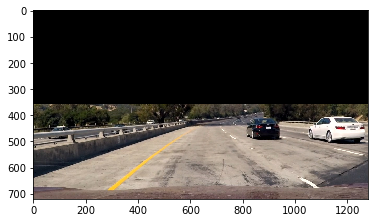

In [33]:
collect = False
diag = 4
notext = False
valid = True

scrType = diag
if (scrType & 7) > 0:
    debug = True
if not notext:
    scrType = scrType | 8
if collect:
    print("Will collect training data from %s..." % (args.infilename))
    scrType = scrType | 16

cam_cal = CameraCal('camera_cal', 'camera_cal/calibrationdata.p')
image = cv2.cvtColor(cv2.imread('test_images/test1.jpg'), cv2.COLOR_BGR2RGB)
cam_cal.setImageSize(image.shape)
roadMgr = RoadManager(cam_cal, debug=debug, scrType=scrType)

roadMgr = RoadManager(cam_cal, debug=debug, scrType=scrType)

if debug:
    diagMgr = DiagManager(roadMgr)
else:
    diagMgr = None

if image is not None:
    print("image processing %s..." % ('test_images/test1.jpg'))
    imageout = process_image(image)
    cv2.imwrite('output_images/test1_out.jpg', cv2.cvtColor(imageout, cv2.COLOR_RGB2BGR))
    print("done image processing %s..." % ('output_images/test1_out.jpg'))
    
test = ImageFilters(roadMgr.projMgr.camCal,roadMgr.projMgr.projectedX,roadMgr.projMgr.projectedY,debug=True)
test_img = test.makehalf(image)
test_img = test.makefull(test_img)

projectionTopPixel = test.projectionThrowDistanceDetect(debug=True)
print(projectionTopPixel)

plt.imshow(test_img)

In [34]:
collect = False
diag = 3
notext = False
valid = True

scrType = diag
if (scrType & 7) > 0:
    debug = True
if not notext:
    scrType = scrType | 8
if collect:
    print("Will collect training data from %s..." % (args.infilename))
    scrType = scrType | 16

cam_cal = CameraCal('camera_cal', 'camera_cal/calibrationdata.p')
image = cv2.cvtColor(cv2.imread('test_images/this3.png'), cv2.COLOR_BGR2RGB)
cam_cal.setImageSize(image.shape)
roadMgr = RoadManager(cam_cal, debug=debug, scrType=scrType)

roadMgr = RoadManager(cam_cal, debug=debug, scrType=scrType)

if debug:
    diagMgr = DiagManager(roadMgr)
else:
    diagMgr = None

if image is not None:
    print("image processing %s..." % ('test_images/this3.png'))
    imageout = process_image(image)
    cv2.imwrite('output_images/this3_out.png', cv2.cvtColor(imageout, cv2.COLOR_RGB2BGR))
    print("done image processing %s..." % ('output_images/this3_out.png'))

NameError: name 'args' is not defined